# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here;
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from operator import itemgetter
import time
from matplotlib import pyplot
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Datasets/azdias.csv')
customers = pd.read_csv('Datasets/customers.csv')
dias_attributes = pd.read_excel('Datasets/DIAS Attributes - Values 2017.xlsx', header = 1)
ind_levels = pd.read_excel('Datasets/DIAS Information Levels - Attributes 2017.xlsx', header = 1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
del azdias['Unnamed: 0']
del customers['Unnamed: 0']
del dias_attributes['Unnamed: 0']
del ind_levels['Unnamed: 0']

## Data Exploration

* We explore dataset by dataset, in order to find patterns and then we could make some conclusions about data exploration. 

## Azdias dataset

In [4]:
azdias.head(10)

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   
5  910244         3         1.0      10.0          NaN          NaN   
6  910248        -1         9.0       0.0          NaN          NaN   
7  910261        -1         1.0      14.0          NaN          NaN   
8  645145        -1         9.0      16.0          NaN          NaN   
9  645153        -1         5.0      17.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   
5          NaN          NaN                  10.0                  5.0  ...   
6          NaN          NaN                   NaN                  4.0  ...   
7          NaN          NaN                  14.0                  6.0  ...   
8          NaN          NaN                  16.0                  2.0  ...   
9          NaN          NaN                  17.0                  9.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  NaN       NaN         NaN      NaN             NaN             NaN   
1  4.0       8.0        11.0     10.0             3.0             9.0   
2  2.0       9.0         9.0      6.0             3.0             9.0   
3  0.0       7.0        10.0     11.0             NaN             9.0   
4  2.0       3.0         5.0      4.0             2.0             9.0   
5  2.0      10.0         7.0      4.0             6.0             9.0   
6  2.0       7.0        10.0     10.0             3.0             9.0   
7  2.0      10.0        12.0      9.0             5.0             9.0   
8  4.0       8.0        11.0      8.0             5.0             8.0   
9  4.0       1.0         1.0      1.0             4.0             3.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       NaN        3         1                    2  
1       4.0        5         2                    1  
2       2.0        5         2                    3  
3       7.0        3         2                    4  
4       3.0        4         1                    3  
5       7.0        4         2                    1  
6       5.0        4         2                    2  
7       1.0        1         1                    1  
8       1.0        6         1                    3  
9       7.0        4         2                    3  

[10 rows x 366 columns]

In [5]:
# checking azdias dataset proportions  
print('Azdias dataset shape \n')
shape_a = azdias.shape
print('Number of rows:', shape_a[0])
print('Number of columns:', shape_a[1])

Azdias dataset shape 

Number of rows: 891221
Number of columns: 366


In [6]:
# checking the proportion of null values 
pd.set_option('display.max_rows', 400)
percent_missing_a = azdias.isnull().sum() * 100 / len(azdias)
missing_value_a = pd.DataFrame({'column_name': azdias.columns,
                                 'percent_missing': percent_missing_a})
missing_value_a.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
ALTER_KIND4                                  ALTER_KIND4        99.864792
ALTER_KIND3                                  ALTER_KIND3        99.307691
ALTER_KIND2                                  ALTER_KIND2        96.690047
ALTER_KIND1                                  ALTER_KIND1        90.904837
EXTSEL992                                      EXTSEL992        73.399639
KK_KUNDENTYP                                KK_KUNDENTYP        65.596749
ALTERSKATEGORIE_FEIN                ALTERSKATEGORIE_FEIN        29.504130
D19_VERSAND_ONLINE_QUOTE_12  D19_VERSAND_ONLINE_QUOTE_12        28.849522
D19_LOTTO                                      D19_LOTTO        28.849522
D19_BANKEN_ONLINE_QUOTE_12    D19_BANKEN_ONLINE_QUOTE_12        28.849522
D19_LETZTER_KAUF_BRANCHE        D19_LETZTER_KAUF_BRANCHE        28.849522
D19_SOZIALES                                D19_SOZIALES        28.849522
D19_GESAMT_ONLINE_QUOTE_12    D19_GESAMT_ONLINE_QUOTE_12        28.849522
D19_KONSUMTYP                              D19_KONSUMTYP        28.849522
D19_VERSI_ONLINE_QUOTE_12      D19_VERSI_ONLINE_QUOTE_12        28.849522
D19_TELKO_ONLINE_QUOTE_12      D19_TELKO_ONLINE_QUOTE_12        28.849522
KBA05_DIESEL                                KBA05_DIESEL        14.959701
KBA05_CCM4                                    KBA05_CCM4        14.959701
KBA05_GBZ                                      KBA05_GBZ        14.959701
KBA05_FRAU                                    KBA05_FRAU        14.959701
KBA05_ZUL4                                    KBA05_ZUL4        14.959701
KBA05_HERST1                                KBA05_HERST1        14.959701
KBA05_HERST2                                KBA05_HERST2        14.959701
KBA05_HERST3                                KBA05_HERST3        14.959701
KBA05_CCM3                                    KBA05_CCM3        14.959701
KBA05_HERST5                                KBA05_HERST5        14.959701
KBA05_KRSAQUOT                            KBA05_KRSAQUOT        14.959701
KBA05_HERST4                                KBA05_HERST4        14.959701
KBA05_AUTOQUOT                            KBA05_AUTOQUOT        14.959701
KBA05_CCM2                                    KBA05_CCM2        14.959701
KBA05_CCM1                                    KBA05_CCM1        14.959701
KBA05_BAUMAX                                KBA05_BAUMAX        14.959701
KBA05_KRSHERST2                          KBA05_KRSHERST2        14.959701
KBA05_ANTG4                                  KBA05_ANTG4        14.959701
KBA05_ANTG3                                  KBA05_ANTG3        14.959701
KBA05_ANTG2                                  KBA05_ANTG2        14.959701
KBA05_ANTG1                                  KBA05_ANTG1        14.959701
KBA05_ANHANG                                KBA05_ANHANG        14.959701
KBA05_ALTER4                                KBA05_ALTER4        14.959701
KBA05_ALTER3                                KBA05_ALTER3        14.959701
KBA05_ALTER2                                KBA05_ALTER2        14.959701
KBA05_ALTER1                                KBA05_ALTER1        14.959701
KBA05_KRSHERST1                          KBA05_KRSHERST1        14.959701
KBA05_KRSZUL                                KBA05_KRSZUL        14.959701
KBA05_KRSHERST3                          KBA05_KRSHERST3        14.959701
KBA05_SEG8                                    KBA05_SEG8        14.959701
KBA05_SEG2                                    KBA05_SEG2        14.959701
KBA05_SEG3                                    KBA05_SEG3        14.959701
KBA05_SEG4                                    KBA05_SEG4        14.959701
KBA05_SEG5                                    KBA05_SEG5        14.959701
KBA05_SEG6                                    KBA05_SEG6        14.959701
KBA05_SEG7                                    KBA05_SEG7        14.959701
KBA05_SEG9                                    KBA05_SEG9        14.959701
KBA05_SEG1                                    KBA

The variables with the most missing values, for this dataset, are: 
* 'ALTER_KIND4' -> 99.8%
* 'ALTER_KIND3' -> 99.3%
* 'ALTER_KIND2' -> 96.7%
* 'ALTER_KIND1' -> 90.9%
* 'EXTSEL992'   -> 73.3%
* 'KK_KUNDENTYP'-> 65.5%

We need to determine the % of missing values permited in order to work with the variables. 

In [7]:
#creating table of types
pd.set_option('display.max_rows', 400)
table_az = pd.DataFrame(azdias.dtypes)
table_az.rename(columns={0: 'dtypes'}, inplace=True)
table_az

dtypes
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                   float64
ALTER_HH                     float64
ALTER_KIND1                  float64
ALTER_KIND2                  float64
ALTER_KIND3                  float64
ALTER_KIND4                  float64
ALTERSKATEGORIE_FEIN         float64
ANZ_HAUSHALTE_AKTIV          float64
ANZ_HH_TITEL                 float64
ANZ_KINDER                   float64
ANZ_PERSONEN                 float64
ANZ_STATISTISCHE_HAUSHALTE   float64
ANZ_TITEL                    float64
ARBEIT                       float64
BALLRAUM                     float64
CAMEO_DEU_2015                object
CAMEO_DEUG_2015               object
CAMEO_INTL_2015               object
CJT_GESAMTTYP                float64
CJT_KATALOGNUTZER            float64
CJT_TYP_1                    float64
CJT_TYP_2                    float64
CJT_TYP_3                    float64
CJT_TYP_4                    float64
CJT_TYP_5                    float64
CJT_TYP_6                    float64
D19_BANKEN_ANZ_12              int64
D19_BANKEN_ANZ_24              int64
D19_BANKEN_DATUM               int64
D19_BANKEN_DIREKT              int64
D19_BANKEN_GROSS               int64
D19_BANKEN_LOKAL               int64
D19_BANKEN_OFFLINE_DATUM       int64
D19_BANKEN_ONLINE_DATUM        int64
D19_BANKEN_ONLINE_QUOTE_12   float64
D19_BANKEN_REST                int64
D19_BEKLEIDUNG_GEH             int64
D19_BEKLEIDUNG_REST            int64
D19_BILDUNG                    int64
D19_BIO_OEKO                   int64
D19_BUCH_CD                    int64
D19_DIGIT_SERV                 int64
D19_DROGERIEARTIKEL            int64
D19_ENERGIE                    int64
D19_FREIZEIT                   int64
D19_GARTEN                     int64
D19_GESAMT_ANZ_12              int64
D19_GESAMT_ANZ_24              int64
D19_GESAMT_DATUM               int64
D19_GESAMT_OFFLINE_DATUM       int64
D19_GESAMT_ONLINE_DATUM        int64
D19_GESAMT_ONLINE_QUOTE_12   float64
D19_HANDWERK                   int64
D19_HAUS_DEKO                  int64
D19_KINDERARTIKEL              int64
D19_KONSUMTYP                float64
D19_KONSUMTYP_MAX              int64
D19_KOSMETIK                   int64
D19_LEBENSMITTEL               int64
D19_LETZTER_KAUF_BRANCHE      object
D19_LOTTO                    float64
D19_NAHRUNGSERGAENZUNG         int64
D19_RATGEBER                   int64
D19_REISEN                     int64
D19_SAMMELARTIKEL              int64
D19_SCHUHE                     int64
D19_SONSTIGE                   int64
D19_SOZIALES                 float64
D19_TECHNIK                    int64
D19_TELKO_ANZ_12               int64
D19_TELKO_ANZ_24               int64
D19_TELKO_DATUM                int64
D19_TELKO_MOBILE               int64
D19_TELKO_OFFLINE_DATUM        int64
D19_TELKO_ONLINE_DATUM         int64
D19_TELKO_ONLINE_QUOTE_12    float64
D19_TELKO_REST                 int64
D19_TIERARTIKEL                int64
D19_VERSAND_ANZ_12             int64
D19_VERSAND_ANZ_24             int64
D19_VERSAND_DATUM              int64
D19_VERSAND_OFFLINE_DATUM      int64
D19_VERSAND_ONLINE_DATUM       int64
D19_VERSAND_ONLINE_QUOTE_12  float64
D19_VERSAND_REST               int64
D19_VERSI_ANZ_12               int64
D19_VERSI_ANZ_24               int64
D19_VERSI_DATUM                int64
D19_VERSI_OFFLINE_DATUM        int64
D19_VERSI_ONLINE_DATUM         int64
D19_VERSI_ONLINE_QUOTE_12    float64
D19_VERSICHERUNGEN             int64
D19_VOLLSORTIMENT              int64
D19_WEIN_FEINKOST              int64
DSL_FLAG                     float64
EINGEFUEGT_AM                 object
EINGEZOGENAM_HH_JAHR         float64
EWDICHTE                     float64
EXTSEL992                    float64
FINANZ_ANLEGER                 int64
FINANZ_HAUSBAUER               int64
FINANZ_MINIMALIST              int64
FINANZ_SPARER                  int64
FINANZ_UNAUFFAELLIGER          int64
FINANZ_VORSORGER               int64
FINANZTYP                      int

In [8]:
# table of dtypes proportions
table_prop_az= table_az.groupby(["dtypes"])
table_prop_az= table_prop_az[['dtypes']].count().add_prefix("Sum_of_").reset_index()
table_prop_az['%'] = (table_prop_az['Sum_of_dtypes'] / len(table_az)) *100
print('Table of Azdias dataset dtypes proportions:')
table_prop_az

Table of Azdias dataset dtypes proportions:


dtypes  Sum_of_dtypes          %
0    int64             93  25.409836
1  float64            267  72.950820
2   object              6   1.639344

Most of the variables are floats (72.9%), then are integers (25.4%) , and object variables are the minor dtype (1.6%) in this dataset.

In [9]:
#table of unique values for categorical variable 
object_list_vars_az = [i for i in azdias.columns if azdias.dtypes[i]=='object']
object_vars_az = azdias[object_list_vars_az]
object_vars_az

CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0                 NaN             NaN             NaN   
1                  8A               8              51   
2                  4C               4              24   
3                  2A               2              12   
4                  6B               6              43   
...               ...             ...             ...   
891216             7A               7              41   
891217             9D               9              51   
891218             4C               4              24   
891219             9D               9              51   
891220             6B               6              43   

       D19_LETZTER_KAUF_BRANCHE        EINGEFUEGT_AM OST_WEST_KZ  
0                           NaN                  NaN         NaN  
1                           NaN  1992-02-10 00:00:00           W  
2                 D19_UNBEKANNT  1992-02-12 00:00:00           W  
3                 D19_UNBEKANNT  1997-04-21 00:00:00           W  
4                    D19_SCHUHE  1992-02-12 00:00:00           W  
...                         ...                  ...         ...  
891216            D19_HAUS_DEKO  1992-02-10 00:00:00           W  
891217            D19_UNBEKANNT  1992-02-10 00:00:00           W  
891218       D19_BEKLEIDUNG_GEH  1992-02-10 00:00:00           W  
891219            D19_UNBEKANNT  1992-02-12 00:00:00           W  
891220                      NaN  1992-02-10 00:00:00           W  

[891221 rows x 6 columns]

We could see that :

* 'CAMEO_DEU_2015' as an alphanumeric variable 
* 'EINGEFUEGT_AM' as a datetime categorical variable 
* 'OST_WEST_KZ' as a nominal categorical variable 
* 'CAMEO_DEUG_2015' as a categorical variable, possible int variable
* 'CAMEO_INTL_2015' as a categorical variable, possible int variable 
* 'D19_LETZTER_KAUF_BRANCHE' as a categorical value

So we need to decide which ones could help us to work in the next steps.

In [10]:
# checking the proportion of null object values 

pd.set_option('display.max_rows', 400)
percent_missing_c = object_vars_az.isnull().sum() * 100 / len(object_vars_az)
missing_value_c = pd.DataFrame({'column_name': object_vars_az.columns,
                                 'percent_missing': percent_missing_c})
missing_value_c.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
D19_LETZTER_KAUF_BRANCHE  D19_LETZTER_KAUF_BRANCHE        28.849522
CAMEO_DEU_2015                      CAMEO_DEU_2015        11.106000
CAMEO_DEUG_2015                    CAMEO_DEUG_2015        11.106000
CAMEO_INTL_2015                    CAMEO_INTL_2015        11.106000
EINGEFUEGT_AM                        EINGEFUEGT_AM        10.451729
OST_WEST_KZ                            OST_WEST_KZ        10.451729

The object variable with the most missing values is 'D19_LETZTER_KAUF_BRANCHE'.

In [11]:
# dataset description 

pd.set_option('display.max_columns', 400)
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL  \
count         628274.000000        798073.000000  794213.000000   
mean              13.700717             8.287263       0.040647   
std                5.079849            15.628087       0.324028   
min                0.000000             0.000000       0.000000   
25%               11.000000             1.000000       0.000000   
50%               14.000000             4.000000       0.000000   
75%               17.000000             9.000000       0.000000   
max               25.000000           595.000000      23.000000   

          ANZ_KINDER   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
count  817722.000000  817722.000000               798073.000000   
mean        0.154018       1.727637                    7.599356   
std         0.502389       1.155849                   14.332201   
min         0.000000       0.000000                    0.000000   
25%         0.000000       1.000000                    1.000000   
50%         0.000000       1.000000                    3.000000   
75%         0.000000       2.000000                    9.000000   
max        11.000000      45.000000                  449.000000   

           ANZ_TITEL         ARBEIT       BALLRAUM  CJT_GESAMTTYP  \
count  817722.000000  794005.000000  797481.000000  886367.000000   
mean        0.004162       3.167854       4.153043       3.632838   
std         0.068855       1.002376       2.183710       1.595021   
min         0.000000       1.000000       1.000000       1.000000   
25%         0.000000       3.000000       2.000000       2.000000   
50%         0.000000       3.000000       5.000000       4.000000   
75%         0.000000       4.000000       6.000000       5.000000   
max         6.000000       9.000000       7.000000       6.000000   

       CJT_KATALOGNUTZER      CJT_TYP_1      CJT_TYP_2      CJT_TYP_3  \
count      886367.000000  886367.000000  886367.000000  886367.000000   
mean            3.335264       3.368086       3.195014       3.351290   
std             1.493633       1.368331       1.401382       1.396508   
min             1.000000       1.000000       1.000000       1.000000   
25%             2.000000       2.000000       2.000000       2.000000   
50%             4.000000       3.000000       3.000000       3.000000   
75%             5.000000       5.000000       5.000000       5.000000   
max             5.000000       5.000000       5.000000       5.000000   

           CJT_TYP_4      CJT_TYP_5      CJT_TYP_6  D19_BANKEN_ANZ_12  \
count  886367.000000  886367.000000  886367.000000      891221.000000   
mean        3.336151       3.360684       3.465980           0.122336   
std         1.373077       1.378992       1.328456           0.535950   
min         1.000000       1.000000       1.000000     

## Customers dataset 

In [12]:
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                         1.0   
1           NaN         0.0           3.0                         NaN   
2           0.0         0.0           1.0                         1.0   
3           NaN         0.0           0.0                         1.0   
4           0.0         0.0           4.0                         7.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        0.0     1.0       3.0             1A               1              13   
1        0.0     NaN       NaN            NaN             NaN             NaN   
2        0.0     3.0       7.0             5D               5              34   
3        0.0     1.0       7.0             4C               4              24   
4        0.0     3.0       3.0             7B               7              41   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            5.0                4.0        1.0        1.0        5.0   
1            NaN                NaN        NaN        NaN        NaN   
2            2.0                5.0        2.0        2.0        5.0   
3            2.0                5.0        1.0        1.0        5.0   
4            6.0                4.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        NaN        NaN        NaN                  0                  1   
2        5.0        5.0        5.0                  0                  0   
3        5.0        5.0        5.0                  0                  0   
4        4.0        3.0        3.0                  1                  2   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                 6                  0                 5                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 3                  5                 0                 3   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        7   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         0.0                0                   0   
1                         0.0                6                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                         0.0                0                   0   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

In [13]:
# checking customers dataset proportions 

print('Customers dataset shape \n')
shape_c = customers.shape
print('Number of rows :', shape_c[0])
print('Number of columns :', shape_c[1])

Customers dataset shape 

Number of rows : 191652
Number of columns : 369


In [14]:
# checkin the proportion of null values 
pd.set_option('display.max_rows', 400)
percent_missing_c = customers.isnull().sum() * 100 / len(customers)
missing_value_c = pd.DataFrame({'column_name': customers.columns,
                                 'percent_missing': percent_missing_c})
missing_value_c.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
ALTER_KIND4                                  ALTER_KIND4        99.876860
ALTER_KIND3                                  ALTER_KIND3        99.334732
ALTER_KIND2                                  ALTER_KIND2        97.338927
ALTER_KIND1                                  ALTER_KIND1        93.860748
KK_KUNDENTYP                                KK_KUNDENTYP        58.406382
EXTSEL992                                      EXTSEL992        44.498883
KBA05_KRSOBER                              KBA05_KRSOBER        29.209192
KBA05_KRSHERST1                          KBA05_KRSHERST1        29.209192
KBA05_GBZ                                      KBA05_GBZ        29.209192
KBA05_HERST1                                KBA05_HERST1        29.209192
KBA05_HERST2                                KBA05_HERST2        29.209192
KBA05_HERST3                                KBA05_HERST3        29.209192
KBA05_HERST4                                KBA05_HERST4        29.209192
KBA05_HERST5                                KBA05_HERST5        29.209192
KBA05_KRSAQUOT                            KBA05_KRSAQUOT        29.209192
KBA05_KRSVAN                                KBA05_KRSVAN        29.209192
KBA05_KRSHERST2                          KBA05_KRSHERST2        29.209192
KBA05_KRSKLEIN                            KBA05_KRSKLEIN        29.209192
KBA05_DIESEL                                KBA05_DIESEL        29.209192
KBA05_KRSZUL                                KBA05_KRSZUL        29.209192
KBA05_KW1                                      KBA05_KW1        29.209192
KBA05_KW2                                      KBA05_KW2        29.209192
KBA05_KW3                                      KBA05_KW3        29.209192
KBA05_FRAU                                    KBA05_FRAU        29.209192
KBA05_CCM2                                    KBA05_CCM2        29.209192
KBA05_CCM4                                    KBA05_CCM4        29.209192
KBA05_ANTG1                                  KBA05_ANTG1        29.209192
MOBI_REGIO                                    MOBI_REGIO        29.209192
KBA05_ALTER1                                KBA05_ALTER1        29.209192
KBA05_ALTER2                                KBA05_ALTER2        29.209192
KBA05_ALTER3                                KBA05_ALTER3        29.209192
KBA05_ALTER4                                KBA05_ALTER4        29.209192
KBA05_ANHANG                                KBA05_ANHANG        29.209192
KBA05_ANTG2                                  KBA05_ANTG2        29.209192
KBA05_CCM3                                    KBA05_CCM3        29.209192
KBA05_ANTG3                                  KBA05_ANTG3        29.209192
KBA05_ANTG4                                  KBA05_ANTG4        29.209192
KBA05_AUTOQUOT                            KBA05_AUTOQUOT        29.209192
KBA05_BAUMAX                                KBA05_BAUMAX        29.209192
KBA05_CCM1                                    KBA05_CCM1        29.209192
KBA05_MAXBJ                                  KBA05_MAXBJ        29.209192
KBA05_MAXAH                                  KBA05_MAXAH        29.209192
KBA05_KRSHERST3                          KBA05_KRSHERST3        29.209192
KBA05_MAXHERST                            KBA05_MAXHERST        29.209192
KBA05_SEG9                                    KBA05_SEG9        29.209192
KBA05_SEG3                                    KBA05_SEG3        29.209192
KBA05_SEG4                                    KBA05_SEG4        29.209192
KBA05_SEG5                                    KBA05_SEG5        29.209192
KBA05_SEG6                                    KBA05_SEG6        29.209192
KBA05_SEG7                                    KBA05_SEG7        29.209192
KBA05_SEG8                                    KBA05_SEG8        29.209192
KBA05_VORB0                                  KBA05_VORB0        29.209192
KBA05_SEG10                                  KBA05_SEG10        29.209192
KBA05_VORB1                                  KBA0

The variables with the most missing values, for this dataset, are: 

* 'ALTER_KIND4' -> 99.8%
* 'ALTER_KIND3' -> 99.3%
* 'ALTER_KIND2' -> 97.3%
* 'ALTER_KIND1' -> 93.8%
* 'KK_KUNDENTYP'-> 58.4%
* 'EXTSEL992'    -> 44.9.%

These are the same variables with almost the same percentage of missing values as the previous dataset(azdias). We also need to determine the % of missing values permited in order to work with the variables. 

In [15]:
#creating table of dtypes

pd.set_option('display.max_rows', 400)
table_cust = pd.DataFrame(customers.dtypes)
table_cust.rename(columns={0: 'dtypes'}, inplace=True)
table_cust

dtypes
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                   float64
ALTER_HH                     float64
ALTER_KIND1                  float64
ALTER_KIND2                  float64
ALTER_KIND3                  float64
ALTER_KIND4                  float64
ALTERSKATEGORIE_FEIN         float64
ANZ_HAUSHALTE_AKTIV          float64
ANZ_HH_TITEL                 float64
ANZ_KINDER                   float64
ANZ_PERSONEN                 float64
ANZ_STATISTISCHE_HAUSHALTE   float64
ANZ_TITEL                    float64
ARBEIT                       float64
BALLRAUM                     float64
CAMEO_DEU_2015                object
CAMEO_DEUG_2015               object
CAMEO_INTL_2015               object
CJT_GESAMTTYP                float64
CJT_KATALOGNUTZER            float64
CJT_TYP_1                    float64
CJT_TYP_2                    float64
CJT_TYP_3                    float64
CJT_TYP_4                    float64
CJT_TYP_5                    float64
CJT_TYP_6                    float64
D19_BANKEN_ANZ_12              int64
D19_BANKEN_ANZ_24              int64
D19_BANKEN_DATUM               int64
D19_BANKEN_DIREKT              int64
D19_BANKEN_GROSS               int64
D19_BANKEN_LOKAL               int64
D19_BANKEN_OFFLINE_DATUM       int64
D19_BANKEN_ONLINE_DATUM        int64
D19_BANKEN_ONLINE_QUOTE_12   float64
D19_BANKEN_REST                int64
D19_BEKLEIDUNG_GEH             int64
D19_BEKLEIDUNG_REST            int64
D19_BILDUNG                    int64
D19_BIO_OEKO                   int64
D19_BUCH_CD                    int64
D19_DIGIT_SERV                 int64
D19_DROGERIEARTIKEL            int64
D19_ENERGIE                    int64
D19_FREIZEIT                   int64
D19_GARTEN                     int64
D19_GESAMT_ANZ_12              int64
D19_GESAMT_ANZ_24              int64
D19_GESAMT_DATUM               int64
D19_GESAMT_OFFLINE_DATUM       int64
D19_GESAMT_ONLINE_DATUM        int64
D19_GESAMT_ONLINE_QUOTE_12   float64
D19_HANDWERK                   int64
D19_HAUS_DEKO                  int64
D19_KINDERARTIKEL              int64
D19_KONSUMTYP                float64
D19_KONSUMTYP_MAX              int64
D19_KOSMETIK                   int64
D19_LEBENSMITTEL               int64
D19_LETZTER_KAUF_BRANCHE      object
D19_LOTTO                    float64
D19_NAHRUNGSERGAENZUNG         int64
D19_RATGEBER                   int64
D19_REISEN                     int64
D19_SAMMELARTIKEL              int64
D19_SCHUHE                     int64
D19_SONSTIGE                   int64
D19_SOZIALES                 float64
D19_TECHNIK                    int64
D19_TELKO_ANZ_12               int64
D19_TELKO_ANZ_24               int64
D19_TELKO_DATUM                int64
D19_TELKO_MOBILE               int64
D19_TELKO_OFFLINE_DATUM        int64
D19_TELKO_ONLINE_DATUM         int64
D19_TELKO_ONLINE_QUOTE_12    float64
D19_TELKO_REST                 int64
D19_TIERARTIKEL                int64
D19_VERSAND_ANZ_12             int64
D19_VERSAND_ANZ_24             int64
D19_VERSAND_DATUM              int64
D19_VERSAND_OFFLINE_DATUM      int64
D19_VERSAND_ONLINE_DATUM       int64
D19_VERSAND_ONLINE_QUOTE_12  float64
D19_VERSAND_REST               int64
D19_VERSI_ANZ_12               int64
D19_VERSI_ANZ_24               int64
D19_VERSI_DATUM                int64
D19_VERSI_OFFLINE_DATUM        int64
D19_VERSI_ONLINE_DATUM         int64
D19_VERSI_ONLINE_QUOTE_12    float64
D19_VERSICHERUNGEN             int64
D19_VOLLSORTIMENT              int64
D19_WEIN_FEINKOST              int64
DSL_FLAG                     float64
EINGEFUEGT_AM                 object
EINGEZOGENAM_HH_JAHR         float64
EWDICHTE                     float64
EXTSEL992                    float64
FINANZ_ANLEGER                 int64
FINANZ_HAUSBAUER               int64
FINANZ_MINIMALIST              int64
FINANZ_SPARER                  int64
FINANZ_UNAUFFAELLIGER          int64
FINANZ_VORSORGER               int64
FINANZTYP                      int

In [16]:
# table of dtype proportions

table_prop_cust= table_cust.groupby(["dtypes"])
table_prop_cus= table_prop_cust[['dtypes']].count().add_prefix("Sum_of_").reset_index()
table_prop_cus['%'] = (table_prop_cus['Sum_of_dtypes'] / len(table_cust)) *100
print('Table of Customers dataset dtypes proportions')
table_prop_cus

Table of Customers dataset dtypes proportions


dtypes  Sum_of_dtypes          %
0    int64             94  25.474255
1  float64            267  72.357724
2   object              8   2.168022

Most of the variables are floats (72.3%), then are integers (25.4%) , and object variables are the minor dtype (2.6%) in this dataset. 

In [17]:
#table of unique values for categorical variable 

object_list_vars_cu = [i for i in customers.columns if customers.dtypes[i]=='object']
object_vars_cu = customers[object_list_vars_cu]
object_vars_cu

CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0                  1A               1              13   
1                 NaN             NaN             NaN   
2                  5D               5              34   
3                  4C               4              24   
4                  7B               7              41   
...               ...             ...             ...   
191647             1C               1              14   
191648             5B               5              32   
191649             4D               4              24   
191650             4C               4              24   
191651             5C               5              33   

       D19_LETZTER_KAUF_BRANCHE        EINGEFUEGT_AM OST_WEST_KZ  \
0                 D19_UNBEKANNT  1992-02-12 00:00:00           W   
1              D19_BANKEN_GROSS                  NaN         NaN   
2                 D19_UNBEKANNT  1992-02-10 00:00:00           W   
3        D19_NAHRUNGSERGAENZUNG  1992-02-10 00:00:00           W   
4                    D19_SCHUHE  1992-02-12 00:00:00           W   
...                         ...                  ...         ...   
191647          D19_BANKEN_REST  1992-02-10 00:00:00           W   
191648            D19_UNBEKANNT  1997-03-06 00:00:00           W   
191649              D19_TECHNIK  1992-02-10 00:00:00           W   
191650          D19_BANKEN_REST  1992-02-10 00:00:00           W   
191651               D19_SCHUHE  1992-02-12 00:00:00           W   

            PRODUCT_GROUP CUSTOMER_GROUP  
0       COSMETIC_AND_FOOD    MULTI_BUYER  
1                    FOOD   SINGLE_BUYER  
2       COSMETIC_AND_FOOD    MULTI_BUYER  
3                COSMETIC    MULTI_BUYER  
4                    FOOD    MULTI_BUYER  
...                   ...            ...  
191647  COSMETIC_AND_FOOD    MULTI_BUYER  
191648           COSMETIC   SINGLE_BUYER  
191649  COSMETIC_AND_FOOD    MULTI_BUYER  
191650               FOOD   SINGLE_BUYER  
191651  COSMETIC_AND_FOOD    MULTI_BUYER  

[191652 rows x 8 columns]

We could see that :

* 'CAMEO_DEU_2015' as an alphanumericvariable 
* 'EINGEFUEGT_AM' as a datetime categorical variable 
* 'OST_WEST_KZ' as a nominal categorical variable 
* 'CAMEO_DEUG_2015' as a categorical variable, possible int variable
* 'CAMEO_INTL_2015' as a categorical variable, possible int variable 
* 'D19_LETZTER_KAUF_BRANCHE' as a nominal categorical variable 
* 'PRODUCT_GROUP' as a nominal categorical variable
* 'CUSTOMER_GROUP' as a nominal categorical variable

So we could remove all except 'OST_WEST_KZ', for simplicity, converting it to binary integer value. 

In [18]:
# checking the proportion of null object values 

percent_missing_c = object_vars_cu.isnull().sum() * 100 / len(object_vars_cu)
missing_value_c = pd.DataFrame({'column_name': object_vars_cu.columns,
                                 'percent_missing': percent_missing_c})
missing_value_c.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
CAMEO_DEU_2015                      CAMEO_DEU_2015        26.312274
CAMEO_DEUG_2015                    CAMEO_DEUG_2015        26.312274
CAMEO_INTL_2015                    CAMEO_INTL_2015        26.312274
EINGEFUEGT_AM                        EINGEFUEGT_AM        26.050863
OST_WEST_KZ                            OST_WEST_KZ        26.050863
D19_LETZTER_KAUF_BRANCHE  D19_LETZTER_KAUF_BRANCHE        24.887296
PRODUCT_GROUP                        PRODUCT_GROUP         0.000000
CUSTOMER_GROUP                      CUSTOMER_GROUP         0.000000

The object variable with the most missing values is 'D19_LETZTER_KAUF_BRANCHE', also as the previuos dataset.

In [19]:
# dataset description  

pd.set_option('display.max_columns', 400)
customers.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%       13.000000    14.000000    15.000000    16.000000   
75%       16.000000    16.000000    17.000000    17.000000   
max       18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL  \
count         139810.000000        141725.000000  139542.000000   
mean              10.331579             4.965863       0.067413   
std                4.134828            14.309694       0.545576   
min                0.000000             0.000000       0.000000   
25%                9.000000             1.000000       0.000000   
50%               10.000000             1.000000       0.000000   
75%               13.000000             4.000000       0.000000   
max               25.000000           523.000000      23.000000   

          ANZ_KINDER   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
count  145056.000000  145056.000000               141725.000000   
mean        0.136402       2.267828                    4.701288   
std         0.493249       1.390620                   14.184081   
min         0.000000       0.000000                    0.000000   
25%         0.000000       1.000000                    1.000000   
50%         0.000000       2.000000                    1.000000   
75%         0.000000       3.000000                    3.000000   
max         8.000000      21.000000                  375.000000   

           ANZ_TITEL         ARBEIT       BALLRAUM  CJT_GESAMTTYP  \
count  145056.000000  141176.000000  141693.000000  188439.000000   
mean        0.020392       2.824850       4.301758       3.677928   
std         0.152234       1.012415       2.114614       1.813975   
min         0.000000       1.000000       1.000000       1.000000   
25%         0.000000       2.000000       2.000000       2.000000   
50%         0.000000       3.000000       5.000000       4.000000   
75%         0.000000       4.000000       6.000000       6.000000   
max         5.000000       9.000000       7.000000       6.000000   

       CJT_KATALOGNUTZER      CJT_TYP_1      CJT_TYP_2      CJT_TYP_3  \
count       188439.00000  188439.000000  188439.000000  188439.000000   
mean             4.00994       2.665441       2.548490       4.516369   
std              1.37894       1.545714       1.557262       0.874722   
min              1.00000       1.000000       1.000000       1.000000   
25%              3.00000       1.000000       1.000000       4.000000   
50%              5.00000       2.000000       2.000000       5.000000   
75%              5.00000       4.000000       4.000000       5.000000   
max              5.00000       5.000000       5.000000       5.000000   

           CJT_TYP_4      CJT_TYP_5      CJT_TYP_6  D19_BANKEN_ANZ_12  \
count  188439.000000  188439.000000  188439.000000      191652.000000   
mean        4.415317       4.519956       4.538838           0.091040   
std         1.025281       0.895371       0.886091           0.416684   
min         1.000000       1.000000       1.000000      

## Dias attributes values dataset 

In [20]:
dias_attributes.head()

Attribute         Description Value                     Meaning
0  AGER_TYP  best-ager typology    -1                     unknown
1       NaN                 NaN     0  no classification possible
2       NaN                 NaN     1             passive elderly
3       NaN                 NaN     2            cultural elderly
4       NaN                 NaN     3   experience-driven elderly

In [21]:
# checking dias dataset proportions  

print('Dias attributes values dataset shape \n')
shape_d = dias_attributes.shape
print('Number of rows :', shape_d[0])
print('Number of columns :', shape_d[1])

Dias attributes values dataset shape 

Number of rows : 2258
Number of columns : 4


In [22]:
# checking the proportion of null values 

percent_missing_d = dias_attributes.isnull().sum() * 100 / len(dias_attributes)
missing_value_d = pd.DataFrame({'column_name': dias_attributes.columns,
                                 'percent_missing': percent_missing_d})
missing_value_d.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
Attribute      Attribute        86.093888
Description  Description        84.455270
Meaning          Meaning         0.487157
Value              Value         0.000000

The 'Attribute' and the 'Description' are the most variables with missing values in this dataset.

In [23]:
#creating table of types

table_d = pd.DataFrame(dias_attributes.dtypes)
table_d.rename(columns={0: 'dtypes'}, inplace=True)
table_d

dtypes
Attribute    object
Description  object
Value        object
Meaning      object

In [24]:
# applying fillna method 'ffill' to the attributes column  

feat_info_= dias_attributes['Attribute'].fillna(method='ffill')
dias_attributes['Attribute'] = feat_info_
dias_attributes.head(11)

Attribute                                   Description  Value  \
0               AGER_TYP                            best-ager typology     -1   
1               AGER_TYP                                           NaN      0   
2               AGER_TYP                                           NaN      1   
3               AGER_TYP                                           NaN      2   
4               AGER_TYP                                           NaN      3   
5   ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6   ALTERSKATEGORIE_GROB                                           NaN      1   
7   ALTERSKATEGORIE_GROB                                           NaN      2   
8   ALTERSKATEGORIE_GROB                                           NaN      3   
9   ALTERSKATEGORIE_GROB                                           NaN      4   
10  ALTERSKATEGORIE_GROB                                           NaN      9   

                       Meaning  
0                      unknown  
1   no classification possible  
2              passive elderly  
3             cultural elderly  
4    experience-driven elderly  
5                      unknown  
6                   < 30 years  
7                30 - 45 years  
8                46 - 60 years  
9                   > 60 years  
10       uniformly distributed

In [25]:
# ordering the dataset to view sorted attributes 

pd.set_option('display.max_rows', 5000)
dias_attributes_2 = dias_attributes
dias_attributes_2 = dias_attributes_2[~dias_attributes_2['Attribute'].isnull()]
dias_attributes_2.sort_values(by=['Attribute', 'Description'], ascending = True)

Attribute  \
0                        AGER_TYP   
1                        AGER_TYP   
2                        AGER_TYP   
3                        AGER_TYP   
4                        AGER_TYP   
5            ALTERSKATEGORIE_GROB   
6            ALTERSKATEGORIE_GROB   
7            ALTERSKATEGORIE_GROB   
8            ALTERSKATEGORIE_GROB   
9            ALTERSKATEGORIE_GROB   
10           ALTERSKATEGORIE_GROB   
11                       ALTER_HH   
12                       ALTER_HH   
13                       ALTER_HH   
14                       ALTER_HH   
15                       ALTER_HH   
16                       ALTER_HH   
17                       ALTER_HH   
18                       ALTER_HH   
19                       ALTER_HH   
20                       ALTER_HH   
21                       ALTER_HH   
22                       ALTER_HH   
23                       ALTER_HH   
24                       ALTER_HH   
25                       ALTER_HH   
26                       ALTER_HH   
27                       ALTER_HH   
28                       ALTER_HH   
29                       ALTER_HH   
30                       ALTER_HH   
31                       ALTER_HH   
32                       ALTER_HH   
33                      ANREDE_KZ   
34                      ANREDE_KZ   
35                      ANREDE_KZ   
36            ANZ_HAUSHALTE_AKTIV   
37                   ANZ_HH_TITEL   
38                   ANZ_PERSONEN   
39                      ANZ_TITEL   
40                       BALLRAUM   
41                       BALLRAUM   
42                       BALLRAUM   
43                       BALLRAUM   
44                       BALLRAUM   
45                       BALLRAUM   
46                       BALLRAUM   
47                       BALLRAUM   
48                       BIP_FLAG   
49                       BIP_FLAG   
50                       BIP_FLAG   
51                CAMEO_DEUG_2015   
52                CAMEO_DEUG_2015   
53                CAMEO_DEUG_2015   
54                CAMEO_DEUG_2015   
55                CAMEO_DEUG_2015   
56                CAMEO_DEUG_2015   
57                CAMEO_DEUG_2015   
58                CAMEO_DEUG_2015   
59                CAMEO_DEUG_2015   
60                CAMEO_DEUG_2015   
106            CAMEO_DEUINTL_2015   
105            CAMEO_DEUINTL_2015   
107            CAMEO_DEUINTL_2015   
108            CAMEO_DEUINTL_2015   
109            CAMEO_DEUINTL_2015   
110            CAMEO_DEUINTL_2015   
111            CAMEO_DEUINTL_2015   
112            CAMEO_DEUINTL_2015   
113            CAMEO_DEUINTL_2015   
114            CAMEO_DEUINTL_2015   
115            CAMEO_DEUINTL_2015   
116            CAMEO_DEUINTL_2015   
117            CAMEO_DEUINTL_2015   
118            CAMEO_DEUINTL_2015   
119            CAMEO_DEUINTL_2015   
120            CAMEO_DEUINTL_2015   
121            CAMEO_DEUINTL_2015   
122            CAMEO_DEUINTL_2015   
123            CAMEO_DEUINTL_2015   
124            CAMEO_DEUINTL_2015   
125            CAMEO_DEUINTL_2015   
126            CAMEO_DEUINTL_2015   
127            CAMEO_DEUINTL_2015   
128            CAMEO_DEUINTL_2015   
129            CAMEO_DEUINTL_2015   
130            CAMEO_DEUINTL_2015   
61                 CAMEO_DEU_2015   
62                 CAMEO_DEU_2015   
63                 CAMEO_DEU_2015   
64                 CAMEO_DEU_2015   
65                 CAMEO_DEU_2015   
66                 CAMEO_DEU_2015   
67                 CAMEO_DEU_2015   
68                 CAMEO_DEU_2015   
69                 CAMEO_DEU_2015   
70                 CAMEO_DEU_2015   
71                 CAMEO_DEU_2015   
72                 CAMEO_DEU_2015   
73                 CAMEO_DEU_2015   
74                 CAMEO_DEU_2015   
75                 CAMEO_DEU_2015   
76                 CAMEO_DEU_2015   
77                 CAMEO_DEU_2015   
78                 CAMEO_DEU_2015   
79                 CAMEO_DEU_2015   
80                 CAMEO_DEU_2015   
81                 CAMEO_DEU

## Dias Information levels dataset 

In [26]:
ind_levels.head()

Information level             Attribute  \
0               NaN              AGER_TYP   
1            Person  ALTERSKATEGORIE_GROB   
2               NaN             ANREDE_KZ   
3               NaN         CJT_GESAMTTYP   
4               NaN     FINANZ_MINIMALIST   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative househo...

In [27]:
# checking levels dataset proportions  
print('Dias Information Levels dataset shape \n')
shape_l = ind_levels.shape
print('Number of rows :', shape_l[0])
print('Number of columns :', shape_l[1])

Dias Information Levels dataset shape 

Number of rows : 313
Number of columns : 4


In [28]:
# checkin the proportion of null values 
percent_missing_l = ind_levels.isnull().sum() * 100 / len(ind_levels)
missing_value_l = pd.DataFrame({'column_name': ind_levels.columns,
                                 'percent_missing': percent_missing_l})
missing_value_l.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
Information level  Information level        96.805112
Additional notes    Additional notes        93.610224
Attribute                  Attribute         0.000000
Description              Description         0.000000

The 'Information level' and the 'Additional notes' are the most variables with missing values in this dataset.

In [29]:
#creating table of types
table_lev = pd.DataFrame(ind_levels.dtypes)
table_lev.rename(columns={0: 'dtypes'}, inplace=True)
table_lev

dtypes
Information level  object
Attribute          object
Description        object
Additional notes   object

### Data Exploration Findings:

* It's helpful to delete variables with certain threshold of missing values.

* 'CAMEO_DEU_2015' is alphanumeric, so we could convert it with integer encoding or one-hot encoding, but it depends on the real meaning of the varible, in order to not affect the results. It seems like a score value. 

* There are 3 variables that are not common in azdias and customers datasets are: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', so it would be helpful to delete them. 

## Data Prepocessing (Cleanup)

Now that we explored the datasets, we need to tranform or modify the variables to model them, according to our bussiness problem.

In [30]:
# comparing proportions

azdias_cols = azdias.columns
custom_cols = customers.columns

common_cols_dias_customers = azdias_cols.intersection(custom_cols)
dias_not_customers = azdias_cols.difference(custom_cols)
customers_not_dias = custom_cols.difference(azdias_cols)

print("These are the common columns between dias and customers:", len(common_cols_dias_customers), '\n')
print("These are the not common columns between dias and customers:", len(dias_not_customers), '\n')
print("These are the uncommon columns between customers and dias:", len(customers_not_dias), '\n')
print("The uncommon columns between customers and dias are:\n",', '.join(list(customers_not_dias)))

These are the common columns between dias and customers: 366 

These are the not common columns between dias and customers: 0 

These are the uncommon columns between customers and dias: 3 

The uncommon columns between customers and dias are:
 CUSTOMER_GROUP, ONLINE_PURCHASE, PRODUCT_GROUP


In [31]:
# comparing the variable proportions on both datasets again
compare_cust = customers 

#removing the 3 variables 
compare_cust.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)
compare_azd = azdias

compare_cust_c = compare_cust.columns
comapre_azd_c = compare_azd.columns
same_vars = compare_cust_c.intersection(comapre_azd_c)

print("The common vairbles between the two datasets are:", len(same_vars))
print("\n")
print("Number of rows/columns (customer dataset):", customers.shape)
print('\n')
print("Number of rows/columns (azdias dataset):", azdias.shape)
print('\n')
if len(same_vars) == customers.shape[1] and len(same_vars) == azdias.shape[1]: 
    print("The datasets have the same variable proportions: ", len(same_vars))

The common vairbles between the two datasets are: 366


Number of rows/columns (customer dataset): (191652, 366)


Number of rows/columns (azdias dataset): (891221, 366)


The datasets have the same variable proportions:  366


Once we verify the proportion on both datasets we apply the threshold for the precentage (%) of missing values allowed. 

## Work with Azdias dataset

In [32]:
# once we ordered the attributes dataset, we find the ecoded values with missing or unknown values (should be 
#converted to NaNs)
dias_attributes_2 = dias_attributes_2[(dias_attributes_2['Meaning'].str.contains("unknown") | dias_attributes_2['Meaning'].str.contains("no "))]
pd.set_option('display.max_rows', 400)
dias_attributes_2 = dias_attributes_2.reset_index()
del dias_attributes_2['index']
dias_attributes_2

Attribute  \
0                       AGER_TYP   
1                       AGER_TYP   
2           ALTERSKATEGORIE_GROB   
3                       ALTER_HH   
4                      ANREDE_KZ   
5                       BALLRAUM   
6                       BIP_FLAG   
7                       BIP_FLAG   
8                CAMEO_DEUG_2015   
9             CAMEO_DEUINTL_2015   
10                 CJT_GESAMTTYP   
11             D19_BANKEN_ANZ_12   
12             D19_BANKEN_ANZ_24   
13              D19_BANKEN_DATUM   
14          D19_BANKEN_DIREKT_RZ   
15           D19_BANKEN_GROSS_RZ   
16           D19_BANKEN_LOKAL_RZ   
17      D19_BANKEN_OFFLINE_DATUM   
18       D19_BANKEN_ONLINE_DATUM   
19    D19_BANKEN_ONLINE_QUOTE_12   
20            D19_BANKEN_REST_RZ   
21         D19_BEKLEIDUNG_GEH_RZ   
22        D19_BEKLEIDUNG_REST_RZ   
23                D19_BILDUNG_RZ   
24               D19_BIO_OEKO_RZ   
25                   D19_BUCH_RZ   
26             D19_DIGIT_SERV_RZ   
27        D19_DROGERIEARTIKEL_RZ   
28                D19_ENERGIE_RZ   
29               D19_FREIZEIT_RZ   
30                 D19_GARTEN_RZ   
31             D19_GESAMT_ANZ_12   
32             D19_GESAMT_ANZ_24   
33              D19_GESAMT_DATUM   
34      D19_GESAMT_OFFLINE_DATUM   
35       D19_GESAMT_ONLINE_DATUM   
36    D19_GESAMT_ONLINE_QUOTE_12   
37               D19_HANDWERK_RZ   
38              D19_HAUS_DEKO_RZ   
39          D19_KINDERARTIKEL_RZ   
40              D19_KK_KUNDENTYP   
41               D19_KOSMETIK_RZ   
42           D19_LEBENSMITTEL_RZ   
43                  D19_LOTTO_RZ   
44     D19_NAHRUNGSERGAENZUNG_RZ   
45               D19_RATGEBER_RZ   
46                 D19_REISEN_RZ   
47          D19_SAMMELARTIKEL_RZ   
48                 D19_SCHUHE_RZ   
49               D19_SONSTIGE_RZ   
50                D19_TECHNIK_RZ   
51              D19_TELKO_ANZ_12   
52              D19_TELKO_ANZ_24   
53               D19_TELKO_DATUM   
54           D19_TELKO_MOBILE_RZ   
55       D19_TELKO_OFFLINE_DATUM   
56        D19_TELKO_ONLINE_DATUM   
57             D19_TELKO_REST_RZ   
58            D19_TIERARTIKEL_RZ   
59            D19_VERSAND_ANZ_12   
60            D19_VERSAND_ANZ_24   
61             D19_VERSAND_DATUM   
62     D19_VERSAND_OFFLINE_DATUM   
63      D19_VERSAND_ONLINE_DATUM   
64   D19_VERSAND_ONLINE_QUOTE_12   
65           D19_VERSAND_REST_RZ   
66         D19_VERSICHERUNGEN_RZ   
67              D19_VERSI_ANZ_12   
68              D19_VERSI_ANZ_24   
69          D19_VOLLSORTIMENT_RZ   
70          D19_WEIN_FEINKOST_RZ   
71                      EWDICHTE   
72                     FINANZTYP   
73                FINANZ_ANLEGER   
74              FINANZ_HAUSBAUER   
75             FINANZ_MINIMALIST   
76                 FINANZ_SPARER   
77         FINANZ_UNAUFFAELLIGER   
78              FINANZ_VORSORGER   
79                   GEBAEUDETYP   
80                 GEOSCORE_KLS7   
81                 GEOSCORE_KLS7   
82             HAUSHALTSSTRUKTUR   
83                    HEALTH_TYP   
84            HH_EINKOMMEN_SCORE   
85                    INNENSTADT   
86                  KBA05_ALTER1   
87                  KBA05_ALTER2   
88                  KBA05_ALTER3   
89                  KBA05_ALTER4   
90                  KBA05_ANHANG   
91                   KBA05_ANTG1   
92                   KBA05_ANTG1   
93                   KBA05_ANTG2   
94                   KBA05_ANTG2   
95                   KBA05_ANTG3   
96                   KBA05_ANTG3   
97                   KBA05_ANTG4   
98                   KBA05_ANTG4   
99                KBA05_AUTOQUOT   
100                 KBA05_BAUMAX   
101                   KBA05_CCM1   
102                   KBA05_CCM2   
103                   KBA05_CCM3   
104                   KBA05_CCM4   
105                 KBA05_DIESEL   
106                   KBA05_FRAU   
107                    KBA05_GBZ   
108                 KBA05_HERST1   
109                 KBA05_HERST2   
110                 KBA05_H

In [33]:
# subsetting the meaning column to containing "unknown" or "no...", 
# mixing the values for each row into a single list value column 
without_values = []
for value in dias_attributes_2['Attribute'].unique():
    no_values= dias_attributes_2.loc[dias_attributes_2['Attribute'] == value, 'Value'].astype(str).str.cat(sep=',')
    no_values = no_values.split(',')
    without_values .append(no_values)
    
without_values = pd.concat([pd.Series(dias_attributes_2['Attribute'].unique()), pd.Series(without_values)], axis=1)
without_values.columns = ['Attribute', 'missings/unknowns']
without_values 

Attribute missings/unknowns
0                       AGER_TYP           [-1, 0]
1           ALTERSKATEGORIE_GROB          [-1,  0]
2                       ALTER_HH               [0]
3                      ANREDE_KZ          [-1,  0]
4                       BALLRAUM              [-1]
5                       BIP_FLAG           [-1, 0]
6                CAMEO_DEUG_2015              [-1]
7             CAMEO_DEUINTL_2015              [-1]
8                  CJT_GESAMTTYP               [0]
9              D19_BANKEN_ANZ_12               [0]
10             D19_BANKEN_ANZ_24               [0]
11              D19_BANKEN_DATUM              [10]
12          D19_BANKEN_DIREKT_RZ               [0]
13           D19_BANKEN_GROSS_RZ               [0]
14           D19_BANKEN_LOKAL_RZ               [0]
15      D19_BANKEN_OFFLINE_DATUM              [10]
16       D19_BANKEN_ONLINE_DATUM              [10]
17    D19_BANKEN_ONLINE_QUOTE_12               [0]
18            D19_BANKEN_REST_RZ               [0]
19         D19_BEKLEIDUNG_GEH_RZ               [0]
20        D19_BEKLEIDUNG_REST_RZ               [0]
21                D19_BILDUNG_RZ               [0]
22               D19_BIO_OEKO_RZ               [0]
23                   D19_BUCH_RZ               [0]
24             D19_DIGIT_SERV_RZ               [0]
25        D19_DROGERIEARTIKEL_RZ               [0]
26                D19_ENERGIE_RZ               [0]
27               D19_FREIZEIT_RZ               [0]
28                 D19_GARTEN_RZ               [0]
29             D19_GESAMT_ANZ_12               [0]
30             D19_GESAMT_ANZ_24               [0]
31              D19_GESAMT_DATUM              [10]
32      D19_GESAMT_OFFLINE_DATUM              [10]
33       D19_GESAMT_ONLINE_DATUM              [10]
34    D19_GESAMT_ONLINE_QUOTE_12               [0]
35               D19_HANDWERK_RZ               [0]
36              D19_HAUS_DEKO_RZ               [0]
37          D19_KINDERARTIKEL_RZ               [0]
38              D19_KK_KUNDENTYP              [-1]
39               D19_KOSMETIK_RZ               [0]
40           D19_LEBENSMITTEL_RZ               [0]
41                  D19_LOTTO_RZ               [0]
42     D19_NAHRUNGSERGAENZUNG_RZ               [0]
43               D19_RATGEBER_RZ               [0]
44                 D19_REISEN_RZ               [0]
45          D19_SAMMELARTIKEL_RZ               [0]
46                 D19_SCHUHE_RZ               [0]
47               D19_SONSTIGE_RZ               [0]
48                D19_TECHNIK_RZ               [0]
49              D19_TELKO_ANZ_12               [0]
50              D19_TELKO_ANZ_24               [0]
51               D19_TELKO_DATUM              [10]
52           D19_TELKO_MOBILE_RZ               [0]
53       D19_TELKO_OFFLINE_DATUM              [10]
54        D19_TELKO_ONLINE_DATUM              [10]
55             D19_TELKO_REST_RZ               [0]
56            D19_TIERARTIKEL_RZ               [0]
57            D19_VERSAND_ANZ_12               [0]
58            D19_VERSAND_ANZ_24               [0]
59             D19_VERSAND_DATUM              [10]
60     D19_VERSAND_OFFLINE_DATUM              [10]
61      D19_VERSAND_ONLINE_DATUM              [10]
62   D19_VERSAND_ONLINE_QUOTE_12               [0]
63           D19_VERSAND_REST_RZ               [0]
64         D19_VERSICHERUNGEN_RZ               [0]
65              D19_VERSI_ANZ_12               [0]
66              D19_VERSI_ANZ_24               [0]
67          D19_VOLLSORTIMENT_RZ               [0]
68          D19_WEIN_FEINKOST_RZ               [0]
69                      EWDICHTE              [-1]
70                     FINANZTYP              [-1]
71                FINANZ_ANLEGER              [-1]
72              FINANZ_HAUSBAUER              [-1]
73             FINANZ_MINIMALIST              [-1]
74                 FINANZ_SPARER              [-1]
75         FINANZ_UNAUFFAELLIGER              [-1]
76              FINANZ_VORSORGER              [-1]
77                   GEBAEUDETYP          [-1

In [34]:
# using the previuos dataframe to identify missing or unknown data values and convert them to NaNs.

for col in customers.columns:
    if customers[col].dtype == np.int64:
        customers[col] =customers[col].astype(np.float64)
        
for row in without_values['Attribute']:
    print(row)
    if row in azdias.columns:
        n_mp = without_values.loc[without_values['Attribute'] == row, 'missings/unknowns'].iloc[0]
        n_ix = azdias.loc[:, row].isin(n_mp)
        azdias.loc[n_ix, row] = np.NaN
    else:
        continue  

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

In [35]:
# creating a table of total missing data by column 

cols_with_mis = azdias.shape[0] - azdias.count()
cols_with_mis = pd.DataFrame(cols_with_mis) 
cols_with_mis.rename(columns={0: 'Null_values'}, inplace=True)
cols_with_mis['%_missing_values'] = cols_with_mis['Null_values'] / azdias.shape[0] * 100

cols_with_mis.sort_values(by =['%_missing_values'], ascending= False)

Null_values  %_missing_values
ALTER_KIND4                       890016         99.864792
TITEL_KZ                          889061         99.757636
ALTER_KIND3                       885051         99.307691
D19_TELKO_ONLINE_DATUM            883018         99.079577
D19_BANKEN_OFFLINE_DATUM          871535         97.791120
ALTER_KIND2                       861722         96.690047
D19_TELKO_ANZ_12                  857990         96.271295
D19_BANKEN_ONLINE_QUOTE_12        845987         94.924491
D19_BANKEN_ANZ_12                 831734         93.325225
D19_TELKO_ANZ_24                  826208         92.705176
D19_VERSI_ANZ_12                  821289         92.153237
D19_TELKO_OFFLINE_DATUM           819114         91.909190
ALTER_KIND1                       810163         90.904837
D19_BANKEN_ANZ_24                 794100         89.102479
D19_VERSI_ANZ_24                  777037         87.187914
KBA05_ANTG4                       733495         82.302257
D19_BANKEN_ONLINE_DATUM           726982         81.571462
AGER_TYP                          685843         76.955435
D19_BANKEN_DATUM                  678331         76.112547
D19_VERSAND_ONLINE_QUOTE_12       674480         75.680443
D19_TELKO_DATUM                   665798         74.706274
EXTSEL992                         654153         73.399639
D19_GESAMT_ONLINE_QUOTE_12        650188         72.954744
KBA05_ANTG3                       644869         72.357922
D19_VERSAND_ANZ_12                637972         71.584040
D19_VERSAND_OFFLINE_DATUM         634233         71.164504
D19_GESAMT_ANZ_12                 584797         65.617507
KK_KUNDENTYP                      584612         65.596749
D19_VERSAND_ANZ_24                563818         63.263545
D19_GESAMT_OFFLINE_DATUM          558558         62.673344
D19_GESAMT_ANZ_24                 505303         56.697834
D19_VERSAND_ONLINE_DATUM          494464         55.481637
KBA05_BAUMAX                      476524         53.468668
D19_GESAMT_ONLINE_DATUM           450995         50.604171
D19_VERSAND_DATUM                 437886         49.133268
KBA05_ANTG2                       425862         47.784107
KBA05_ANTG1                       394373         44.250865
D19_GESAMT_DATUM                  354170         39.739863
KBA05_MAXVORB                     327055         36.697407
ALTER_HH                          310267         34.813699
ALTERSKATEGORIE_FEIN              262947         29.504130
D19_VERSI_ONLINE_QUOTE_12         257113         28.849522
D19_KONSUMTYP                     257113         28.849522
D19_LOTTO                         257113         28.849522
D19_TELKO_ONLINE_QUOTE_12         257113         28.849522
D19_LETZTER_KAUF_BRANCHE          257113         28.849522
D19_SOZIALES                      257113         28.849522
REGIOTYP                          158064         17.735668
KKK                               158064         17.735668
KBA05_AUTOQUOT                    148115         16.619335
KBA05_SEG4                        148110         16.618774
KBA05_CCM4                        148110         16.618774
KBA05_SEG8                        148110         16.618774
KBA05_CCM3                        148110         16.618774
KBA05_SEG5                        148110         16.618774
KBA05_SEG6                        148110         16.618774
KBA05_SEG7                        148110         16.618774
KBA05_SEG3                        148110         16.618774
KBA05_MAXSEG                      148110         16.618774
KBA05_CCM2                        148110         16.618774
KBA05_SEG9                        148110         16.618774
KBA05_VORB0                       148110         16.618774
KBA05_SEG2                        148110         16.618774
KBA05_VORB1                       148110         16.618774
KBA05_VORB2                       148110         16.618774
KBA05_CCM1                        148110         16.618774
KBA05_ZUL1                        148110         16.618774
KBA05_ZUL2       

Text(0.5, 0, 'missing values')

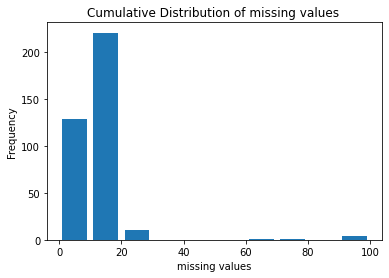

In [36]:
# calling the table of total missing values by variable of the azdias datasdet,
# we plot their count distribution by percentage 

missing_value_a['percent_missing'].plot(kind='hist',bins=[0,10,20,30,40,50,60,70,80,90,100],rwidth=0.8)
plt.title('Cumulative Distribution of missing values ')
plt.xlabel("missing values")

Text(0, 0.5, 'Frecuency')

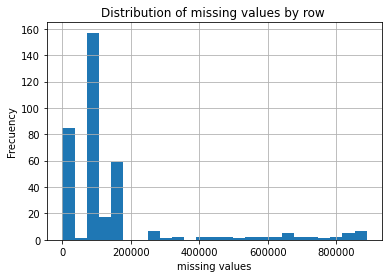

In [37]:
# counting distribution plot by number of columns with missing values 

col_na = azdias.shape[0] - azdias.count()
col_na.hist(bins=25);
plt.title('Distribution of missing values by row ')
plt.xlabel("missing values")
plt.ylabel("Frecuency")

We need to decide the threshold to eleiminate the variables that have nulls or none as values. 

In [38]:
# testing: if we drop X missing values 

#azdias_test1 = azdias
#azdias_test2 = azdias
azdias_test3 = azdias

In [ ]:
# if we remove columns which have > 200000 missing values
cols_no_mis1 = azdias_test1.shape[0] - azdias_test1.count()
cols_to_drop1 = azdias_test1.columns[cols_no_mis1 > 200000]
print(cols_to_drop1)
azdias_test1.drop(cols_to_drop1, axis=1, inplace = True)
azdias_test1.shape
#(891221, 319)
"""
variables to drop:
'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ'
"""

If we drop more than 200000 missing values, we get 891221 rows and 319 variables.
In other words, we would deleting 13% of the total variables (319/366)

In [ ]:
# if we remove columns which have > 400000 missing values
cols_no_mis2 = azdias_test2.shape[0] - azdias_test2.count()
cols_to_drop2 = azdias_test2.columns[cols_no_mis2 > 400000]
print(cols_to_drop2)
azdias_test2.drop(cols_to_drop2, axis=1, inplace = True)
azdias_test2.shape
#(891221, 330)
"""
variables:
'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'

"""

If we drop more than 400000, we get 891221 rows and 330 variables.
In other words, we would deleting 10% of the total variables (330/366).

In [39]:
# if we remove columns which have > 600000 missing values
cols_no_mis3 = azdias_test3.shape[0] - azdias_test3.count()
cols_to_drop3 = azdias_test3.columns[cols_no_mis3 > 600000]
#print(cols_to_drop3)
azdias_test3.drop(cols_to_drop3, axis=1, inplace = True)
#azdias_test3.shape
#(891221, 340)

"""
variables to drop: 
'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG3', 'KBA05_ANTG4', 'TITEL_KZ'
"""

azdias = azdias_test3

And, if we drop more than 600000, we get 891221 rows and 340 variables.
In other words, we would deleting 7% of the total variables (340/366)

We decide to get most of the variables for better insights, so we opted to remove columns which have > 600000 missing values.

And what about if we drop the rows with an percetange of null values...

In [40]:
# columnn of missing data per row

azdias['missing_values_rows']= azdias.shape[1] - azdias.count(axis = 1)

# generating descriptive statistics on number of missing rows
azdias.missing_values_rows.describe()

count    891221.000000
mean         39.352006
std          75.531338
min           0.000000
25%           4.000000
50%           9.000000
75%          19.000000
max         260.000000
Name: missing_values_rows, dtype: float64

Text(0, 0.5, 'missing values')

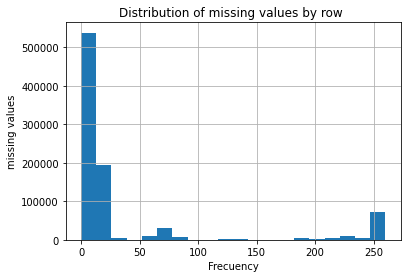

In [41]:
# histogram plot of number of missing values by row 

azdias['missing_values_rows'].hist(bins=20)
plt.title('Distribution of missing values by row ')
plt.xlabel("Frecuency")
plt.ylabel("missing values")

In [42]:
# removing the variable 

del azdias['missing_values_rows']

# removing rows which contain more than 50 missing values per row
null_rows = azdias.shape[1] - azdias.count(axis = 1)
rows_droped = azdias.index[null_rows> 50]
azdias.drop(rows_droped, axis=0, inplace = True)
azdias.shape

(737288, 340)

With this reduction, we obtain 737288 columns and 340 columns. We reduced 17.3%  (737288/891221) of rows for this section.  

## Work with customers dataset

In [43]:
# applying fiilna method 'ffill' to the attribute column 

feat_info_2= ind_levels['Attribute'].fillna(method='ffill')
ind_levels['Attribute'] = feat_info_2
ind_levels.head(10)

Information level              Attribute  \
0               NaN               AGER_TYP   
1            Person   ALTERSKATEGORIE_GROB   
2               NaN              ANREDE_KZ   
3               NaN          CJT_GESAMTTYP   
4               NaN      FINANZ_MINIMALIST   
5               NaN          FINANZ_SPARER   
6               NaN       FINANZ_VORSORGER   
7               NaN         FINANZ_ANLEGER   
8               NaN  FINANZ_UNAUFFAELLIGER   
9               NaN       FINANZ_HAUSBAUER   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   
5                    financial typology: money saver   
6                    financial typology: be prepared   
7                       financial typology: investor   
8                   financial typology: unremarkable   
9    financial typology: main focus is the own house   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative househo...  
5                                                NaN  
6                                                NaN  
7                                                NaN  
8                                                NaN  
9                                                NaN

In [44]:
# converting to float values 
for col in customers.columns:
        if customers[col].dtype == np.int64:
            customers[col] =customers[col].astype(np.float64)
            
# converting missing value codes into NaNs, ...
for i in without_values['Attribute']:
    if i in customers.columns:
        na_map = without_values.loc[without_values['Attribute'] == i, 'missings/unknowns'].iloc[0]
        na_idx = customers.loc[:, i].isin(na_map)
        customers.loc[na_idx, i] = np.NaN
    else:
        continue

In [45]:
# these columns were the ones (in the azdias datasdet) that had > 600000 missing values

to_drop = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG3', 'KBA05_ANTG4', 'TITEL_KZ']

customers.drop(to_drop, axis=1, inplace = True)

In [46]:
# remove rows which have also >50 missing values
customers['missing_values_rows'] = customers.shape[1] - customers.count(axis = 1)

# generating descriptive statistics on number of missing rows
customers.missing_values_rows.describe()

count    191652.000000
mean         72.776120
std         108.407012
min           0.000000
25%           2.000000
50%           7.000000
75%         223.000000
max         260.000000
Name: missing_values_rows, dtype: float64

Text(0, 0.5, 'missing values')

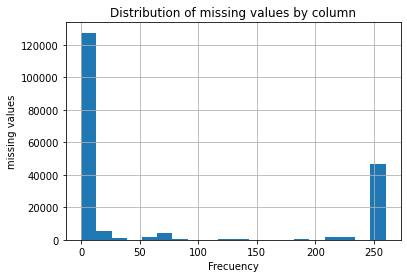

In [47]:
# histogram plot of number of missing values by row 
customers['missing_values_rows'].hist(bins=20)
plt.title('Distribution of missing values by column')
plt.xlabel("Frecuency")
plt.ylabel("missing values")

In [48]:
# removing the variable 
del customers['missing_values_rows']

# removing rows which contain more than 50 missing values per row
null_rows = customers.shape[1] - customers.count(axis = 1)
rows_droped = customers.index[null_rows > 50]
customers.drop(rows_droped, axis=0, inplace = True)
customers.shape

(134246, 340)

So once we have cleaned the data, we get 134246(- 30%) rows, and 340 (-8%)columns 

## Feature Encoding

## Azdias Dataset

It is important to encode all the data in order to work them in the unsupervised and supervised models. As we have seen, almost 97% of the data is integer type or float type, and just 3%  or less is categorical. So it would be easy encode the data. 

In [49]:
#creating a list of categorical values 
cat_azdias = list(object_vars_az.columns)

But we need to know more about the type of categorical: ordinal, binary, multi-level, nominal. 
So, we list them in order by value. 

In [50]:
# print vlaue counts of each categorical value
#for value in cat_azdias:
#    if value in azdias.columns:
#        print(pd.DataFrame(azdias[value].value_counts()), '\n')

#table of unique values for categorical variable 
object_list_vars_az = [i for i in azdias.columns if azdias.dtypes[i]=='object']
object_vars_az = customers[object_list_vars_az]
object_vars_az

CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0                  1A               1              13   
2                  5D               5              34   
3                  4C               4              24   
4                  7B               7              41   
5                  5D               5              34   
...               ...             ...             ...   
191647             1C               1              14   
191648             5B               5              32   
191649             4D               4              24   
191650             4C               4              24   
191651             5C               5              33   

       D19_LETZTER_KAUF_BRANCHE        EINGEFUEGT_AM OST_WEST_KZ  
0                 D19_UNBEKANNT  1992-02-12 00:00:00           W  
2                 D19_UNBEKANNT  1992-02-10 00:00:00           W  
3        D19_NAHRUNGSERGAENZUNG  1992-02-10 00:00:00           W  
4                    D19_SCHUHE  1992-02-12 00:00:00           W  
5                   D19_BUCH_CD  1992-02-10 00:00:00           W  
...                         ...                  ...         ...  
191647          D19_BANKEN_REST  1992-02-10 00:00:00           W  
191648            D19_UNBEKANNT  1997-03-06 00:00:00           W  
191649              D19_TECHNIK  1992-02-10 00:00:00           W  
191650          D19_BANKEN_REST  1992-02-10 00:00:00           W  
191651               D19_SCHUHE  1992-02-12 00:00:00           W  

[134246 rows x 6 columns]

In [51]:
# value counts of the azdias variables 

for value in cat_azdias:
    if value in azdias.columns:
        print(pd.DataFrame(azdias[value].value_counts()), '\n')

    CAMEO_DEU_2015
6B           54006
8A           50776
4C           43988
2D           32906
7A           32630
3C           32565
3D           32176
8B           31262
4A           30254
8C           30147
9D           26746
9B           25888
7B           22921
9C           22919
9A           20057
2C           17742
8D           16675
6E           15598
5D           14071
2B           14042
6C           13868
2A           11921
1D           11457
1A           10167
5A            9721
5B            9691
5C            9050
4B            8284
7C            8127
4D            8051
6A            6416
3A            5871
6D            5756
3B            5709
6F            5048
4E            5005
1E            4783
7D            4431
7E            4375
1C            4012
5F            3939
9E            3841
1B            3815
5E            3241
XX             284 

     CAMEO_DEUG_2015
8              74754
6              58203
9              57473
4              55290
8.0            5410

Note:
* for the 'CAMEO_DEU_2015' variable, we need to know more about this 'multi-level' variable... 
* for the 'EINGEFUEGT_AM' variable, seems to be a date value. 
* for the 'CAMEO_DEUG_2015' variable, seems to have symbol "x"
* for the 'CAMEO_INTL_2015' variable, seems to have symbol "XX"
* for the 'D19_LETZTER_KAUF_BRANCHE' variable, we need to know more about this variabel...
* for the 'OST_WEST_KZ' variable, seems to be binary (W,O)

So we decided to remove: 'CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', for simplicity. 

In [52]:
# removing this vars for simplicity 

to_drop = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
azdias.drop(to_drop, axis=1, inplace = True)
azdias.shape

(737288, 335)

In [53]:
# reencoding the binary variable 

azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

## Customers dataset

In [54]:
# also reencodeding the variable 

customers['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [55]:
# removing variables 

to_drop = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    
customers.drop(to_drop, axis=1, inplace = True)

In [56]:
# verifying the proportions, again once we cleaned the datasets

azdias_clean = azdias.columns
custom_clean = customers.columns

common_cols_dias_customers_2 = azdias_clean.intersection(custom_clean)
dias_not_customers_2 = azdias_clean.difference(custom_clean)
customers_not_dias_2 = custom_clean.difference(azdias_clean)

print("New azdias proportions: ", azdias.shape, '\n')
print("New customers dataset proportions: ", customers.shape, '\n')
print("These are the common columns between cleaned dias and customers datasets:", len(common_cols_dias_customers_2), '\n')
print("These are the uncommon columns between dias and customers cleaned datasets:", len(dias_not_customers_2), '\n')
print("These are the uncommon columns between customers and dias:", len(customers_not_dias_2), '\n')
print("The uncommon columns between customers and dias are:\n",', '.join(list(customers_not_dias_2)))

New azdias proportions:  (737288, 335) 

New customers dataset proportions:  (134246, 335) 

These are the common columns between cleaned dias and customers datasets: 335 

These are the uncommon columns between dias and customers cleaned datasets: 0 

These are the uncommon columns between customers and dias: 0 

The uncommon columns between customers and dias are:
 


Once we have the same proportions as azdias dataset, we can move to the next step.

## Feature Scaling

In [57]:
# which one to choose standard scaler, min-max scaling, or robust sacaling? in order scale the general population
# demographics data and customers data

#StandardScaler, if our data follows a normal distribution....
scaler = StandardScaler()

Before scaling, we need to know more about the skewness of our data and of course, the kurtosis in order to apply a scaler. Both measures are important to knoe about the symmetry of the data and the pointedness of the peaks in the distribution curves of the data.

### Kurtosis and skewness 

We can implement skew (measures of asymmetry of a distribution) and  kurtosis ( is one of the two measures that quantify shape of a distribution. ) method to know the dataset follows a normal distribution.

For skew method:

* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
* If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed.
* If the skewness is less than -1 or greater than 1, the data are highly skewed.

For kurtosis method:

A leptokurtic distribution has a Kurtosis value greater than 0, a normal distribution or a mesokurtic distribution has a Kurtosis value of 0 and a Platykurtic distribution has a Kurtosis value smaller than 0.

* High kurtosis in a data set is an indicator that data has heavy outliers.
* Low kurtosis in a data set is an indicator that data has lack of outliers.

In [58]:
# skew method 

azdias_skew = pd.DataFrame(azdias.skew())
azdias_skew.rename(columns={0: 'skew'}, inplace=True)
azdias_skew_1 = azdias_skew.loc[(azdias_skew['skew'] >= -0.5) & (azdias_skew['skew'] <= 0.5)]
azdias_skew_2 = azdias_skew.loc[(azdias_skew['skew'] >= -1) & (azdias_skew['skew'] < -0.5)]
azdias_skew_2_1 = azdias_skew.loc[(azdias_skew['skew'] > 0.5) & (azdias_skew['skew'] <= 1)]
azdias_skew_3 = azdias_skew.loc[(azdias_skew['skew'] < -1) | (azdias_skew['skew'] > 1)]
azdias_skew_1.shape, azdias_skew_2.shape, azdias_skew_2_1.shape, azdias_skew_3.shape

((241, 1), (5, 1), (22, 1), (67, 1))

We got that, for azdias dataset : 

* 72% of our data is fairly symmetrical.
* 8% of our data is moderately skewed.
* 20% of our data is highly skewed. 

In [63]:
# kurtosis method
azdias_kur = pd.DataFrame(azdias.kurtosis())
azdias_kur.rename(columns={0: 'kurtosis'}, inplace=True)
azdias_kur_1 = azdias_kur.loc[(azdias_kur['kurtosis'] == 0)]
azdias_kur_2 = azdias_kur.loc[(azdias_kur['kurtosis'] >= -0.1) & (azdias_kur['kurtosis'] <= 0.1)]
azdias_kur_2 = azdias_kur_2.loc[(azdias_kur['kurtosis'] != 0)]
azdias_kur_3 = azdias_kur.loc[(azdias_kur['kurtosis'] > 0.5)]
azdias_kur_4 = azdias_kur.loc[(azdias_kur['kurtosis'] < -0.5) ]
azdias_kur_1.shape, azdias_kur_2.shape, azdias_kur_3.shape, azdias_kur_4.shape

((0, 1), (11, 1), (58, 1), (160, 1))

We got that, for azdias dataset : 

*  0% of out data follows a normal distribution or a mesokurtic distribution. 
* 35% of our data follows almost a normal distribution or a mesokurtic distribution..
* 17% of our data follows a Leptokurtic distribution (>0.5).
* 48% of our data follows a Platykurtic distribution (<-0.5).

In [59]:
# skew method 

customers_skew = pd.DataFrame(customers.skew())
customers_skew.rename(columns={0: 'skew'}, inplace=True)
customers_skew_1 = customers_skew.loc[(customers_skew['skew'] >= -0.5) & (customers_skew['skew'] <= 0.5)]
customers_skew_2 = customers_skew.loc[(customers_skew['skew'] >= -1) & (customers_skew['skew'] < -0.5)]
customers_skew_2_1 = customers_skew.loc[(customers_skew['skew'] > 0.5) & (customers_skew['skew'] <= 1)]
customers_skew_3 = customers_skew.loc[(customers_skew['skew'] < -1) | (customers_skew['skew'] > 1)]
customers_skew_1.shape, customers_skew_2.shape, customers_skew_2_1.shape, customers_skew_3.shape

((214, 1), (17, 1), (28, 1), (76, 1))

We got that, for customers dataset: 

* 64% of our data is fairly symmetrical.
* 13.5% of our data is moderately skewed.
* 22.5% of our data is highly skewed. 

In [60]:
# kurtosis method
cus_kur = pd.DataFrame(customers.kurtosis())
cus_kur.rename(columns={0: 'kurtosis'}, inplace=True)
cus_kur_1 = cus_kur.loc[(cus_kur['kurtosis'] == 0)]
cus_kur_2 = cus_kur.loc[(cus_kur['kurtosis'] >= -0.1) & (cus_kur['kurtosis'] <= 0.1)]
cus_kur_2 = cus_kur_2.loc[(cus_kur['kurtosis'] != 0)]
cus_kur_3 = cus_kur.loc[(cus_kur['kurtosis'] > 0.1)]
cus_kur_4 = cus_kur.loc[(cus_kur['kurtosis'] < -0.1) ]
cus_kur_1.shape, cus_kur_2.shape, cus_kur_3.shape, cus_kur_4.shape

((0, 1), (28, 1), (83, 1), (224, 1))

We got that, for customers dataset: 

*  0% of out data follows a normal distribution or a mesokurtic distribution. 
* 8.5% of our data follows almost a normal distribution or a mesokurtic distribution..
* 24.7% of our data follows a Leptokurtic distribution (>0.5).
* 66.8% of our data follows a Platykurtic distribution (<-0.5).

With this result, we could apply StanScaler which is helpful because our features are almost normally distributed.

## Feature Imputation

In [61]:
# and the missing values?
# for simplicity we repalce null values with the mean 

imp = SimpleImputer(missing_values=np.NaN)

azd = pd.DataFrame(imp.fit_transform(azdias))
azd.columns = azdias.columns
azd.index = azdias.index

cust= pd.DataFrame(imp.fit_transform(customers))
cust.columns = customers.columns
cust.index = customers.index

We prefer to impute the missing values with the mean, this method is not the best ideal because out model could fall in bias and add more variance. It would be fine to know more about whye there are missing values.

In [62]:
# applying standScaler to the data 

azdias_standS =  pd.DataFrame(scaler.fit_transform(azd), columns = azd.columns)
customers_standS = pd.DataFrame(scaler.transform(cust), columns = cust.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## PCA for Dimensionality Reduction

* In this step we apply the PCA algorithm, in order to find the vectors with the maximum variace in all the dataset.

* According to Wikipedia, PCA is a statistical procedure that uses an orthogonal transformation to convert a set of
  observations of possibly correlated variables (entities each of which takes on various numerical values) into       aset of values of linearly uncorrelated variables called principal components.

* PCA class depends only upon the feature set and not the label data, so to start, we dont set any parameters to     test it without them. 

* We need to analize the rartio of variance of each principal component also the cumulative variance. 

* Once we got the results, we can plot the sequential values. 

* We need to choose the right number of components for de PCA, then fit it again. 

* We also can use cumulative variance plot to spot the best number of components to keep at 'N' percent of variance.  We are able to maintain efficient number of components within the needed amount to run clustering.

In [64]:
# setting pca 
pca = PCA().fit(azdias_standS)
new_df = pca.transform(azdias_standS)
var_exp = pca.explained_variance_ratio_

We can use  screen plots to show the number of components on the X-axis against the proportion of the variance explained on the Y-axis.

An important thing to consider is how we choose the number of principal components, what we need is do is to reduce our dataset and plot the variance explained by them. For each subsequent principal component we will add the variance it explains plus all of the variance explained by preceding principal components.

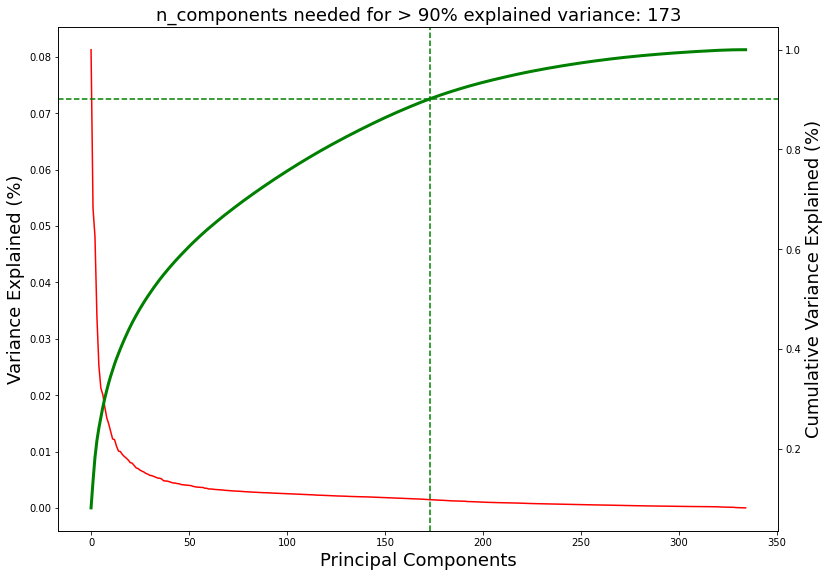

In [65]:
# number of components required to maintain 90% of variance:

n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.90)[0]+1)
n_components

# plot variance and cumulative variance 
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_axes([0,0,1,1],True)
ax2 = ax1.twinx()
ax1.plot(pca.explained_variance_ratio_, label='Variance', color = 'red')
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'Green', linewidth=3);
ax1.set_xlabel("Principal Components", fontsize=18)
ax1.set_ylabel("Variance Explained (%)", fontsize=18)
ax1.set_title('n_components needed for > 90% explained variance: {}'.format(n_components), fontsize=18);
ax1.axvline(n_components, linestyle='dashed', color='green')
ax2.set_ylabel("Cumulative Variance Explained (%)", fontsize=18)
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='green')

Choosing the number of components is related to the amount of variance that is explained. Thus, we can only decide after fitting and view the components with their explained variance ratios.

As machine learning engineers, we need to assume , that our requirement is that 90% of the variance must be explained in the PCA transformed data, for this case 173 features.

In [66]:
# applying the requirement of 90% variance for the 173 features

pca = PCA(173)
pca_fit = pca.fit(azdias_standS)
new_df = pca_fit.transform(azdias_standS)
var_exp = pca_fit.explained_variance_ratio_

So this level of cumulative variance is explained by including 173 components.
We choose these components which explain 90% of the variance.

### What  the principal components tell us about the data?

The weights of the variables  could help us to determine the position and the relationship between them. For example, if the weight is far from zero, the more the principal component is in the same direction of the feature. If 2 features have large weights in the same side (+/-), then increases in one are associated with increases in the other feature. In the contrary, features with different signs can show negative correlation. 

We could calculate the weights and their direct features in order to get a deeper understanding.
Also, we could test with "N" principal components, to know the relationships with the features and compare them. Do they differ or not from the fetures and the weights?, what type of features could appear for the corresponding interpretations.

In [67]:
# 1 Pricipal components 

# the number of components to 1 

# calculate the explained vairance 
dimensions = dimensions = ['dimension: {}'.format(i) for i in range(1,len(pca.components_)+1)]  
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 3), columns = ['Explained_variance'])
variance_ratios.index = dimensions

#calculate the weights 

weights_df = pd.DataFrame(pca.components_, columns=list(azdias_standS.columns))

# join the tables 

table_variance_weights = variance_ratios.join(weights_df.set_index(variance_ratios.index))
table_variance_weights #.iloc[:77]

Explained_variance       LNR  AKT_DAT_KL  ALTER_HH  \
dimension: 1                 0.081 -0.027005    0.062638 -0.002647   
dimension: 2                 0.053  0.083183    0.012746 -0.006047   
dimension: 3                 0.048  0.018930    0.037003  0.173698   
dimension: 4                 0.034 -0.055027   -0.103865  0.023759   
dimension: 5                 0.025 -0.122690    0.034115  0.003232   
dimension: 6                 0.021 -0.011630   -0.013320 -0.002720   
dimension: 7                 0.020  0.014257    0.006062 -0.000956   
dimension: 8                 0.018  0.020604    0.013871  0.001721   
dimension: 9                 0.016  0.091104   -0.016717 -0.002615   
dimension: 10                0.015  0.019752   -0.000778  0.005247   
dimension: 11                0.014 -0.017778   -0.004182 -0.003913   
dimension: 12                0.012  0.013479    0.014138 -0.027979   
dimension: 13                0.012 -0.035773    0.011485 -0.009875   
dimension: 14                0.011 -0.092136   -0.005736 -0.005846   
dimension: 15                0.010  0.054118   -0.048755 -0.016219   
dimension: 16                0.010 -0.015052   -0.055529 -0.031025   
dimension: 17                0.009 -0.040043    0.051113  0.030059   
dimension: 18                0.009  0.034905    0.094829  0.053186   
dimension: 19                0.009  0.019378    0.051661  0.009666   
dimension: 20                0.008 -0.066390   -0.030823 -0.004395   
dimension: 21                0.008 -0.048079    0.011625  0.012001   
dimension: 22                0.008 -0.061832    0.016843 -0.000162   
dimension: 23                0.008 -0.014536    0.036287 -0.102263   
dimension: 24                0.007 -0.019139    0.007083  0.019839   
dimension: 25                0.007  0.004444    0.031813  0.022195   
dimension: 26                0.007  0.002961   -0.020245 -0.021999   
dimension: 27                0.007  0.039080    0.020686  0.061491   
dimension: 28                0.006  0.020965   -0.115596 -0.108990   
dimension: 29                0.006  0.004217    0.046069  0.026504   
dimension: 30                0.006 -0.002918   -0.001966 -0.012262   
dimension: 31                0.006 -0.006782    0.015075  0.014976   
dimension: 32                0.006 -0.041695   -0.016468 -0.002228   
dimension: 33                0.006 -0.023163    0.026405  0.033370   
dimension: 34                0.005 -0.007005   -0.000457 -0.044029   
dimension: 35                0.005  0.018337    0.015148  0.063617   
dimension: 36                0.005 -0.032029    0.016080  0.029397   
dimension: 37                0.005  0.034620    0.057505  0.037664   
dimension: 38                0.005  0.025019   -0.052163 -0.048488   
dimension: 39                0.005  0.023528    0.008975  0.002815   
dimension: 40                0.005  0.025756    0.045637 -0.007227   
dimension: 41                0.005 -0.042996    0.122093  0.054847   
dimension: 42                0.005 -0.021180   -0.076844 -0.033854   
dimension: 43                0.004 -0.028243   -0.010965  0.010068   
dimension: 44                0.004  0.113958   -0.012511  0.025647   
dimension: 45                0.004  0.043019    0.016563  0.021042   
dimension: 46                0.004  0.030288   -0.004463  0.006888   
dimension: 47                0.004  0.067144    0.016974 -0.019509   
dimension: 48                0.004  0.016508    0.020062 -0.004040   
dimension: 49                0.004  0.024361    0.030069 -0.052319   
dimension: 50                0.004 -0.005623   -0.012104  0.003658   
dimension: 51                0.004 -0.017952    0.016242 -0.008257   
dimension: 52                0.004  0.009959    0.003013  0.039423   
dimension: 53                0.004  0.043352   -0.027970 -0.004744   
dimension: 54                0.004  0.013097   -0.013107 -0.021629   
dimension: 55                0.004  0.027455    0.020011  0.016198   
dimension: 56                0.004 -0.037794    0.020370  0.006006   
dimension: 57             

[Text(0, 0, 'MOBI_REGIO'),
 Text(1, 0, 'KBA13_ANTG1'),
 Text(2, 0, 'PLZ8_ANTG1'),
 Text(3, 0, 'LP_STATUS_FEIN'),
 Text(4, 0, 'LP_STATUS_GROB'),
 Text(5, 0, 'MOBI_RASTER'),
 Text(6, 0, 'KBA05_AUTOQUOT'),
 Text(7, 0, 'KBA13_AUTOQUOTE'),
 Text(8, 0, 'KBA05_GBZ'),
 Text(9, 0, 'FINANZ_MINIMALIST'),
 Text(10, 0, 'GEMEINDETYP'),
 Text(11, 0, 'KBA13_GBZ'),
 Text(12, 0, 'PLZ8_GBZ'),
 Text(13, 0, 'KBA05_ANHANG'),
 Text(14, 0, 'KBA13_ALTERHALTER_60'),
 Text(15, 0, 'LP_LEBENSPHASE_FEIN'),
 Text(16, 0, 'KONSUMNAEHE'),
 Text(17, 0, 'KBA13_HALTER_55'),
 Text(18, 0, 'INNENSTADT'),
 Text(19, 0, 'LP_LEBENSPHASE_GROB'),
 Text(20, 0, 'KBA13_HALTER_50'),
 Text(21, 0, 'KBA05_KRSAQUOT'),
 Text(22, 0, 'FIRMENDICHTE'),
 Text(23, 0, 'KBA13_KRSAQUOT'),
 Text(24, 0, 'KBA13_SEG_GELAENDEWAGEN'),
 Text(25, 0, 'KBA05_MOTRAD'),
 Text(26, 0, 'KBA13_HALTER_60'),
 Text(27, 0, 'ANZ_PERSONEN'),
 Text(28, 0, 'LP_FAMILIE_GROB'),
 Text(29, 0, 'LP_FAMILIE_FEIN'),
 Text(30, 0, 'KBA05_ANTG1'),
 Text(31, 0, 'GREEN_AVANTGARDE'),
 

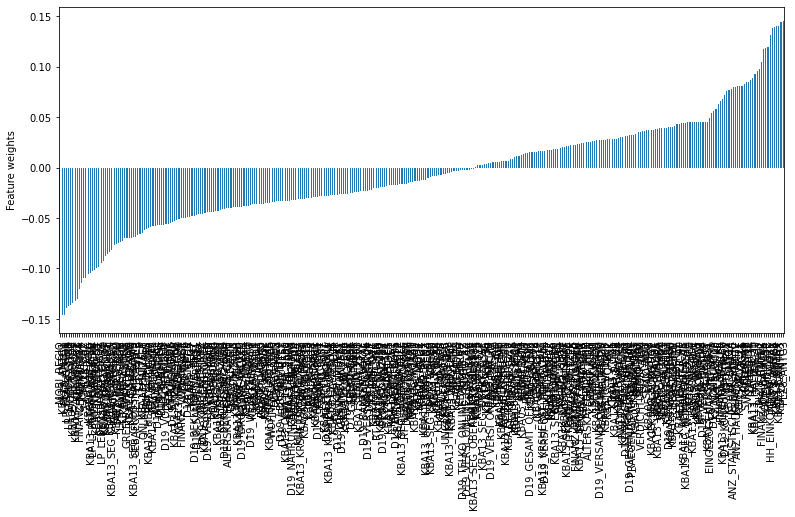

In [68]:
# pca components
components_ = pd.DataFrame(np.round(pca.components_, 3), columns = azdias_standS.keys())
components_.index = dimensions

# bar plot of feature weights  
fig, ax = plt.subplots(figsize = (13,6))

components_.iloc[1-1, :].sort_values().plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
ax.set_xticklabels(components_.iloc[1-1, :].sort_values().index, rotation=90)

Text(0, 0.5, 'Feature weights')

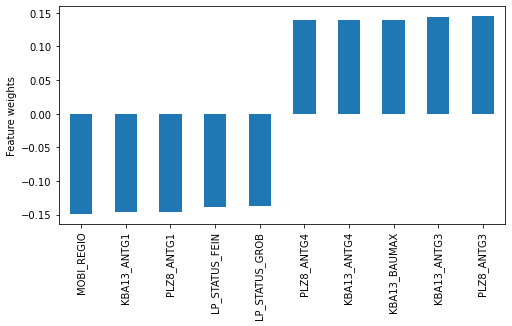

In [69]:
# bar plot 
fig, ax = plt.subplots(figsize = (8,4))

# plot the feature weights as a function of the components
components_.iloc[1-1, :].sort_values().iloc[[0, 1, 2, 3, 4, -5,-4, -3, -2, -1]].plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
#ax.set_xticks(range(-3,4))
#ax.set_xticklabels(components_.iloc[1-1, :].sort_values().index, rotation=90)

If we dont change the number of component, we got:

Last 5 columns

* 'MOBI_REGIO'
* 'KBA13_ANTG1'
* 'PLZ8_ANTG1'
* 'LP_STATUS_FEIN'
* 'LP_STATUS_GROB'
----------------

Top 5 columns 

* 'PLZ8_ANTG4'
* 'KBA13_ANTG4'
* 'KBA13_BAUMAX'
* 'KBA13_ANTG3'
* 'PLZ8_ANTG3'

In [70]:
# top 5 negative correlated features description 
some_values= ['MOBI_REGIO',
'KBA13_ANTG1',
'PLZ8_ANTG1',
'LP_STATUS_FEIN',
'LP_STATUS_GROB']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                              Description Value  \
1966  LP_STATUS_FEIN                       social status fine     1   
1967  LP_STATUS_FEIN                                      NaN     2   
1968  LP_STATUS_FEIN                                      NaN     3   
1969  LP_STATUS_FEIN                                      NaN     4   
1970  LP_STATUS_FEIN                                      NaN     5   
1971  LP_STATUS_FEIN                                      NaN     6   
1972  LP_STATUS_FEIN                                      NaN     7   
1973  LP_STATUS_FEIN                                      NaN     8   
1974  LP_STATUS_FEIN                                      NaN     9   
1975  LP_STATUS_FEIN                                      NaN    10   
1976  LP_STATUS_GROB                      social status rough     1   
1977  LP_STATUS_GROB                                      NaN     2   
1978  LP_STATUS_GROB                                      NaN     3   
1979  LP_STATUS_GROB                                      NaN     4   
1980  LP_STATUS_GROB                                      NaN     5   
1981  LP_STATUS_GROB                                      NaN     6   
1982  LP_STATUS_GROB                                      NaN     7   
1983  LP_STATUS_GROB                                      NaN     8   
1984  LP_STATUS_GROB                                      NaN     9   
1985  LP_STATUS_GROB                                      NaN    10   
1987      MOBI_REGIO                          moving patterns     1   
1988      MOBI_REGIO                                      NaN     2   
1989      MOBI_REGIO                                      NaN     3   
1990      MOBI_REGIO                                      NaN     4   
1991      MOBI_REGIO                                      NaN     5   
1992      MOBI_REGIO                                      NaN     6   
2016      PLZ8_ANTG1  number of 1-2 family houses in the PLZ8    -1   
2017      PLZ8_ANTG1                                      NaN     0   
2018      PLZ8_ANTG1                                      NaN     1   
2019      PLZ8_ANTG1                                      NaN     2   
2020      PLZ8_ANTG1                                      NaN     3   
2021      PLZ8_ANTG1                                      NaN     4   

                                    Meaning  
1966             typical low-income earners  
1967  orientationseeking low-income earners  
1968           aspiring low-income earners   
1969                              villagers  
1970       minimalistic high-income earners  
1971                    independant workers  
1972                title holder-households  
1973                        new houseowners  
1974                            houseowners  
1975                           top earners   
1976                     low-income earners  
1977                                    NaN  
1978                        average earners  
1979                                    NaN  
1980                                    NaN  
1981                           independants  
1982                                    NaN  
1983                            houseowners  
1984                                    NaN  
1985                           top earners   
1987                     very high mobility  
1988                          high mobility  
1989                        middle mobility  
1990                           low mobility  
1991                     very low mobility   
1992                                   none  
2016                                unknown  
2017                                   none  
2018                              low share  
2019                          average share  
2020                             high share  
2021                        very high share

In [71]:
# top 5 positive correlated features description 
some_values= ['PLZ8_ANTG4',
'KBA13_ANTG4',
'KBA13_BAUMAX',
'KBA13_ANTG3',
'PLZ8_ANTG3']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                               Description Value  \
2028  PLZ8_ANTG3  number of 6-10 family houses in the PLZ8    -1   
2029  PLZ8_ANTG3                                       NaN     0   
2030  PLZ8_ANTG3                                       NaN     1   
2031  PLZ8_ANTG3                                       NaN     2   
2032  PLZ8_ANTG3                                       NaN     3   
2033  PLZ8_ANTG4   number of >10 family houses in the PLZ8    -1   
2034  PLZ8_ANTG4                                       NaN     0   
2035  PLZ8_ANTG4                                       NaN     1   
2036  PLZ8_ANTG4                                       NaN     2   

            Meaning  
2028        unknown  
2029           none  
2030      low share  
2031  average share  
2032     high share  
2033        unknown  
2034           none  
2035      low share  
2036     high share

If we implement 1 component, we can observe that for the negative correlated features weights we got: 

* 'MOBI_REGIO',
* 'KBA13_ANTG1',
* 'PLZ8_ANTG1',
* 'LP_STATUS_FEIN',
* 'LP_STATUS_GROB'

They are related to social status fine, social status rough, moving patterns and number of 1-2 family houses in the PLZ8, and one with unknown description. 

And for positive correlated feature weights we got:

* 'PLZ8_ANTG4',
* 'KBA13_ANTG4',
* 'KBA13_BAUMAX',
* 'KBA13_ANTG3',
* 'PLZ8_ANTG3'

They are related to number of 6-10 family houses in the PLZ8, number of >10 family houses in the PLZ8, the others have unknown description. 

Note: 
The lowest the weight of an attribute the less relevant it is considered to be, these might relate to a negative relationships; and contrary, the highest the weight of an attribute the more relevant it is considered to be, these could be relate to positive relationships. 

[Text(0, 0, 'KBA13_SITZE_5'),
 Text(1, 0, 'KBA13_SEG_KLEINWAGEN'),
 Text(2, 0, 'KBA13_KMH_140_210'),
 Text(3, 0, 'KBA13_HALTER_25'),
 Text(4, 0, 'KBA13_KMH_180'),
 Text(5, 0, 'KBA13_SEG_KOMPAKTKLASSE'),
 Text(6, 0, 'KBA13_HALTER_20'),
 Text(7, 0, 'KBA13_KW_0_60'),
 Text(8, 0, 'KBA13_HERST_ASIEN'),
 Text(9, 0, 'KBA13_HERST_FORD_OPEL'),
 Text(10, 0, 'KBA13_SEG_KLEINST'),
 Text(11, 0, 'KBA13_FAB_ASIEN'),
 Text(12, 0, 'KBA13_ALTERHALTER_60'),
 Text(13, 0, 'KBA05_KW1'),
 Text(14, 0, 'KBA13_ALTERHALTER_30'),
 Text(15, 0, 'KBA05_CCM1'),
 Text(16, 0, 'KBA13_KRSHERST_FORD_OPEL'),
 Text(17, 0, 'KBA13_CCM_1400'),
 Text(18, 0, 'KKK'),
 Text(19, 0, 'KBA05_MAXHERST'),
 Text(20, 0, 'KBA13_OPEL'),
 Text(21, 0, 'BALLRAUM'),
 Text(22, 0, 'FIRMENDICHTE'),
 Text(23, 0, 'KONSUMNAEHE'),
 Text(24, 0, 'GEMEINDETYP'),
 Text(25, 0, 'WOHNLAGE'),
 Text(26, 0, 'KBA13_FORD'),
 Text(27, 0, 'KBA13_HALTER_50'),
 Text(28, 0, 'KBA13_HALTER_55'),
 Text(29, 0, 'KBA05_SEG3'),
 Text(30, 0, 'KBA13_NISSAN'),
 Text(31, 0, 'KBA

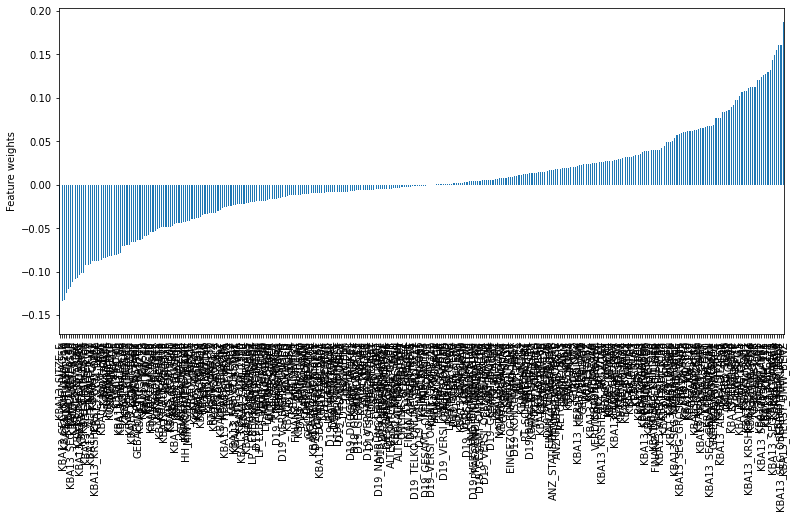

In [72]:
# 2 Pricipal components 
# change the number of components to 2 

# pca components
components_2 = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_standS.keys())
components_2.index = dimensions

# bar plot of feature weights  
fig, ax = plt.subplots(figsize = (13,6))

components_2.iloc[2-1, :].sort_values().plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
ax.set_xticklabels(components_2.iloc[2-1, :].sort_values().index, rotation=90)

Text(0, 0.5, 'Feature weights')

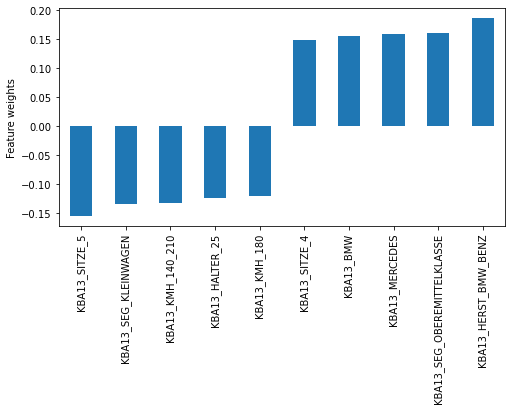

In [73]:
# bar plot 
fig, ax = plt.subplots(figsize = (8,4))

# plot the feature weights as a function of the components
components_2.iloc[2-1, :].sort_values().iloc[[0, 1, 2, 3, 4,-5,-4, -3, -2, -1]].plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
#ax.set_xticklabels(components_1.iloc[2-1, :].sort_values().index, rotation=90)

### Here we got:
Last 5 columns
* 'KB13_SITZE_5'
* 'KBA13_SEG_KLEINWAGEN'
* 'KBA13_KMH_140_210'
* 'KBA13_HALTER_25'
* 'KBA13_KMH_180'
---------------
TOP 5 columns 
* 'KBA13_SITZE_4'
* 'KBA13_BMW'
* 'KBA13_MERCEDES'
* 'KBA13_SEG_OBERMITTELKLASSE'
* 'KBA13_HERST_BMW_BENZ'

In [74]:
# top 5 negative correlated features description 
some_values= ['KB13_SITZE_5',
'KBA13_SEG_KLEINWAGEN',
'KBA13_KMH_140_210',
'KBA13_HALTER_25',
'KBA13_KMH_180']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                                        Description  \
1357       KBA13_HALTER_25  share of car owners between 21 and 25 within t...   
1358       KBA13_HALTER_25                                                NaN   
1359       KBA13_HALTER_25                                                NaN   
1360       KBA13_HALTER_25                                                NaN   
1361       KBA13_HALTER_25                                                NaN   
1362       KBA13_HALTER_25                                                NaN   
1363       KBA13_HALTER_25                                                NaN   
1483         KBA13_KMH_180  share of cars with max speed between 110 km/h ...   
1484         KBA13_KMH_180                                                NaN   
1485         KBA13_KMH_180                                                NaN   
1486         KBA13_KMH_180                                                NaN   
1487         KBA13_KMH_180                                                NaN   
1488         KBA13_KMH_180                                                NaN   
1489         KBA13_KMH_180                                                NaN   
1497     KBA13_KMH_140_210  share of cars with max speed between 140 and 2...   
1498     KBA13_KMH_140_210                                                NaN   
1499     KBA13_KMH_140_210                                                NaN   
1500     KBA13_KMH_140_210                                                NaN   
1501     KBA13_KMH_140_210                                                NaN   
1502     KBA13_KMH_140_210                                                NaN   
1503     KBA13_KMH_140_210                                                NaN   
1726  KBA13_SEG_KLEINWAGEN  share of small and very small cars (Ford Fiest...   
1727  KBA13_SEG_KLEINWAGEN                                                NaN   
1728  KBA13_SEG_KLEINWAGEN                                                NaN   
1729  KBA13_SEG_KLEINWAGEN                                                NaN   
1730  KBA13_SEG_KLEINWAGEN                                                NaN   
1731  KBA13_SEG_KLEINWAGEN                                                NaN   
1732  KBA13_SEG_KLEINWAGEN                                                NaN   

     Value    Meaning  
1357    -1    unknown  
1358     0       none  
1359     1   very low  
1360     2        low  
1361     3    average  
1362     4       high  
1363     5  very high  
1483    -1    unknown  
1484     0       none  
1485     1   very low  
1486     2        low  
1487     3    average  
1488     4       high  
1489     5  very high  
1497    -1    unknown  
1498     0       none  
1499     1   very low  
1500     2        low  
1501     3    average  
1502     4       high  
1503     5  very high  
1726    -1    unknown  
1727     0       none  
1728     1   very low  
1729     2        low  
1730     3    average  
1731     4       high  
1732     5  very high

In [75]:
# top 5 positive correlated features description 
some_values= ['KBA13_SITZE_4',
'KBA13_BMW',
'KBA13_MERCEDES',
'KBA13_SEG_OBERMITTELKLASSE',
'KBA13_HERST_BMW_BENZ']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                                        Description  \
1224             KBA13_BMW                       share of BMW within the PLZ8   
1225             KBA13_BMW                                                NaN   
1226             KBA13_BMW                                                NaN   
1227             KBA13_BMW                                                NaN   
1228             KBA13_BMW                                                NaN   
1229             KBA13_BMW                                                NaN   
1230             KBA13_BMW                                                NaN   
1441  KBA13_HERST_BMW_BENZ       share of BMW & Mercedes Benz within the PLZ8   
1442  KBA13_HERST_BMW_BENZ                                                NaN   
1443  KBA13_HERST_BMW_BENZ                                                NaN   
1444  KBA13_HERST_BMW_BENZ                                                NaN   
1445  KBA13_HERST_BMW_BENZ                                                NaN   
1446  KBA13_HERST_BMW_BENZ                                                NaN   
1447  KBA13_HERST_BMW_BENZ                                                NaN   
1664        KBA13_MERCEDES                  share of MERCEDES within the PLZ8   
1665        KBA13_MERCEDES                                                NaN   
1666        KBA13_MERCEDES                                                NaN   
1667        KBA13_MERCEDES                                                NaN   
1668        KBA13_MERCEDES                                                NaN   
1669        KBA13_MERCEDES                                                NaN   
1670        KBA13_MERCEDES                                                NaN   
1810         KBA13_SITZE_4  number of cars with less than 5 seats in the PLZ8   
1811         KBA13_SITZE_4                                                NaN   
1812         KBA13_SITZE_4                                                NaN   
1813         KBA13_SITZE_4                                                NaN   
1814         KBA13_SITZE_4                                                NaN   
1815         KBA13_SITZE_4                                                NaN   
1816         KBA13_SITZE_4                                                NaN   

     Value    Meaning  
1224    -1    unknown  
1225     0       none  
1226     1   very low  
1227     2        low  
1228     3    average  
1229     4       high  
1230     5  very high  
1441    -1    unknown  
1442     0       none  
1443     1   very low  
1444     2        low  
1445     3    average  
1446     4       high  
1447     5  very high  
1664    -1    unknown  
1665     0       none  
1666     1   very low  
1667     2        low  
1668     3    average  
1669     4       high  
1670     5  very high  
1810    -1    unknown  
1811     0       none  
1812     1   very low  
1813     2        low  
1814     3    average  
1815     4       high  
1816     5  very high

If we implement 2 components, we can observe that for the negative correlated features weights we got: 

* 'KB13_SITZE_5',
* 'KBA13_SEG_KLEINWAGEN',
* 'KBA13_KMH_140_210',
* 'KBA13_HALTER_25',
* 'KBA13_KMH_180'


They are related to share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8, share of cars with max speed between 140 and 210 km/h within the PLZ8, share of car owners between 21 and 25 within the PLZ8, share of cars with max speed between 110 km/h and 180km/h within the PLZ8 and one with unknown description. 

And for positive correlated feature weights we got:

* 'KBA13_SITZE_4',
* 'KBA13_BMW',
* 'KBA13_MERCEDES',
* 'KBA13_SEG_OBERMITTELKLASSE',
* 'KBA13_HERST_BMW_BENZ'


They are related to number of cars with less than 5 seats in the PLZ8, share of BMW within the PLZ8, share of MERCEDES within the PLZ8,share of BMW & Mercedes Benz within the PLZ8, an one with unknown description.  

[Text(0, 0, 'CJT_TYP_5'),
 Text(1, 0, 'FINANZ_VORSORGER'),
 Text(2, 0, 'CJT_TYP_4'),
 Text(3, 0, 'ALTERSKATEGORIE_GROB'),
 Text(4, 0, 'CJT_TYP_3'),
 Text(5, 0, 'CJT_TYP_6'),
 Text(6, 0, 'KOMBIALTER'),
 Text(7, 0, 'CJT_KATALOGNUTZER'),
 Text(8, 0, 'RETOURTYP_BK_S'),
 Text(9, 0, 'SEMIO_LUST'),
 Text(10, 0, 'W_KEIT_KIND_HH'),
 Text(11, 0, 'SEMIO_ERL'),
 Text(12, 0, 'FINANZ_MINIMALIST'),
 Text(13, 0, 'FINANZTYP'),
 Text(14, 0, 'VK_DHT4A'),
 Text(15, 0, 'D19_GESAMT_DATUM'),
 Text(16, 0, 'D19_VERSAND_DATUM'),
 Text(17, 0, 'WOHNDAUER_2008'),
 Text(18, 0, 'D19_KONSUMTYP'),
 Text(19, 0, 'D19_KONSUMTYP_MAX'),
 Text(20, 0, 'D19_VERSI_DATUM'),
 Text(21, 0, 'D19_GESAMT_ONLINE_DATUM'),
 Text(22, 0, 'FINANZ_HAUSBAUER'),
 Text(23, 0, 'D19_VERSAND_ONLINE_DATUM'),
 Text(24, 0, 'KBA05_ALTER4'),
 Text(25, 0, 'SHOPPER_TYP'),
 Text(26, 0, 'KBA05_MAXAH'),
 Text(27, 0, 'KK_KUNDENTYP'),
 Text(28, 0, 'KBA05_VORB0'),
 Text(29, 0, 'RT_SCHNAEPPCHEN'),
 Text(30, 0, 'VK_DISTANZ'),
 Text(31, 0, 'D19_SOZIALES'),
 Text

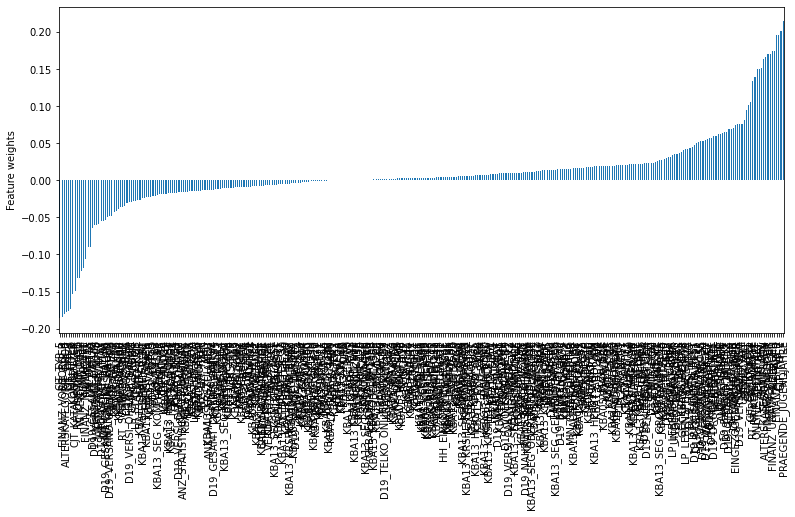

In [76]:
#  3 Pricipal components 
# change the number of components to 3

# pca components
components_3 = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_standS.keys())
components_3.index = dimensions

# bar plot of feature weights  
fig, ax = plt.subplots(figsize = (13,6))

components_3.iloc[3-1, :].sort_values().plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
ax.set_xticklabels(components_3.iloc[3-1, :].sort_values().index, rotation=90)

Text(0, 0.5, 'Feature weights')

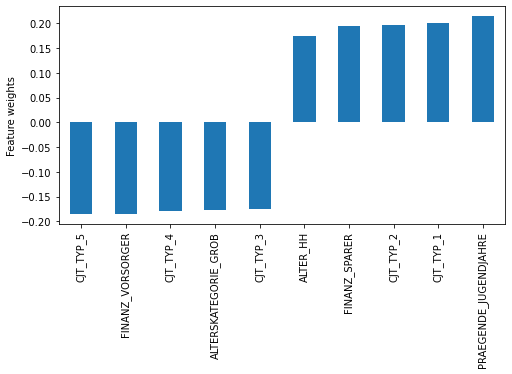

In [77]:
# bar plot 
fig, ax = plt.subplots(figsize = (8,4))

# plot the feature weights as a function of the components
components_3.iloc[3-1, :].sort_values().iloc[[0, 1, 2, 3, 4,-5,-4, -3, -2, -1]].plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
#ax.set_xticklabels(components_1.iloc[2-1, :].sort_values().index, rotation=90)

### Here we got:
Last 5 columns
* 'CJT_TYP_5'
* 'FINANZ_VORSORGER'
* 'CJT_TYP_4'
* 'ALTERSKATEGORIE_GROB'
* 'CJT_TYP_3'
---------------
TOP 5 columns 
* 'ALTER_HH'
* 'FINANZ_SPARER'
* 'CJT_TYP_2'
* 'CJT_TYP_1'
* 'PRAEGENDE_JUGENDJAHRE'

In [78]:
# top 5 negative correlated features
some_values= ['CJT_TYP_5',
'FINANZ_VORSORGER',
'CJT_TYP_4',
'ALTERSKATEGORIE_GROB',
'CJT_TYP_3']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                                   Description  \
5    ALTERSKATEGORIE_GROB  age classification through prename analysis    
6    ALTERSKATEGORIE_GROB                                           NaN   
7    ALTERSKATEGORIE_GROB                                           NaN   
8    ALTERSKATEGORIE_GROB                                           NaN   
9    ALTERSKATEGORIE_GROB                                           NaN   
10   ALTERSKATEGORIE_GROB                                           NaN   
691      FINANZ_VORSORGER               financial typology: be prepared   
692      FINANZ_VORSORGER                                           NaN   
693      FINANZ_VORSORGER                                           NaN   
694      FINANZ_VORSORGER                                           NaN   
695      FINANZ_VORSORGER                                           NaN   
696      FINANZ_VORSORGER                                           NaN   

     Value                Meaning  
5    -1, 0                unknown  
6        1             < 30 years  
7        2          30 - 45 years  
8        3          46 - 60 years  
9        4             > 60 years  
10       9  uniformly distributed  
691     -1                unknown  
692      1              very high  
693      2                   high  
694      3                average  
695      4                    low  
696      5               very low

In [79]:
# top 5 positive correlated features
some_values= ['ALTER_HH',
'FINANZ_SPARER',
'CJT_TYP_2',
'CJT_TYP_1',
'PRAEGENDE_JUGENDJAHRE']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute  \
11                 ALTER_HH   
12                 ALTER_HH   
13                 ALTER_HH   
14                 ALTER_HH   
15                 ALTER_HH   
16                 ALTER_HH   
17                 ALTER_HH   
18                 ALTER_HH   
19                 ALTER_HH   
20                 ALTER_HH   
21                 ALTER_HH   
22                 ALTER_HH   
23                 ALTER_HH   
24                 ALTER_HH   
25                 ALTER_HH   
26                 ALTER_HH   
27                 ALTER_HH   
28                 ALTER_HH   
29                 ALTER_HH   
30                 ALTER_HH   
31                 ALTER_HH   
32                 ALTER_HH   
679           FINANZ_SPARER   
680           FINANZ_SPARER   
681           FINANZ_SPARER   
682           FINANZ_SPARER   
683           FINANZ_SPARER   
684           FINANZ_SPARER   
2054  PRAEGENDE_JUGENDJAHRE   
2055  PRAEGENDE_JUGENDJAHRE   
2056  PRAEGENDE_JUGENDJAHRE   
2057  PRAEGENDE_JUGENDJAHRE   
2058  PRAEGENDE_JUGENDJAHRE   
2059  PRAEGENDE_JUGENDJAHRE   
2060  PRAEGENDE_JUGENDJAHRE   
2061  PRAEGENDE_JUGENDJAHRE   
2062  PRAEGENDE_JUGENDJAHRE   
2063  PRAEGENDE_JUGENDJAHRE   
2064  PRAEGENDE_JUGENDJAHRE   
2065  PRAEGENDE_JUGENDJAHRE   
2066  PRAEGENDE_JUGENDJAHRE   
2067  PRAEGENDE_JUGENDJAHRE   
2068  PRAEGENDE_JUGENDJAHRE   
2069  PRAEGENDE_JUGENDJAHRE   

                                            Description  Value  \
11                        main age within the household      0   
12                                                  NaN      1   
13                                                  NaN      2   
14                                                  NaN      3   
15                                                  NaN      4   
16                                                  NaN      5   
17                                                  NaN      6   
18                                                  NaN      7   
19                                                  NaN      8   
20                                                  NaN      9   
21                                                  NaN     10   
22                                                  NaN     11   
23                                                  NaN     12   
24                                                  NaN     13   
25                                                  NaN     14   
26                                                  NaN     15   
27                                                  NaN     16   
28                                                  NaN     17   
29                                                  NaN     18   
30                                                  NaN     19   
31                                                  NaN     20   
32                                                  NaN     21   
679                     financial typology: money saver     -1   
680                                                 NaN      1   
681                                                 NaN      2   
682                                                 NaN      3   
683                                                 NaN      4   
684                                                 NaN      5   
2054  dominating movement in the person's youth (ava...  -1, 0   
2055                                                NaN      1   
2056                                                NaN      2   
2057                                                NaN      3   
2058                                                NaN      4   
2059                                                NaN      5   
2060                                                NaN      6   
2061                                                NaN      7   
2062                                                NaN      8   
2063                                                NaN      9   
2064                                            

If we implement 3 components, we can observe that for the negative correlated features weights we got: 


They are related to age classification through prename analysis,financial typology: be prepared, the others have unknown desciptions. 

And for positive correlated feature wights we got: 

They are related to main age within the household, financial typology: money saver, dominating movement in the person's youth (avantgarde or mainstream), and the others have unknown descriptions. 

[Text(0, 0, 'KBA13_KW_0_60'),
 Text(1, 0, 'KBA13_BJ_2000'),
 Text(2, 0, 'OST_WEST_KZ'),
 Text(3, 0, 'KBA13_CCM_0_1400'),
 Text(4, 0, 'KBA13_KMH_180'),
 Text(5, 0, 'KBA13_KMH_140'),
 Text(6, 0, 'KBA13_KMH_0_140'),
 Text(7, 0, 'KBA13_SITZE_4'),
 Text(8, 0, 'KBA13_KW_40'),
 Text(9, 0, 'KBA13_CCM_1000'),
 Text(10, 0, 'KBA13_BJ_1999'),
 Text(11, 0, 'LNR'),
 Text(12, 0, 'KBA13_SEG_MINIWAGEN'),
 Text(13, 0, 'KBA13_VORB_3'),
 Text(14, 0, 'KBA13_VORB_2'),
 Text(15, 0, 'KBA13_KW_50'),
 Text(16, 0, 'KBA13_SITZE_6'),
 Text(17, 0, 'KBA13_CCM_1200'),
 Text(18, 0, 'KBA13_HALTER_45'),
 Text(19, 0, 'KBA13_FIAT'),
 Text(20, 0, 'KBA05_ZUL1'),
 Text(21, 0, 'KBA13_CCM_1400'),
 Text(22, 0, 'KBA05_VORB2'),
 Text(23, 0, 'KBA13_SEG_WOHNMOBILE'),
 Text(24, 0, 'KBA13_MOTOR'),
 Text(25, 0, 'KBA13_KRSSEG_KLEIN'),
 Text(26, 0, 'KBA13_KW_30'),
 Text(27, 0, 'FINANZ_VORSORGER'),
 Text(28, 0, 'KBA13_KW_60'),
 Text(29, 0, 'KBA13_SEG_KLEINST'),
 Text(30, 0, 'KBA13_KRSHERST_FORD_OPEL'),
 Text(31, 0, 'KBA13_ALTERHALTER_45'

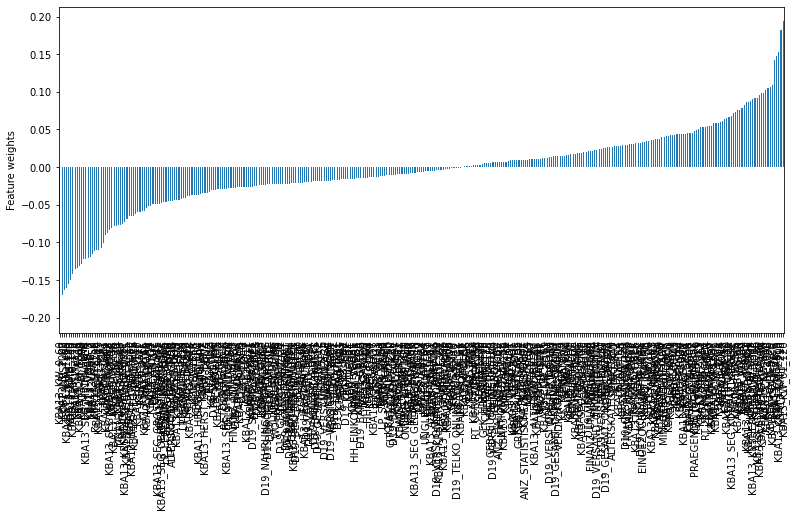

In [80]:
#  5 Pricipal components 
# change the number of components to 5

# pca components
components_5 = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_standS.keys())
components_5.index = dimensions

# bar plot of feature weights  
fig, ax = plt.subplots(figsize = (13,6))

components_5.iloc[5-1, :].sort_values().plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
ax.set_xticklabels(components_5.iloc[5-1, :].sort_values().index, rotation=90)

Text(0, 0.5, 'Feature weights')

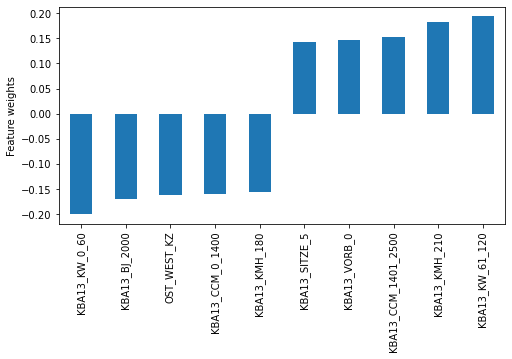

In [81]:
# bar plot 
fig, ax = plt.subplots(figsize = (8,4))

# plot the feature weights as a function of the components
components_5.iloc[5-1, :].sort_values().iloc[[0, 1, 2, 3, 4,-5,-4, -3, -2, -1]].plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
#ax.set_xticklabels(components_1.iloc[2-1, :].sort_values().index, rotation=90)

### Here we got:
Last 5 columns
* 'KBA13_KW_0_60'
* 'KBA13_BJ_2000'
* 'OST_WEST_KZ'
* 'KBA13_CCM_0_1400'
* 'KBA13_KMH_180'

---------------
TOP 5 columns 
* 'KBA13_SITZE_5'
* 'KBA13_VORB_0'
* 'KBA13_CCM_1401_2500'
* 'KBA13_KMH_210'
* 'KBA13_KW_61_120'

In [82]:
# top 5 negative correlated features
some_values= ['KBA13_KW_0_60',
'KBA13_BJ_2000',
'OST_WEST_KZ',
'KBA13_CCM_0_1400',
'KBA13_KMH_180']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                                        Description  \
1189     KBA13_BJ_2000  share of cars built between 2000 and 2003 with...   
1190     KBA13_BJ_2000                                                NaN   
1191     KBA13_BJ_2000                                                NaN   
1192     KBA13_BJ_2000                                                NaN   
1193     KBA13_BJ_2000                                                NaN   
1194     KBA13_BJ_2000                                                NaN   
1195     KBA13_BJ_2000                                                NaN   
1252  KBA13_CCM_0_1400  share of cars with less than 1400ccm within th...   
1253  KBA13_CCM_0_1400                                                NaN   
1254  KBA13_CCM_0_1400                                                NaN   
1255  KBA13_CCM_0_1400                                                NaN   
1256  KBA13_CCM_0_1400                                                NaN   
1257  KBA13_CCM_0_1400                                                NaN   
1258  KBA13_CCM_0_1400                                                NaN   
1483     KBA13_KMH_180  share of cars with max speed between 110 km/h ...   
1484     KBA13_KMH_180                                                NaN   
1485     KBA13_KMH_180                                                NaN   
1486     KBA13_KMH_180                                                NaN   
1487     KBA13_KMH_180                                                NaN   
1488     KBA13_KMH_180                                                NaN   
1489     KBA13_KMH_180                                                NaN   
1601     KBA13_KW_0_60      share of cars up to 60 KW engine power - PLZ8   
1602     KBA13_KW_0_60                                                NaN   
1603     KBA13_KW_0_60                                                NaN   
1604     KBA13_KW_0_60                                                NaN   
1605     KBA13_KW_0_60                                                NaN   
1606     KBA13_KW_0_60                                                NaN   
1607     KBA13_KW_0_60                                                NaN   
2013       OST_WEST_KZ                 flag indicating the former GDR/FRG   
2014       OST_WEST_KZ                                                NaN   
2015       OST_WEST_KZ                                                NaN   

     Value     Meaning  
1189    -1     unknown  
1190     0        none  
1191     1    very low  
1192     2         low  
1193     3     average  
1194     4        high  
1195     5   very high  
1252    -1     unknown  
1253     0        none  
1254     1    very low  
1255     2         low  
1256     3     average  
1257     4        high  
1258     5   very high  
1483    -1     unknown  
1484     0        none  
1485     1    very low  
1486     2         low  
1487     3     average  
1488     4        high  
1489     5   very high  
1601    -1     unknown  
1602     0        none  
1603     1    very low  
1604     2         low  
1605     3     average  
1606     4        high  
1607     5   very high  
2013    -1     unknown  
2014     O  East (GDR)  
2015     W  West (FRG)

In [83]:
# top 5 positive correlated features
some_values= ['KBA13_SITZE_5',
'KBA13_VORB_0',
'KBA13_CCM_1401_2500',
'KBA13_KMH_210',
'KBA13_KW_61_120']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                                        Description  \
1615  KBA13_KW_61_120  share of cars with an engine power between 61 ...   
1616  KBA13_KW_61_120                                                NaN   
1617  KBA13_KW_61_120                                                NaN   
1618  KBA13_KW_61_120                                                NaN   
1619  KBA13_KW_61_120                                                NaN   
1620  KBA13_KW_61_120                                                NaN   
1621  KBA13_KW_61_120                                                NaN   
1817    KBA13_SITZE_5            number of cars with 5 seats in the PLZ8   
1818    KBA13_SITZE_5                                                NaN   
1819    KBA13_SITZE_5                                                NaN   
1820    KBA13_SITZE_5                                                NaN   
1821    KBA13_SITZE_5                                                NaN   
1822    KBA13_SITZE_5                                                NaN   
1823    KBA13_SITZE_5                                                NaN   
1838     KBA13_VORB_0              share of cars with no preowner - PLZ8   
1839     KBA13_VORB_0                                                NaN   
1840     KBA13_VORB_0                                                NaN   
1841     KBA13_VORB_0                                                NaN   
1842     KBA13_VORB_0                                                NaN   
1843     KBA13_VORB_0                                                NaN   
1844     KBA13_VORB_0                                                NaN   

     Value    Meaning  
1615    -1    unknown  
1616     0       none  
1617     1   very low  
1618     2        low  
1619     3    average  
1620     4       high  
1621     5  very high  
1817    -1    unknown  
1818     0       none  
1819     1   very low  
1820     2        low  
1821     3    average  
1822     4       high  
1823     5  very high  
1838    -1    unknown  
1839     0       none  
1840     1   very low  
1841     2        low  
1842     3    average  
1843     4       high  
1844     5  very high

If we implement 5 components, we can observe that for the negative correlated features weights we got: 


They are related to share of cars built between 2000 and 2003 within the PLZ8, share of cars with less than 1400ccm within the PLZ8, share of cars with max speed between 110 km/h and 180km/h within the PLZ8, share of cars up to 60 KW engine power - PLZ8, flag indicating the former GDR/FRG, and one with without description. 

And for positive correlated feature wights we got: 

They are related to share of cars with an engine power between 61 and 120 KW - PLZ8, number of cars with 5 seats in the PLZ8, share of cars with no preowner - PLZ8, and two without descriptions. 

[Text(0, 0, 'ANREDE_KZ'),
 Text(1, 0, 'SEMIO_KAEM'),
 Text(2, 0, 'SEMIO_DOM'),
 Text(3, 0, 'SEMIO_KRIT'),
 Text(4, 0, 'SEMIO_ERL'),
 Text(5, 0, 'SHOPPER_TYP'),
 Text(6, 0, 'SEMIO_RAT'),
 Text(7, 0, 'VK_ZG11'),
 Text(8, 0, 'CJT_TYP_1'),
 Text(9, 0, 'FINANZ_ANLEGER'),
 Text(10, 0, 'FINANZ_HAUSBAUER'),
 Text(11, 0, 'ZABEOTYP'),
 Text(12, 0, 'KBA13_ALTERHALTER_61'),
 Text(13, 0, 'KBA13_HALTER_66'),
 Text(14, 0, 'KBA05_CCM1'),
 Text(15, 0, 'KBA05_SEG2'),
 Text(16, 0, 'D19_VERSAND_ANZ_24'),
 Text(17, 0, 'KBA05_KRSKLEIN'),
 Text(18, 0, 'KBA13_HALTER_65'),
 Text(19, 0, 'KBA13_VORB_0'),
 Text(20, 0, 'VK_DISTANZ'),
 Text(21, 0, 'D19_GESAMT_ANZ_24'),
 Text(22, 0, 'KBA05_MOD4'),
 Text(23, 0, 'HH_EINKOMMEN_SCORE'),
 Text(24, 0, 'RT_UEBERGROESSE'),
 Text(25, 0, 'ALTERSKATEGORIE_GROB'),
 Text(26, 0, 'KBA05_FRAU'),
 Text(27, 0, 'KBA05_KW1'),
 Text(28, 0, 'KBA13_BJ_2006'),
 Text(29, 0, 'D19_GESAMT_ANZ_12'),
 Text(30, 0, 'FIRMENDICHTE'),
 Text(31, 0, 'D19_BEKLEIDUNG_REST'),
 Text(32, 0, 'GEBAEUDETYP_RAS

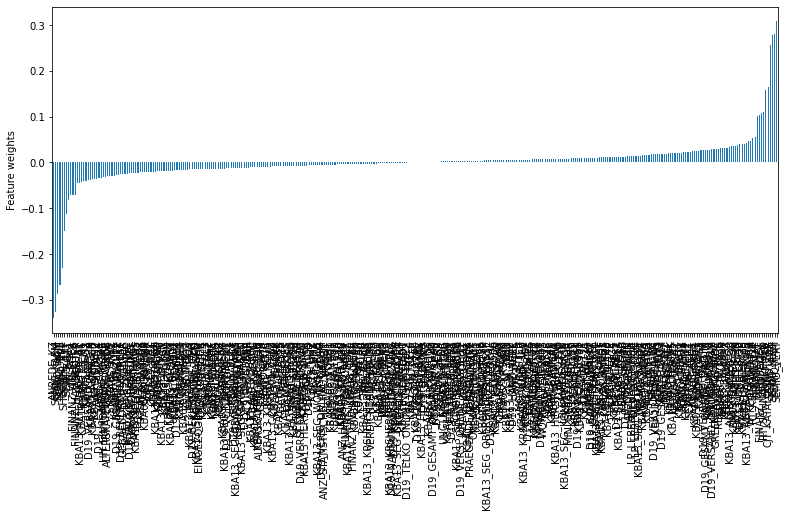

In [84]:
# 6 Pricipal components 
# change the number of components to 6

# pca components
components_6 = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_standS.keys())
components_6.index = dimensions

# bar plot of feature weights  
fig, ax = plt.subplots(figsize = (13,6))

components_6.iloc[6-1, :].sort_values().plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
ax.set_xticklabels(components_6.iloc[6-1, :].sort_values().index, rotation=90)

Text(0, 0.5, 'Feature weights')

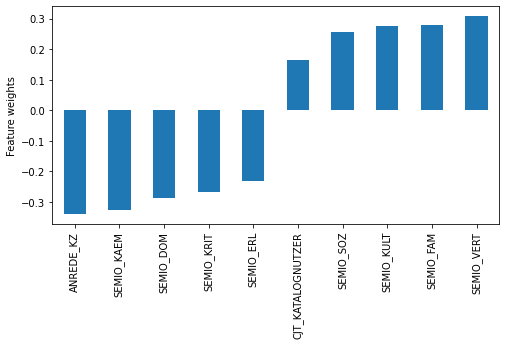

In [85]:
# bar plot 
fig, ax = plt.subplots(figsize = (8,4))

# plot the feature weights as a function of the components
components_6.iloc[6-1, :].sort_values().iloc[[0, 1, 2, 3, 4,-5,-4, -3, -2, -1]].plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature weights")
#ax.set_xticklabels(components_1.iloc[2-1, :].sort_values().index, rotation=90)

### Here we got:
Last 5 columns
* 'ANREDE_KZ'
* 'SEMIO_KAEM'
* 'SEMIO_DOM'
* 'SEMIO_KRT'
* 'SEMIO_ERL'
---------------
TOP 5 columns 
* 'CJT_KATALOGNUTZER'
* 'SEMIO_SOZ'
* 'SEMIO_KULT'
* 'SEMIO_FAM'
* 'SEMIO_VERT'

In [86]:
# top 5 negative correlated features
some_values= ['ANREDE_KZ',
'SEMIO_KAEM',
'SEMIO_DOM',
'SEMIO_KRT',
'SEMIO_ERL']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                                        Description  Value  \
33     ANREDE_KZ                                             gender  -1, 0   
34     ANREDE_KZ                                                NaN      1   
35     ANREDE_KZ                                                NaN      2   
2090   SEMIO_DOM  affinity indicating in what way the person is ...  -1, 9   
2091   SEMIO_DOM                                                NaN      1   
2092   SEMIO_DOM                                                NaN      2   
2093   SEMIO_DOM                                                NaN      3   
2094   SEMIO_DOM                                                NaN      4   
2095   SEMIO_DOM                                                NaN      5   
2096   SEMIO_DOM                                                NaN      6   
2097   SEMIO_DOM                                                NaN      7   
2098   SEMIO_ERL  affinity indicating in what way the person is ...  -1, 9   
2099   SEMIO_ERL                                                NaN      1   
2100   SEMIO_ERL                                                NaN      2   
2101   SEMIO_ERL                                                NaN      3   
2102   SEMIO_ERL                                                NaN      4   
2103   SEMIO_ERL                                                NaN      5   
2104   SEMIO_ERL                                                NaN      6   
2105   SEMIO_ERL                                                NaN      7   
2114  SEMIO_KAEM  affinity indicating in what way the person is ...  -1, 9   
2115  SEMIO_KAEM                                                NaN      1   
2116  SEMIO_KAEM                                                NaN      2   
2117  SEMIO_KAEM                                                NaN      3   
2118  SEMIO_KAEM                                                NaN      4   
2119  SEMIO_KAEM                                                NaN      5   
2120  SEMIO_KAEM                                                NaN      6   
2121  SEMIO_KAEM                                                NaN      7   

                 Meaning  
33               unknown  
34                  male  
35                female  
2090             unknown  
2091    highest affinity  
2092  very high affinity  
2093       high affinity  
2094    average affinity  
2095        low affinity  
2096   very low affinity  
2097     lowest affinity  
2098             unknown  
2099    highest affinity  
2100  very high affinity  
2101       high affinity  
2102    average affinity  
2103        low affinity  
2104   very low affinity  
2105     lowest affinity  
2114             unknown  
2115    highest affinity  
2116  very high affinity  
2117       high affinity  
2118    average affinity  
2119        low affinity  
2120   very low affinity  
2121     lowest affinity

In [87]:
# top 5 positive correlated features
some_values= ['CJT_KATALOGNUTZER',
'SEMIO_SOZ',
'SEMIO_KULT',
'SEMIO_FAM',
'SEMIO_VERT']
dias_attributes.loc[dias_attributes['Attribute'].isin(some_values)]

Attribute                                        Description  Value  \
2106   SEMIO_FAM  affinity indicating in what way the person is ...  -1, 9   
2107   SEMIO_FAM                                                NaN      1   
2108   SEMIO_FAM                                                NaN      2   
2109   SEMIO_FAM                                                NaN      3   
2110   SEMIO_FAM                                                NaN      4   
2111   SEMIO_FAM                                                NaN      5   
2112   SEMIO_FAM                                                NaN      6   
2113   SEMIO_FAM                                                NaN      7   
2130  SEMIO_KULT  affinity indicating in what way the person is ...  -1, 9   
2131  SEMIO_KULT                                                NaN      1   
2132  SEMIO_KULT                                                NaN      2   
2133  SEMIO_KULT                                                NaN      3   
2134  SEMIO_KULT                                                NaN      4   
2135  SEMIO_KULT                                                NaN      5   
2136  SEMIO_KULT                                                NaN      6   
2137  SEMIO_KULT                                                NaN      7   
2178   SEMIO_SOZ  affinity indicating in what way the person is ...  -1, 9   
2179   SEMIO_SOZ                                                NaN      1   
2180   SEMIO_SOZ                                                NaN      2   
2181   SEMIO_SOZ                                                NaN      3   
2182   SEMIO_SOZ                                                NaN      4   
2183   SEMIO_SOZ                                                NaN      5   
2184   SEMIO_SOZ                                                NaN      6   
2185   SEMIO_SOZ                                                NaN      7   
2194  SEMIO_VERT  affinity indicating in what way the person is ...  -1, 9   
2195  SEMIO_VERT                                                NaN      1   
2196  SEMIO_VERT                                                NaN      2   
2197  SEMIO_VERT                                                NaN      3   
2198  SEMIO_VERT                                                NaN      4   
2199  SEMIO_VERT                                                NaN      5   
2200  SEMIO_VERT                                                NaN      6   
2201  SEMIO_VERT                                                NaN      7   

                 Meaning  
2106             unknown  
2107    highest affinity  
2108  very high affinity  
2109       high affinity  
2110    average affinity  
2111        low affinity  
2112   very low affinity  
2113     lowest affinity  
2130             unknown  
2131    highest affinity  
2132  very high affinity  
2133       high affinity  
2134    average affinity  
2135        low affinity  
2136   very low affinity  
2137     lowest affinity  
2178             unknown  
2179    highest affinity  
2180  very high affinity  
2181       high affinity  
2182    average affinity  
2183        low affinity  
2184   very low affinity  
2185     lowest affinity  
2194             unknown  
2195    highest affinity  
2196  very high affinity  
2197       high affinity  
2198    average affinity  
2199        low affinity  
2200   very low affinity  
2201     lowest affinity

If we implement 6 components, we can observe that for the negative correlated features weights we got: 




They are related to gender, affinity indicating in what way the person is dominant minded, affinity indicating in what way the person is eventful orientated, affinity indicating in what way the person is of a fightfull attitude, the others have unknown description. 

And for positive correlated features weights we got: 


They are related to affinity indicating in what way the person is familiar minded, affinity indicating in what way the person is cultural minded,  affinity indicating in what way the person is social minded, affinity indicating in what way the person is dreamily, and one with unknown desciption. 

## K-means

And now we can create the Kmeans clustering to analyze how data behaves in the principal components quadrant. 

In [88]:
# testing with n clusters

kmeans = KMeans(
    init="random",
    n_clusters=10,
    n_init=10,
    max_iter=100,
    random_state=42
    )
kmeans.fit(new_df)

KMeans(init='random', max_iter=100, n_clusters=10, random_state=42)

In [89]:
# the lowest SSE value
print("the lowest SSE value:", kmeans.inertia_)
print('\n')
# final locations of the centroid
print("final locations of the centroid:", kmeans.cluster_centers_)
print('\n')
# the number of iterations required to converge
print("the number of iterations required to converge:", kmeans.n_iter_)
print('\n')
# predicted labels 
print("predicted labels",kmeans.labels_[:])

the lowest SSE value: 183362752.66169152


final locations of the centroid: [[-2.41511979e+00 -6.87898883e+00 -8.58441803e-01 ...  5.28493949e-02
  -3.39106175e-03 -3.80816060e-02]
 [ 7.82216044e+00  2.25828218e+00  5.89008624e-01 ... -2.86922015e-02
   1.98074277e-03 -4.14052131e-02]
 [-6.02531092e+00 -4.76008281e-01  3.84347365e+00 ... -4.22817162e-03
   2.82427328e-03  2.14573921e-02]
 ...
 [ 2.45193655e+00  1.49183799e-01 -3.87243862e+00 ...  2.30500068e-02
  -2.67042667e-02 -3.07424051e-02]
 [ 5.01970663e+00 -6.39402831e-01  3.39644650e+00 ...  1.91969650e-02
  -2.40477945e-02  1.91924230e-02]
 [ 5.67865295e+00 -5.30665414e+00 -1.76661258e+00 ... -2.79161450e-02
   4.30518193e-02  6.55161626e-02]]


the number of iterations required to converge: 95


predicted labels [4 4 6 ... 4 8 7]


In [90]:
# applying the elbow method (to know the right optimim number of clusters)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 100,
    "random_state": 42,
    }

# list holds the SSE values for each k

sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(new_df)
    sse.append(kmeans.inertia_)

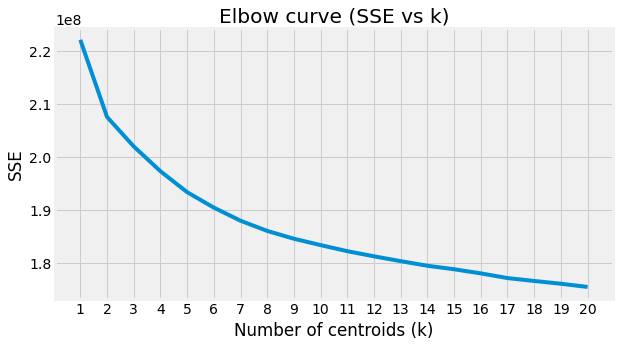

In [91]:
# plotting elbow method 

fig = plt.figure(figsize=(10, 5))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.title('Elbow curve (SSE vs k)')
plt.xlabel("Number of centroids (k)")
plt.ylabel("SSE")
plt.show()

In [92]:
# identifying the number of clusters

kl = KneeLocator(
    range(1, 21), sse, curve="convex", direction="decreasing")

# 7 is the perfect number of cluster
kl.elbow

7

Once we compare the sum of squares within each cluster, we got that number 7 is when there's no significant improvement.

In [93]:
# fit the kmeans model with the right number of clusters 

kmeans = KMeans(
    init="random",
    n_clusters=7,
    n_init=10,
    max_iter=100,
    random_state=42
    )

kmean_model = kmeans.fit(new_df)
azdias_labels = kmean_model.predict(new_df)

In [94]:
# the lowest SSE value
print("the lowest SSE value:", kmeans.inertia_)
print('\n')
# final locations of the centroid
print("final locations of the centroid:", kmeans.cluster_centers_)
print('\n')
# the number of iterations required to converge
print("the number of iterations required to converge:", kmeans.n_iter_)
print('\n')
# predicted labels 
print("predicted labels",kmeans.labels_[:])

the lowest SSE value: 187966385.81634602


final locations of the centroid: [[ 3.54537220e-02  1.98684779e-01  3.41728565e+00 ...  1.74924393e-02
  -3.07156275e-04  1.01517026e-02]
 [-1.11473632e+00  7.02893438e+00 -1.31534155e+00 ...  2.23583770e-03
   1.05315154e-02 -1.72489763e-02]
 [ 2.34476754e+00 -6.33083183e+00 -1.57601558e+00 ...  1.42469291e-02
   3.16088792e-02  3.14246245e-02]
 ...
 [ 3.27705912e+00  1.35800990e-01 -3.79715746e+00 ...  2.13658889e-02
  -3.07012581e-02 -3.58150921e-02]
 [ 7.38320985e+00  1.08699282e+00  2.24721117e+00 ... -3.00165005e-02
  -6.43958629e-03 -1.04642729e-02]
 [-5.99563859e+00 -8.77487932e-01  3.37243373e+00 ... -2.66617399e-03
   4.76737297e-05  1.70423172e-02]]


the number of iterations required to converge: 40


predicted labels [0 0 3 ... 0 5 3]


In [95]:
# PCA on the customers dataset using the pca generated (using azdias data)
customers_pca = pca_fit.transform(customers_standS)

# clustering on customers data using model generated with kmeans (using azdias data)
customers_labels = kmean_model.predict(customers_pca)

# labels predicted for the customers dataset
customers_labels[:]

array([3, 4, 3, ..., 3, 4, 3], dtype=int32)

Once we have created the clusters on the demographics data and observed how customer data behaves on the clusters,
It is important to analyze the cluster distributions because we want to identify the most important customers,  according to the company's question. 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


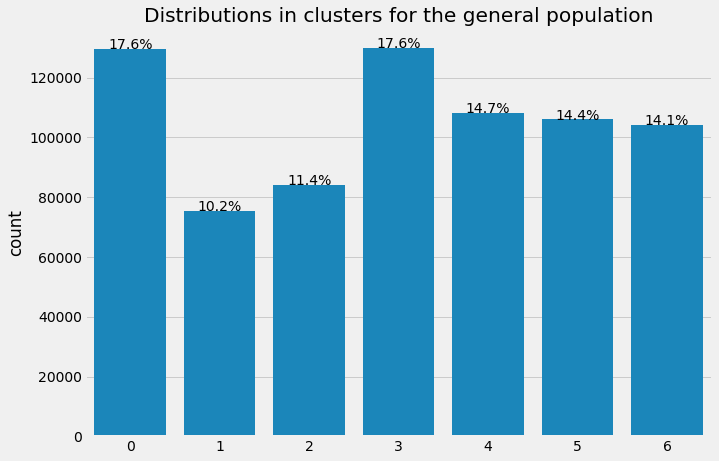

In [96]:
# clusters distributions for azdias

base = sns.color_palette()[0]
total = len(azdias_labels)

fig = plt.figure(figsize = (10,7))
ax = sns.countplot(azdias_labels, color = base)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1%}'.format(height/total),
            ha= "center") 
plt.title('Distributions in clusters for the general population')
plt.show();

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


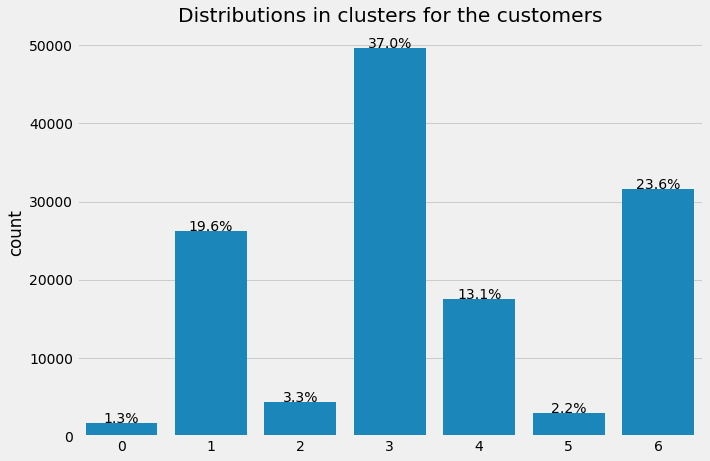

In [97]:
# clusters distribution for customers

total_customers = len(customers_labels)
fig = plt.figure(figsize = (10,7))
ax_c = sns.countplot(customers_labels, color = base)

for p in ax_c.patches:
    height = p.get_height()
    ax_c.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1%}'.format(height/total_customers),
            ha="center") 
plt.title('Distributions in clusters for the customers')
plt.show();

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


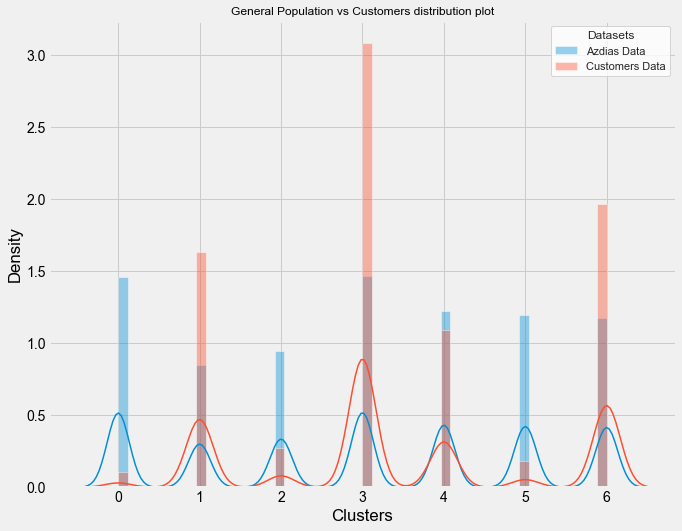

In [98]:
# plotting clusters density distrirbution

fig, ax = plt.subplots(figsize=(10,8))
sns.set(style="white")
sns.distplot(azdias_labels, label='Azdias Data',ax=ax).set_title('General Population vs Customers distribution plot')
sns.distplot(customers_labels , label='Customers Data', ax=ax)
ax.set(xlabel='Clusters', ylabel='Density')
ax.legend().set_title('Datasets')

After fitting the K-means algortihms with 7 clusters, we got some clusters with more customers data when compared to the population data.  

This plot show us the distribution of clusters from the azdias and custumers datasets. We can observe in cluster 3,
that the customers density is greater than the general population  density, so this could be a good cluster to interpret it as a good one for being part of the  main customer base for the  mail-order company's customer baser , than the others. 

Customers are represented by the cluster number 1,3 and 6 mostly. They could be the target we are looking for. On the other side, the clusters number 0, 2 and 5 are the ones with the most underrepresented among all.

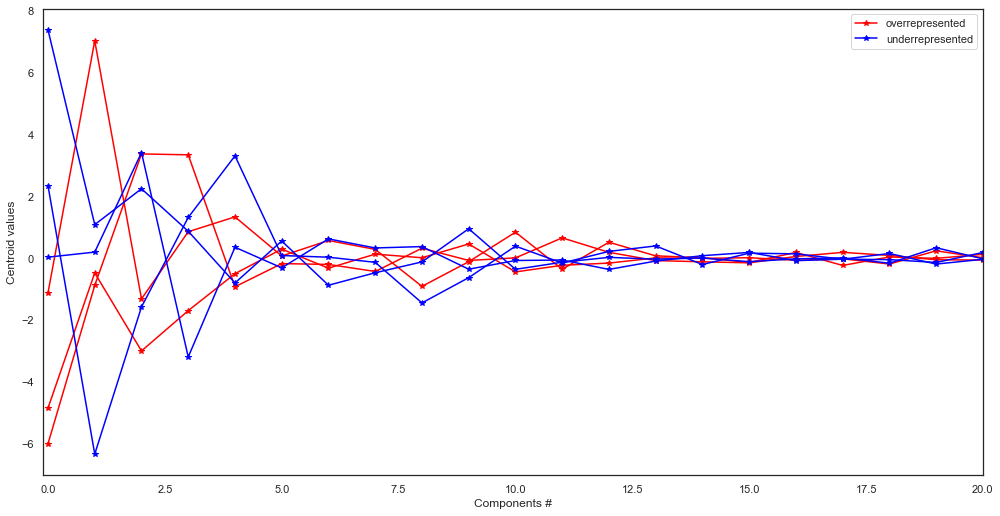

In [100]:
# plotting overrepresented and underrepresented features with centroids and  components 

weights_1= kmean_model.cluster_centers_[1]
weights_3 = kmean_model.cluster_centers_[3]
weights_6 = kmean_model.cluster_centers_[6]

weights_0 = kmean_model.cluster_centers_[0]
weights_2 = kmean_model.cluster_centers_[2]
weights_5 = kmean_model.cluster_centers_[5]

components = list(range(0, 173))

plt.figure(figsize=(15,8))
plt.plot(components, weights_1, color = 'red', marker='*', label='overrepresented')
plt.plot(components, weights_3, color = 'red', marker='*')
plt.plot(components, weights_6, color = 'red', marker='*')
plt.plot(components, weights_0, color = 'blue', marker='*',  label='underrepresented')
plt.plot(components, weights_2, color = 'blue', marker='*')
plt.plot(components, weights_5, color = 'blue', marker='*')
plt.xlim(-0.1,20)
plt.legend()
plt.ylabel('Centroid values')
plt.xlabel('Components #');

In [101]:
# calculating the proportions of clusters for the population.

population = 891221
counter = Counter(azdias_labels)
proportions = [(i, counter[i] / population * 100.0) for i in counter]
proportions.sort(key=itemgetter(0))
proportions = np.array(proportions)

# calculating the proportions some data was remove because of many NaNs, and include it as a cluster (negative)

drop_pop = 100 - proportions[:, 1].sum()
azd_prop = np.insert(proportions, 0, values=[-1, drop_pop], axis=0)
azd_prop

array([[-1.        , 17.27214686],
       [ 0.        , 14.52748533],
       [ 1.        ,  8.44852175],
       [ 2.        ,  9.42055899],
       [ 3.        , 14.59189135],
       [ 4.        , 12.14973615],
       [ 5.        , 11.89267309],
       [ 6.        , 11.69698649]])

In [102]:
# calculating the proportions of clusters for the population.

population = 191652
counter = Counter(customers_labels)
proportions = [(i, counter[i] / population * 100.0) for i in counter]
proportions.sort(key=itemgetter(0))
proportions = np.array(proportions)

# calculating the proportions some data was remove because of many NaNs, and include it as a cluster (negative)

drop_pop = 100 - proportions[:, 1].sum()
cus_prop = np.insert(proportions, 0, values=[-1, drop_pop], axis=0)
cus_prop

array([[-1.        , 29.9532486 ],
       [ 0.        ,  0.8771106 ],
       [ 1.        , 13.70557051],
       [ 2.        ,  2.30417632],
       [ 3.        , 25.93398451],
       [ 4.        ,  9.17339762],
       [ 5.        ,  1.54342245],
       [ 6.        , 16.50908939]])

In [103]:
# comparing the data proportion in each cluster (from the customer data to 
# the proportion of data in each cluster for the population)

ratio = cus_prop[:, 1]/azd_prop[:, 1]

Text(0.5, 1.0, 'Customers/General Population')

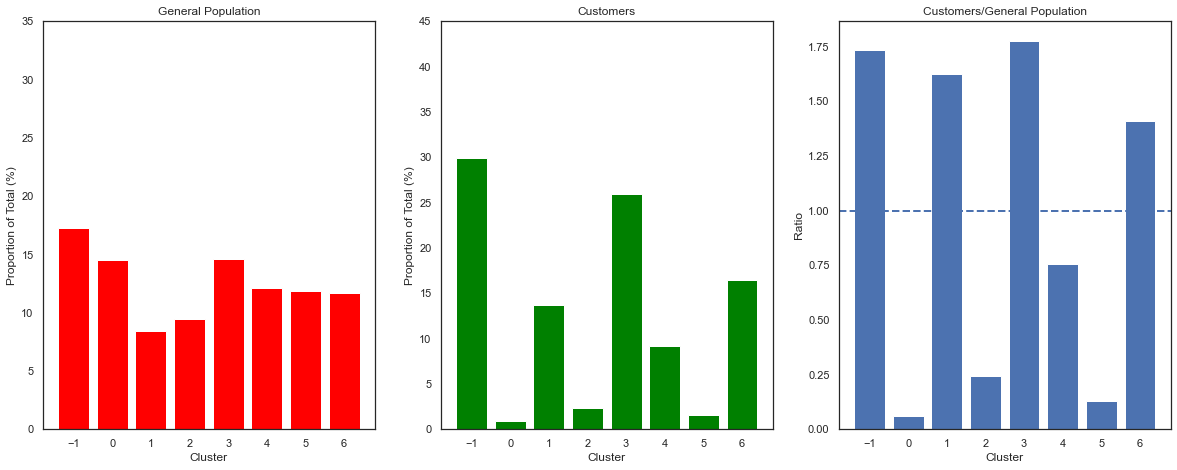

In [104]:
# plotting the proportions for the general population, the customer population,
# and the ratio of customer/general populations.


plt.figure(figsize=(18, 7))

ax1 = plt.subplot(131)
ax1.bar(azd_prop[:, 0], azd_prop[:, 1], color = 'red')
ax1.set_xticks(azd_prop[:, 0])
ax1.set_ylim(ymax = 35)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
plt.title('General Population')

ax2 = plt.subplot(132)
ax2.bar(cus_prop[:, 0], cus_prop[:, 1], color = 'green')
ax2.set_xticks(azd_prop[:, 0])
ax2.set_ylim(ymax = 45)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
plt.title('Customers')

ax3 = plt.subplot(133)
ax3.bar(azd_prop[:, 0], ratio)
ax3.set_xticks(azd_prop[:, 0])
ax3.set_xlabel("Cluster")
ax3.set_ylabel("Ratio")
ax3.axhline(y=1, linestyle = "--", linewidth = 2)
plt.title('Customers/General Population')

In [105]:
# calculating proportions of predicitons by data in the clusters 

azdias_clus = pd.Series(azdias_labels)
azdias_clus = azdias_clus.value_counts().sort_index()
azdias_clus_perc = azdias_clus / azdias_clus.sum()

customers_clus= pd.Series(customers_labels)
customers_clus = customers_clus.value_counts().sort_index()
customers_clus_perc = customers_clus / customers_clus.sum()

cluster_perc = pd.concat([azdias_clus_perc, customers_clus_perc], axis=1)
cluster_perc.columns = ['azdias', 'customer']
cluster_perc['difference'] = cluster_perc['customer'] - cluster_perc['azdias']
cluster_perc.sort_values(by='difference', ascending=False)

azdias  customer  difference
3  0.176384  0.370238    0.193854
6  0.141391  0.235687    0.094296
1  0.102124  0.195663    0.093539
4  0.146864  0.130961   -0.015903
2  0.113874  0.032895   -0.080979
5  0.143757  0.022034   -0.121722
0  0.175606  0.012522   -0.163084

<Figure size 1080x360 with 0 Axes>

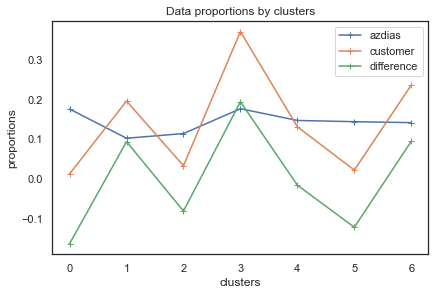

In [106]:
# plotting data proportions by clusters (with line plot)

plt.figure(figsize=(15, 5))
cluster_perc.plot(marker='+')
plt.xlabel('clusters')
plt.ylabel('proportions')
plt.title('Data proportions by clusters')
plt.show()

We can observe that the most overrepresented clusters are numbers 3 and 6 in the customer data compared to the general population, and the most underrepresented clusters are numbers 2 and 5 in the customer data. 

In [107]:
# now we create a table of weights and components, (identify people that are part of a cluster that is over
# represented in the customer data compared to the population )

# for 0 cluster center 
weights = kmean_model.cluster_centers_[0]
components = list(range(1, 174))
cluster_components = pd.DataFrame({'Weights': weights, 'Components': components})
cluster_components.sort_values('Weights',ascending=False) 

Weights  Components
2    3.417286           3
6    0.626639           7
8    0.377269           9
4    0.355212           5
7    0.332543           8
1    0.198685           2
15   0.188114          16
18   0.153938          19
27   0.136678          28
38   0.114708          39
28   0.113813          29
14   0.083227          15
55   0.069352          56
56   0.054892          57
52   0.053654          53
32   0.053243          33
116  0.046732         117
24   0.045423          25
36   0.041685          37
76   0.040674          77
23   0.040111          24
150  0.037120         151
29   0.035514          30
0    0.035454           1
168  0.035288         169
165  0.034791         166
54   0.034454          55
67   0.031795          68
63   0.030670          64
147  0.030657         148
148  0.029456         149
151  0.028841         152
79   0.026233          80
93   0.026211          94
118  0.026047         119
119  0.025543         120
109  0.024632         110
47   0.023757          48
75   0.021149          76
135  0.020657         136
130  0.020409         131
66   0.020372          67
90   0.020354          91
22   0.019961          23
61   0.019948          62
131  0.018818         132
128  0.018281         129
170  0.017492         171
99   0.017468         100
53   0.017382          54
30   0.016533          31
70   0.015206          71
88   0.014223          89
132  0.012686         133
166  0.011958         167
25   0.011659          26
115  0.011600         116
101  0.010650         102
103  0.010209         104
172  0.010152         173
153  0.009875         154
152  0.009872         153
111  0.009784         112
127  0.008599         128
112  0.008199         113
154  0.008034         155
136  0.008000         137
162  0.007658         163
106  0.007629         107
82   0.007561          83
46   0.007171          47
42   0.006699          43
160  0.005140         161
58   0.004975          59
123  0.004715         124
74   0.004713          75
83   0.004458          84
138  0.004053         139
121  0.003055         122
157  0.002174         158
97   0.002079          98
140  0.002047         141
96   0.001766          97
149  0.001580         150
73  -0.000135          74
171 -0.000307         172
43  -0.000720          44
104 -0.000839         105
89  -0.001076          90
105 -0.001208         106
143 -0.001466         144
102 -0.001990         103
60  -0.002207          61
141 -0.002430         142
86  -0.002481          87
126 -0.003460         127
137 -0.003828         138
110 -0.004287         111
72  -0.004721          73
134 -0.005021         135
163 -0.005511         164
129 -0.007075         130
159 -0.007292         160
139 -0.007459         140
107 -0.007532         108
144 -0.007714         145
113 -0.008035         114
142 -0.008050         143
50  -0.008810          51
78  -0.009489          79
40  -0.010216          41
146 -0.010302         147
108 -0.010677         109
68  -0.011295          69
114 -0.011912         115
156 -0.012040         157
100 -0.012632         101
35  -0.013134          36
87  -0.013444          88
34  -0.013843          35
84  -0.014224          85
80  -0.015038          81
164 -0.015404         165
44  -0.016115          45
125 -0.016611         126
57  -0.016907          58
158 -0.017462         159
91  -0.018515          92
45  -0.019621          46
155 -0.019802         156
95  -0.020347          96
124 -0.021122         125
48  -0.021317          49
92  -0.023409          93
98  -0.023883          99
167 -0.024281         168
133 -0.024681         134
117 -0.025057         118
161 -0.025817         162
59  -0.025888          60
62  -0.026610          63
120 -0.026623         121
94  -0.028296          95
33  -0.028417          34
85  -0.028900          86
17  -0.031371          18
122 -0.032295         123
81  -0.032607          82
169 -0.032739         170
37  -0.032880          38
145 -0.033961         146
20  -0.034611          21
69  -0.036738          70
77

In [108]:
# now we create a table of weights and components, (identify people that are part of a cluster that is over
# represented in the customer data compared to the population )

# for 1 cluster center 
weights = kmean_model.cluster_centers_[1]
components = list(range(1, 174))
cluster_components = pd.DataFrame({'Weights': weights, 'Components': components})
cluster_components.sort_values('Weights',ascending=False) 

Weights  Components
1    7.028934           2
4    1.337827           5
3    0.857349           4
10   0.842789          11
6    0.573914           7
12   0.517462          13
7    0.286555           8
37   0.232614          38
16   0.188139          17
40   0.160426          41
20   0.127467          21
53   0.123787          54
49   0.116484          50
36   0.113569          37
145  0.103113         146
55   0.082235          56
99   0.080637         100
29   0.077887          30
13   0.077329          14
96   0.075471          97
133  0.075022         134
5    0.073486           6
21   0.070814          22
83   0.068401          84
97   0.066317          98
90   0.065063          91
24   0.062147          25
52   0.061226          53
119  0.054487         120
69   0.052859          70
57   0.047175          58
100  0.044749         101
102  0.044319         103
18   0.041611          19
68   0.038991          69
62   0.036749          63
46   0.036186          47
144  0.035418         145
82   0.034706          83
75   0.031965          76
162  0.026782         163
154  0.026746         155
159  0.026519         160
101  0.026147         102
124  0.024633         125
168  0.023067         169
89   0.021991          90
107  0.021662         108
59   0.021617          60
121  0.021072         122
120  0.020135         121
161  0.019660         162
41   0.019617          42
117  0.019216         118
135  0.019158         136
80   0.018636          81
63   0.018592          64
104  0.016515         105
14   0.016364          15
71   0.015893          72
131  0.014941         132
112  0.013845         113
139  0.013785         140
157  0.013509         158
113  0.013145         114
61   0.012450          62
115  0.012431         116
54   0.011981          55
128  0.011886         129
122  0.011336         123
150  0.010668         151
171  0.010532         172
86   0.010365          87
126  0.009660         127
72   0.009350          73
64   0.009078          65
156  0.008135         157
164  0.007596         165
140  0.006830         141
158  0.005347         159
103  0.004613         104
78   0.003971          79
134  0.003779         135
129  0.003631         130
137  0.003451         138
149  0.003122         150
169  0.002709         170
170  0.002236         171
94   0.001617          95
123  0.001614         124
146  0.001019         147
81   0.000493          82
73  -0.000031          74
110 -0.001726         111
56  -0.002112          57
105 -0.003017         106
19  -0.003613          20
67  -0.003805          68
87  -0.004274          88
114 -0.005121         115
91  -0.005254          92
151 -0.006108         152
108 -0.006996         109
147 -0.007484         148
74  -0.008547          75
165 -0.009038         166
166 -0.009043         167
125 -0.009596         126
143 -0.009706         144
79  -0.009958          80
160 -0.010385         161
88  -0.011383          89
153 -0.011391         154
70  -0.012460          71
33  -0.012562          34
167 -0.013296         168
77  -0.013638          78
109 -0.013747         110
58  -0.013793          59
98  -0.014820          99
127 -0.016218         128
106 -0.016984         107
172 -0.017249         173
47  -0.018423          48
66  -0.019610          67
142 -0.021840         143
42  -0.022338          43
130 -0.023112         131
95  -0.023133          96
34  -0.023177          35
23  -0.024089          24
76  -0.026615          77
27  -0.027179          28
111 -0.027596         112
163 -0.027962         164
152 -0.030900         153
148 -0.030929         149
116 -0.031745         117
141 -0.032465         142
132 -0.038281         133
138 -0.038626         139
28  -0.040032          29
118 -0.041781         119
136 -0.049376         137
155 -0.050963         156
38  -0.052681          39
65  -0.053505          66
31  -0.055239          32
84  -0.055477          85
85  -0.057653          86
44  -0.059246          45
51  -0.059518          52
35  -0.060559          36
39

In [109]:
# now we create a table of weights and components, (identify people that are part of a cluster that is over
# represented in the customer data compared to the population )

# for 2 cluster center 
weights = kmean_model.cluster_centers_[2]
components = list(range(1, 174))
cluster_components = pd.DataFrame({'Weights': weights, 'Components': components})
cluster_components.sort_values('Weights',ascending=False) 

Weights  Components
4    3.310774           5
0    2.344768           1
3    1.319159           4
13   0.397663          14
10   0.391748          11
12   0.221470          13
37   0.202138          38
20   0.187018          21
15   0.164284          16
16   0.142645          17
40   0.127798          41
55   0.106812          56
49   0.097488          50
23   0.089994          24
5    0.088258           6
35   0.081932          36
62   0.068870          63
100  0.065000         101
36   0.064320          37
52   0.062854          53
30   0.062751          31
162  0.062263         163
99   0.060719         100
154  0.059612         155
119  0.057326         120
69   0.054548          70
61   0.048459          62
21   0.040235          22
47   0.039868          48
74   0.038147          75
144  0.035569         145
153  0.034270         154
6    0.033821           7
27   0.031818          28
171  0.031609         172
172  0.031425         173
53   0.030239          54
145  0.027722         146
134  0.027529         135
73   0.026021          74
78   0.025203          79
157  0.023869         158
90   0.019871          91
133  0.019443         134
101  0.018404         102
150  0.017856         151
57   0.017766          58
116  0.015188         117
123  0.015024         124
104  0.014921         105
170  0.014247         171
130  0.014025         131
112  0.013890         113
115  0.012931         116
128  0.012717         129
80   0.012249          81
120  0.012019         121
97   0.011377          98
89   0.010721          90
68   0.010634          69
63   0.010400          64
94   0.009533          95
129  0.009497         130
41   0.009205          42
126  0.009082         127
168  0.008803         169
151  0.008750         152
124  0.006963         125
131  0.005767         132
111  0.004858         112
160  0.004229         161
110  0.003705         111
88   0.002895          89
132  0.000749         133
86   0.000742          87
42   0.000381          43
51   0.000199          52
87   0.000023          88
139 -0.000794         140
79  -0.001290          80
165 -0.001778         166
135 -0.001936         136
146 -0.002039         147
81  -0.003029          82
121 -0.003773         122
102 -0.004200         103
117 -0.004447         118
95  -0.004591          96
93  -0.004650          94
107 -0.004971         108
149 -0.005477         150
158 -0.005546         159
140 -0.005658         141
77  -0.005735          78
167 -0.006411         168
169 -0.006751         170
91  -0.007052          92
108 -0.007471         109
64  -0.007516          65
163 -0.008150         164
137 -0.008263         138
24  -0.008309          25
113 -0.008637         114
106 -0.008704         107
136 -0.008867         137
34  -0.009467          35
48  -0.010403          49
143 -0.010501         144
70  -0.011557          71
76  -0.011763          77
65  -0.011767          66
83  -0.011913          84
82  -0.014684          83
138 -0.014783         139
142 -0.014979         143
161 -0.015646         162
29  -0.015879          30
105 -0.016084         106
72  -0.017202          73
152 -0.017875         153
141 -0.018091         142
159 -0.018206         160
59  -0.018392          60
103 -0.018736         104
114 -0.019726         115
33  -0.019911          34
26  -0.020099          27
166 -0.021009         167
84  -0.021097          85
96  -0.022976          97
85  -0.024009          86
45  -0.024674          46
98  -0.025845          99
127 -0.026112         128
46  -0.026385          47
118 -0.026789         119
156 -0.026834         157
148 -0.026844         149
17  -0.029914          18
44  -0.032331          45
31  -0.032795          32
147 -0.034008         148
155 -0.036256         156
58  -0.036307          59
54  -0.037245          55
125 -0.039700         126
109 -0.039871         110
18  -0.044432          19
122 -0.046532         123
32  -0.049824          33
71  -0.052397          72
56  -0.055594          57
67  -0.056705          68
60

In [110]:
# for 3 cluster centers

weights = kmean_model.cluster_centers_[3]
components = list(range(1, 174))
cluster_components = pd.DataFrame({'Weights': weights, 'Component': components})
cluster_components.sort_values('Weights',ascending=False)

Weights  Component
9    0.461973         10
5    0.296687          6
19   0.240929         20
27   0.205528         28
7    0.132810          8
25   0.126511         26
41   0.110022         42
45   0.108948         46
48   0.102877         49
67   0.083252         68
26   0.055688         27
98   0.051841         99
60   0.049381         61
43   0.047751         44
32   0.047707         33
84   0.045965         85
63   0.043841         64
103  0.041627        104
117  0.041490        118
44   0.038251         45
65   0.036289         66
125  0.035832        126
47   0.035666         48
31   0.035135         32
58   0.035123         59
169  0.034649        170
50   0.033028         51
23   0.031283         24
92   0.029702         93
33   0.029653         34
110  0.029484        111
123  0.029062        124
136  0.027873        137
140  0.025244        141
161  0.025041        162
163  0.024757        164
105  0.024224        106
106  0.023247        107
94   0.023154         95
85   0.022861         86
113  0.021579        114
118  0.020706        119
167  0.019090        168
80   0.018947         81
147  0.017496        148
93   0.017282         94
137  0.017259        138
109  0.017190        110
8    0.016760          9
30   0.016646         31
15   0.016364         16
71   0.016164         72
20   0.015688         21
159  0.015660        160
130  0.015544        131
56   0.015397         57
164  0.014266        165
132  0.013933        133
81   0.013816         82
122  0.013278        123
138  0.013100        139
77   0.012484         78
101  0.011607        102
61   0.011003         62
158  0.010861        159
13   0.010540         14
166  0.009752        167
64   0.009291         65
73   0.009029         74
51   0.008690         52
34   0.008620         35
146  0.008609        147
131  0.007222        132
116  0.006361        117
104  0.006069        105
91   0.005609         92
143  0.004921        144
114  0.004882        115
171  0.004577        172
172  0.004278        173
86   0.004263         87
74   0.004005         75
87   0.003221         88
155  0.002935        156
112  0.002651        113
72   0.001569         73
150  0.001347        151
107  0.000884        108
35   0.000661         36
129 -0.000023        130
97  -0.000790         98
111 -0.001102        112
46  -0.001232         47
115 -0.001788        116
90  -0.002264         91
153 -0.002497        154
152 -0.002615        153
141 -0.003310        142
14  -0.003664         15
151 -0.003823        152
124 -0.005605        125
70  -0.006396         71
149 -0.006757        150
162 -0.009795        163
89  -0.010025         90
157 -0.010157        158
127 -0.010460        128
57  -0.011142         58
148 -0.012950        149
160 -0.013062        161
134 -0.013504        135
88  -0.013815         89
156 -0.014669        157
108 -0.015005        109
29  -0.015778         30
49  -0.016291         50
66  -0.016548         67
96  -0.016573         97
119 -0.018544        120
79  -0.018798         80
170 -0.019092        171
17  -0.019251         18
139 -0.019962        140
54  -0.021151         55
154 -0.021977        155
95  -0.022171         96
133 -0.022879        134
62  -0.023501         63
83  -0.023796         84
128 -0.024298        129
75  -0.025111         76
165 -0.025871        166
102 -0.028170        103
126 -0.028277        127
120 -0.028312        121
142 -0.029058        143
135 -0.030449        136
100 -0.031594        101
145 -0.033503        146
78  -0.033611         79
38  -0.035481         39
21  -0.036158         22
69  -0.036937         70
36  -0.039151         37
82  -0.039488         83
144 -0.039578        145
168 -0.045418        169
76  -0.046253         77
99  -0.048573        100
22  -0.054400         23
39  -0.055222         40
121 -0.056307        122
68  -0.060359         69
16  -0.065455         17
59  -0.068341         60
42  -0.075430         43
55  -0.084454         56
53  -0.100235         54
37  -0.106761         38
28  -0

In [111]:
# now we create a table of weights and components, (identify people that are part of a cluster that is over
# represented in the customer data compared to the population )

# for 4 cluster center 
weights = kmean_model.cluster_centers_[4]
components = list(range(1, 174))
cluster_components = pd.DataFrame({'Weights': weights, 'Components': components})
cluster_components.sort_values('Weights',ascending=False) 

Weights  Components
0    3.277059           1
8    1.084270           9
6    0.257867           7
7    0.217243           8
11   0.200369          12
24   0.175486          25
39   0.175388          40
3    0.158616           4
14   0.154684          15
1    0.135801           2
38   0.125150          39
37   0.115533          38
18   0.114665          19
52   0.114413          53
28   0.098236          29
25   0.077920          26
135  0.068291         136
10   0.068180          11
50   0.062456          51
76   0.061759          77
108  0.059396         109
57   0.054431          58
66   0.053911          67
75   0.053748          76
17   0.050121          18
141  0.049432         142
168  0.047513         169
82   0.047444          83
165  0.047270         166
155  0.046734         156
53   0.046124          54
54   0.046121          55
142  0.045965         143
65   0.043233          66
152  0.042624         153
46   0.041773          47
95   0.041393          96
42   0.038980          43
121  0.035997         122
156  0.035536         157
126  0.033808         127
78   0.033133          79
148  0.031949         149
55   0.031543          56
120  0.029932         121
68   0.029383          69
69   0.029053          70
144  0.027356         145
127  0.026303         128
118  0.025010         119
60   0.024909          61
160  0.024616         161
134  0.024099         135
91   0.021881          92
170  0.021366         171
122  0.020567         123
145  0.020172         146
133  0.020029         134
139  0.019393         140
124  0.017477         125
99   0.016468         100
83   0.016154          84
128  0.015421         129
164  0.012622         165
87   0.011751          88
105  0.011568         106
71   0.010463          72
149  0.007869         150
29   0.007463          30
77   0.006611          78
21   0.006443          22
59   0.006406          60
167  0.006048         168
101  0.005554         102
102  0.005443         103
146  0.004760         147
79   0.003702          80
81   0.002527          82
88   0.002512          89
70   0.001727          71
143  0.001239         144
31   0.000756          32
96  -0.001175          97
116 -0.001723         117
107 -0.001769         108
114 -0.001931         115
125 -0.002254         126
89  -0.002657          90
138 -0.002792         139
109 -0.002856         110
94  -0.002958          95
111 -0.002978         112
30  -0.004678          31
72  -0.004799          73
100 -0.005713         101
131 -0.005881         132
58  -0.006783          59
92  -0.007401          93
86  -0.008453          87
162 -0.008745         163
97  -0.010068          98
140 -0.010109         141
163 -0.010584         164
136 -0.010790         137
84  -0.010879          85
132 -0.011310         133
115 -0.011980         116
62  -0.012079          63
106 -0.012897         107
51  -0.013260          52
166 -0.013894         167
158 -0.014000         159
64  -0.014044          65
93  -0.014322          94
85  -0.014446          86
129 -0.015022         130
153 -0.015269         154
33  -0.015832          34
151 -0.016949         152
112 -0.017891         113
161 -0.021049         162
80  -0.021237          81
104 -0.021239         105
157 -0.022677         158
154 -0.024256         155
73  -0.024667          74
15  -0.026115          16
74  -0.026153          75
44  -0.026440          45
159 -0.027552         160
147 -0.028648         148
150 -0.029590         151
119 -0.030308         120
110 -0.030487         111
171 -0.030701         172
137 -0.031898         138
47  -0.034282          48
43  -0.034705          44
90  -0.034830          91
40  -0.034863          41
63  -0.035167          64
48  -0.035313          49
172 -0.035815         173
123 -0.038742         124
169 -0.040583         170
56  -0.044576          57
103 -0.045267         104
130 -0.049331         131
113 -0.049605         114
49  -0.053213          50
61  -0.058226          62
67  -0.061056          68
117 -0.066146         118
34

In [112]:
# now we create a table of weights and components, (identify people that are part of a cluster that is over
# represented in the customer data compared to the population )

# for 5 cluster center 
weights = kmean_model.cluster_centers_[5]
components = list(range(1, 174))
cluster_components = pd.DataFrame({'Weights': weights, 'Components': components})
cluster_components.sort_values('Weights',ascending=False) 

Weights  Components
0    7.383210           1
2    2.247211           3
1    1.086993           2
9    0.954243          10
3    0.872700           4
5    0.557040           6
19   0.339998          20
22   0.138803          23
41   0.113209          42
32   0.108695          33
25   0.107228          26
21   0.097671          22
64   0.082996          65
85   0.082128          86
92   0.075947          93
71   0.074636          72
35   0.073601          36
56   0.070838          57
26   0.068951          27
98   0.068129          99
43   0.062412          44
27   0.061233          28
117  0.050908         118
169  0.049470         170
51   0.046269          52
31   0.046074          32
34   0.044544          35
164  0.043735         165
45   0.042846          46
125  0.041734         126
122  0.035885         123
67   0.035847          68
114  0.035613         115
72   0.034548          73
44   0.032780          45
113  0.032241         114
12   0.028519          13
137  0.027909         138
103  0.025106         104
158  0.024027         159
48   0.022402          49
130  0.021729         131
167  0.021720         168
161  0.020669         162
70   0.020170          71
84   0.019385          85
81   0.018607          82
143  0.018590         144
166  0.015797         167
147  0.014994         148
123  0.013567         124
163  0.013305         164
50   0.013247          51
129  0.012683         130
17   0.011991          18
77   0.010970          78
110  0.010125         111
69   0.010109          70
159  0.009828         160
104  0.009084         105
79   0.008418          80
107  0.008342         108
42   0.007939          43
138  0.007606         139
105  0.007330         106
73   0.007322          74
49   0.007165          50
14   0.006484          15
93   0.006299          94
155  0.005829         156
88   0.005567          89
94   0.005276          95
106  0.004462         107
87   0.004093          88
33   0.004029          34
111  0.004011         112
60   0.003250          61
59   0.002468          60
142  0.002082         143
74   0.001920          75
132  0.001767         133
146  0.001677         147
120  0.000929         121
96   0.000060          97
61  -0.000105          62
58  -0.001220          59
139 -0.001832         140
124 -0.002454         125
136 -0.002614         137
149 -0.002812         150
91  -0.003195          92
153 -0.003759         154
151 -0.003816         152
78  -0.004192          79
54  -0.004318          55
86  -0.004541          87
127 -0.005286         128
62  -0.005461          63
63  -0.005995          64
95  -0.006042          96
47  -0.006207          48
171 -0.006440         172
80  -0.006715          81
23  -0.007411          24
157 -0.007591         158
140 -0.008493         141
109 -0.008602         110
150 -0.009195         151
141 -0.010375         142
172 -0.010464         173
30  -0.011532          31
75  -0.012224          76
152 -0.013560         153
108 -0.013847         109
112 -0.015972         113
156 -0.015975         157
115 -0.016193         116
148 -0.016308         149
38  -0.017953          39
16  -0.018422          17
118 -0.018991         119
20  -0.019456          21
134 -0.020632         135
89  -0.021703          90
68  -0.021770          69
65  -0.022483          66
160 -0.023233         161
145 -0.023683         146
133 -0.024249         134
154 -0.024454         155
128 -0.025024         129
102 -0.025289         103
97  -0.025423          98
126 -0.025431         127
131 -0.027139         132
101 -0.028207         102
170 -0.030017         171
13  -0.030402          14
100 -0.030541         101
144 -0.032864         145
66  -0.033110          67
82  -0.033877          83
83  -0.036047          84
28  -0.036511          29
36  -0.037345          37
121 -0.039636         122
165 -0.040752         166
90  -0.041270          91
162 -0.044239         163
119 -0.049060         120
46  -0.049998          47
39  -0.050050          40
76  -0.055572          77
29

In [113]:
# for 6 cluster centers

weights = kmean_model.cluster_centers_[6]
components = list(range(1, 174))
cluster_components = pd.DataFrame({'Weights': weights, 'Component': components})
cluster_components.sort_values('Weights',ascending=False)

Weights  Component
2    3.372434          3
3    3.344489          4
11   0.658799         12
8    0.324137          9
22   0.282093         23
26   0.265711         27
12   0.191508         13
17   0.190520         18
39   0.142759         40
59   0.107436         60
18   0.091849         19
43   0.084634         44
40   0.062450         41
121  0.057181        122
16   0.057161         17
34   0.054901         35
42   0.053035         43
51   0.048001         52
65   0.047229         66
31   0.046440         32
25   0.045246         26
68   0.044218         69
52   0.040889         53
95   0.036472         96
38   0.036291         39
33   0.035750         34
44   0.035243         45
66   0.033658         67
155  0.032455        156
45   0.030336         46
28   0.029080         29
102  0.029054        103
77   0.028915         78
156  0.028320        157
76   0.028234         77
24   0.025418         25
32   0.025381         33
92   0.025098         93
142  0.024217        143
116  0.018799        117
172  0.017042        173
126  0.016023        127
93   0.015530         94
75   0.015486         76
89   0.014156         90
60   0.013685         61
138  0.013585        139
127  0.013165        128
157  0.012266        158
120  0.012126        121
160  0.012059        161
136  0.011951        137
82   0.011805         83
36   0.011469         37
10   0.010848         11
144  0.009734        145
84   0.008960         85
53   0.008648         54
100  0.007427        101
49   0.007237         50
148  0.006923        149
139  0.006569        140
91   0.005987         92
98   0.005715         99
141  0.004362        142
111  0.004251        112
83   0.004230         84
132  0.003852        133
81   0.003797         82
168  0.003662        169
159  0.003661        160
149  0.003309        150
86   0.003079         87
99   0.002097        100
109  0.001717        110
129  0.001252        130
35   0.001084         36
164  0.000940        165
50   0.000787         51
80   0.000604         81
78   0.000394         79
163  0.000180        164
154  0.000177        155
112  0.000153        113
161  0.000075        162
171  0.000048        172
85  -0.000169         86
87  -0.000623         88
113 -0.000734        114
158 -0.001147        159
62  -0.001541         63
128 -0.001789        129
58  -0.002506         59
115 -0.002656        116
170 -0.002666        171
152 -0.002775        153
88  -0.002812         89
57  -0.003175         58
64  -0.003610         65
146 -0.003689        147
108 -0.004569        109
46  -0.004795         47
94  -0.004883         95
122 -0.005017        123
166 -0.005198        167
124 -0.005829        125
134 -0.005870        135
114 -0.005919        115
135 -0.005996        136
133 -0.006784        134
169 -0.007234        170
167 -0.007265        168
90  -0.007291         91
137 -0.007859        138
153 -0.008842        154
143 -0.009041        144
145 -0.009681        146
71  -0.009778         72
107 -0.010032        108
74  -0.010187         75
130 -0.010196        131
106 -0.010341        107
165 -0.010637        166
110 -0.011821        111
151 -0.012198        152
147 -0.012592        148
162 -0.012707        163
119 -0.012731        120
118 -0.013100        119
79  -0.013303         80
30  -0.013582         31
73  -0.013853         74
117 -0.013992        118
131 -0.014106        132
70  -0.014902         71
140 -0.015272        141
96  -0.016346         97
104 -0.017646        105
29  -0.018419         30
72  -0.019135         73
41  -0.019977         42
97  -0.022333         98
48  -0.025257         49
125 -0.025262        126
61  -0.025928         62
21  -0.027688         22
123 -0.028927        124
150 -0.029774        151
69  -0.030852         70
103 -0.031353        104
105 -0.033054        106
101 -0.038490        102
54  -0.038568         55
23  -0.040271         24
19  -0.049139         20
55  -0.050110         56
47  -0.050878         48
37  -0.056522         38
20  -0.058652         21
56  -0

### Findings
 
For cluster number 3 (the most overrepresented cluster in the customer data) the components with the highest positive weight is number 10 and highest negative is number 1. We could say that the following feaures help us undestand this cluster: age within the household, financial typology: money saver, dominating movement in the person's youth (avantgarde or mainstream), age classification through prename analysis,financial typology: be prepared.
 
For cluster number 1 (the middle overrepresented cluster in the customer data) the components with the highest positive weight is number 3 and highest negative is number 1. We could say that the following feaures help us undestand this cluster: people that share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8, share of cars with max speed between 140 and 210 km/h within the PLZ8, share of car owners between 21 and 25 within the PLZ8, share of cars with max speed between 110 km/h and 180km/h within the PLZ8, have a number of cars with less than 5 seats in the PLZ8, share of BMW within the PLZ8, share of MERCEDES within the PLZ8, share of BMW & Mercedes Benz within the PLZ8. 


For cluster number 5 (the most underrepresented cluster in the customer data) the components with the highest positive weight is number 1 and highest negative es number 7. We could say that the following feaures help us undestand this cluster: share of cars with an engine power between 61 and 120 KW - PLZ8, number of cars with 5 seats in the PLZ8, share of cars with no preowner - PLZ8, share of cars built between 2000 and 2003 within the PLZ8, share of cars with less than 1400ccm within the PLZ8, share of cars with max speed between 110 km/h and 180km/h within the PLZ8, share of cars up to 60 KW engine power - PLZ8, flag indicating the former GDR/FRG.

It would be perfect to know all the features descriptions in order to connect all the dots and to deepen in test that could help us determine a dependable report.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [115]:
mailout_train = pd.read_csv('Datasets/mailout_train.csv')

We just analyze the Response variables behave in the clusters.

In [116]:
# getting clusters for the ids
cluster_map = pd.DataFrame()
cluster_map['LNR'] = azdias.index.values
cluster_map['clusters'] = kmean_model.labels_

# merging train and cluster 
clusters_train = pd.merge(mailout_train, cluster_map, on = 'LNR')
response_clusters = clusters_train[['LNR', 'clusters', 'RESPONSE']]

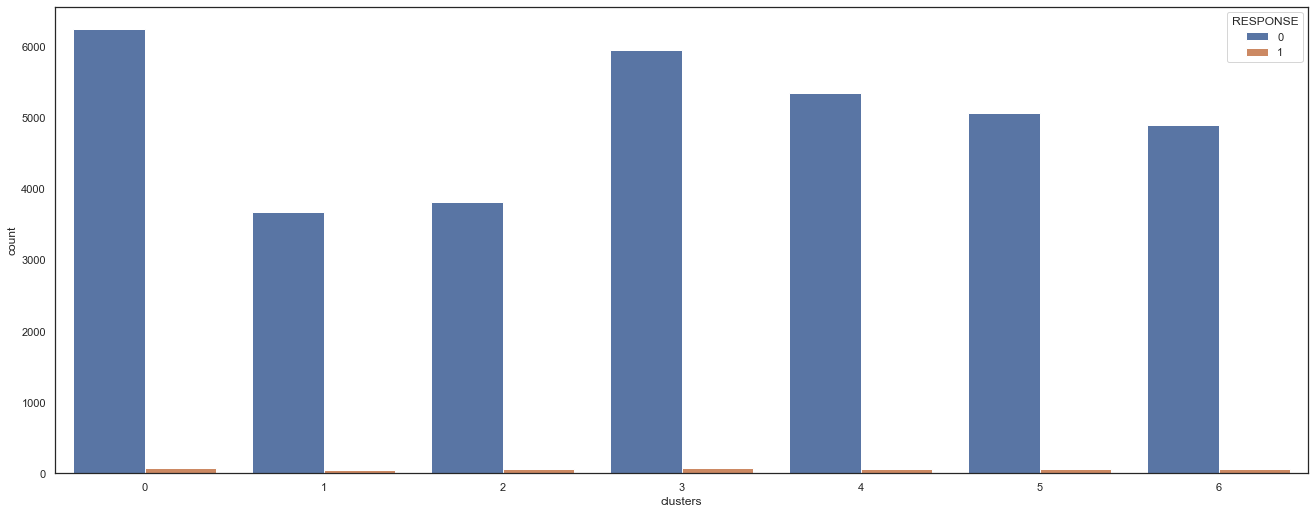

In [117]:
# countplot by Response varibale in clusters 

plt.figure(figsize=(20,8))
ax = sns.countplot(x="clusters", hue="RESPONSE", data=response_clusters)

We can see the in this counting plot how the Response target variables are distributed in the clusters. In the fisrt cluster (0), is where the difference is biggest than other clusters.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

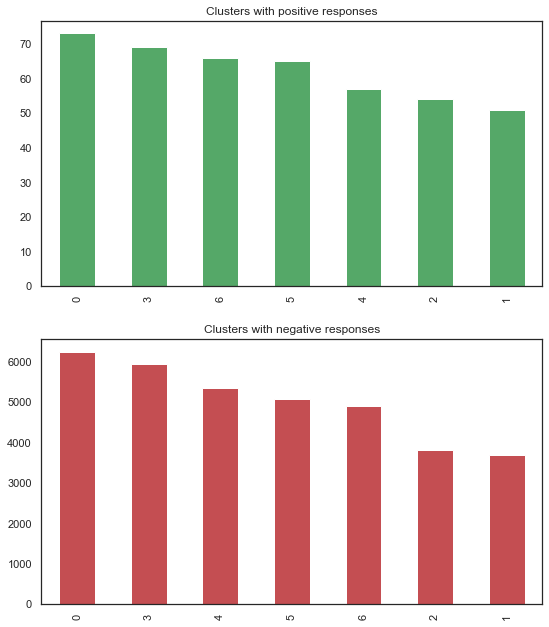

In [118]:
# counting plot of Responses types 

pos_response = response_clusters[response_clusters['RESPONSE'] == 1]
neg_response = response_clusters[response_clusters['RESPONSE'] == 0]

figure, axes = plt.subplots(2, 1, figsize = (8,12), squeeze = False)

pos = pos_response['clusters'].value_counts().plot(kind='bar',figsize=(8,10), color = 'C2', ax = axes[0][0], title = 'Clusters with positive responses')
neg = neg_response['clusters'].value_counts().plot(kind='bar',figsize=(8,10), color = 'C3',  ax = axes[1][0], title = 'Clusters with negative responses')
plt.show()

But in this plot we can see that the distribution of the negatives and positives responses is almost the same in terms of distributions for both, just that clusters 4 and 6 change the proportions of theirs positives and negative resposnes.

In [119]:

# checking mailout_train dataset proportions  
print('mailout_train dataset shape \n')
shape_a = mailout_train.shape
print('Number of rows:', shape_a[0])
print('Number of columns:', shape_a[1])

mailout_train dataset shape 

Number of rows: 42962
Number of columns: 368


In [120]:
# checking the proportion of null values 
pd.set_option('display.max_rows', 400)
percent_missing_a = mailout_train.isnull().sum() * 100 / len(mailout_train)
missing_value_a = pd.DataFrame({'column_name': mailout_train.columns,
                                 'percent_missing': percent_missing_a})
missing_value_a.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
ALTER_KIND4                                  ALTER_KIND4        99.904567
ALTER_KIND3                                  ALTER_KIND3        99.594991
ALTER_KIND2                                  ALTER_KIND2        98.240305
ALTER_KIND1                                  ALTER_KIND1        95.372655
KK_KUNDENTYP                                KK_KUNDENTYP        58.926493
EXTSEL992                                      EXTSEL992        37.121177
W_KEIT_KIND_HH                            W_KEIT_KIND_HH        22.526884
HH_DELTA_FLAG                              HH_DELTA_FLAG        22.526884
KBA05_KRSOBER                              KBA05_KRSOBER        20.129417
KBA05_KRSKLEIN                            KBA05_KRSKLEIN        20.129417
KBA05_KRSHERST2                          KBA05_KRSHERST2        20.129417
KBA05_CCM4                                    KBA05_CCM4        20.129417
KBA05_KRSHERST1                          KBA05_KRSHERST1        20.129417
KBA05_KRSAQUOT                            KBA05_KRSAQUOT        20.129417
KBA05_HERST5                                KBA05_HERST5        20.129417
KBA05_HERST4                                KBA05_HERST4        20.129417
KBA05_HERST3                                KBA05_HERST3        20.129417
KBA05_HERST2                                KBA05_HERST2        20.129417
KBA05_HERST1                                KBA05_HERST1        20.129417
KBA05_GBZ                                      KBA05_GBZ        20.129417
KBA05_FRAU                                    KBA05_FRAU        20.129417
KBA05_DIESEL                                KBA05_DIESEL        20.129417
KBA05_CCM1                                    KBA05_CCM1        20.129417
KBA05_CCM3                                    KBA05_CCM3        20.129417
KBA05_CCM2                                    KBA05_CCM2        20.129417
KBA05_KRSZUL                                KBA05_KRSZUL        20.129417
KBA05_BAUMAX                                KBA05_BAUMAX        20.129417
KBA05_AUTOQUOT                            KBA05_AUTOQUOT        20.129417
KBA05_ANTG4                                  KBA05_ANTG4        20.129417
KBA05_ANTG3                                  KBA05_ANTG3        20.129417
KBA05_ANTG2                                  KBA05_ANTG2        20.129417
KBA05_ANTG1                                  KBA05_ANTG1        20.129417
KBA05_ANHANG                                KBA05_ANHANG        20.129417
KBA05_ALTER4                                KBA05_ALTER4        20.129417
KBA05_ALTER3                                KBA05_ALTER3        20.129417
KBA05_ALTER2                                KBA05_ALTER2        20.129417
KBA05_ALTER1                                KBA05_ALTER1        20.129417
KBA05_KRSVAN                                KBA05_KRSVAN        20.129417
KBA05_ZUL4                                    KBA05_ZUL4        20.129417
KBA05_KW1                                      KBA05_KW1        20.129417
KBA05_KW2                                      KBA05_KW2        20.129417
KBA05_ZUL3                                    KBA05_ZUL3        20.129417
KBA05_ZUL2                                    KBA05_ZUL2        20.129417
KBA05_ZUL1                                    KBA05_ZUL1        20.129417
KBA05_VORB2                                  KBA05_VORB2        20.129417
KBA05_VORB1                                  KBA05_VORB1        20.129417
KBA05_VORB0                                  KBA05_VORB0        20.129417
KBA05_SEG9                                    KBA05_SEG9        20.129417
KBA05_SEG8                                    KBA05_SEG8        20.129417
KBA05_SEG7                                    KBA05_SEG7        20.129417
KBA05_SEG6                                    KBA05_SEG6        20.129417
KBA05_SEG5                                    KBA05_SEG5        20.129417
KBA05_SEG4                                    KBA05_SEG4        20.129417
KBA05_SEG3                                    KBA

In [121]:
del mailout_train['Unnamed: 0']

In [122]:
# cleaning the training set 

for col in mailout_train.columns:
    if mailout_train[col].dtype == np.int64:
        mailout_train[col] = mailout_train[col].astype(np.float64)
            
# using the previuos dataframe to identify missing or unknown data values and convert them to NaNs.  
for row in without_values['Attribute']:
    print(row)
    if row in  mailout_train.columns:
        n_mp = without_values.loc[without_values['Attribute'] == row, 'missings/unknowns'].iloc[0]
        n_ix =  mailout_train.loc[:, row].isin(n_mp)
        without_values.loc[n_ix, row] = np.NaN
    else:
        continue
        
# dropping these columns 
to_drop = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG3', 'KBA05_ANTG4', 'TITEL_KZ']
mailout_train.drop(to_drop, axis=1, inplace = True)

# removing rows which contain more than 50 missing values per row
null_rows = mailout_train.shape[1] - mailout_train.count(axis = 1)
rows_droped = mailout_train.index[null_rows > 50]
mailout_train.drop(rows_droped, axis=0, inplace = True)

# reencoding the binary variable 
mailout_train['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

# removing this vars for simplicity 
to_drop = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
mailout_train.drop(to_drop, axis=1, inplace = True)
mailout_train.shape

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

(34214, 336)

In [123]:
# counting the proportions of the target variable 
mailout_train.RESPONSE.value_counts()

0.0    33790
1.0      424
Name: RESPONSE, dtype: int64

Here we got, for the RESPONSE feature, the following proportions: 

* 0 -> 98.7% (33790/34214)
* 1 ->  1.3%  (424/34214)

We consider it as imbalanced classification (when the distribution of examples across the classes is not equal), so we need to define the right metrics for our model, in order to evaluate it properly.

One of the most important ranking metrics to evaluate classifiers based on how effective they are at separating classes is the AUC ROC (ROC Area Under Curve). Besides being one of the most commonly used, the ROC Curve and ROC AUC can be helpful under a severe class imbalance dataset (when the number of examples in the minority class is small).

We can focus on the minority class, and the other score could be the Precision-Recall AUC (Precision-Recall Area Under Curve). This metric is a helpful diagnostic tool for evaluating a single classifier but challenging for comparing classifiers.

There are also threshold metrics that are those that quantify the classification prediction errors like :     Accuracy(Correct Predictions/Total Predictions), Error(Incorrect Predictions/Total Predictions), Sensitivity (refers to the true positive rate and summarizes how well the positive class was predicted), Specificity (refers to the true negative rate, and summarises how well the negative class was predicted.), as the most important.

And the probabilistic metrics, that are designed specifically to quantify the uncertainty in a classifier’s predictions. There is the LogLoss (the average difference between two probability distributions, a perfect classifier has a log loss of 0.0, with worse values being positive up to infinity) and Brier score (calculated as the mean squared error between the expected probabilities for the positive class and the predicted probabilities).

In this case, for the imbalanced classification we can use the ROC_AUC and Precision-Recall AUC, but as we don't have the target variable in the mailout_test, we rely by the moment, just with the first score. 

In [124]:
# defining labels 
target_variable = mailout_train[['RESPONSE']]
del mailout_train['RESPONSE']
predictor_variables= mailout_train

In [125]:
# logistic class model 

start = time.time()

pipe_1 = Pipeline([
    ('imp', SimpleImputer(missing_values=np.NaN,strategy='mean')),
    ('normalizer', StandardScaler()),
    ('sampling', SMOTE()),
    ('log', LogisticRegression()),
    ])

params = {   
    'log__penalty': ['l1','l2'],
    'log__C': [0.1, 1, 10, 100],
    'log__class_weight': [None, 'balanced']   
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

grid_1 = GridSearchCV(pipe_1, param_grid= params, scoring='roc_auc', cv = cv)
grid_1.fit(predictor_variables, target_variable)


end = time.time()
print("time in seconds:", end-start)

print("roc_auc score:", grid_1.best_score_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to conv

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to conv

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to conv

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pa

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logisti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to conv

time in seconds: 10343.99270772934
roc_auc score: 0.6708348248049344


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
# printing bes estimators 

print(grid_1.best_estimator_)

Pipeline(steps=[('imp', SimpleImputer()),
                ('log', LogisticRegression(C=0.1, class_weight='balanced'))])


In [139]:
# evaluating roc-auc model

scores_1 = cross_val_score(grid_1, predictor_variables, target_variable, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_1 
print(scores_1.mean())

0.6684930956472918


In [134]:
# impute missing values and fit log model

predictor_variables = pd.DataFrame(imp.fit_transform(predictor_variables))
predictor_variables.columns = predictor_variables.columns
predictor_variables.index = predictor_variables.index

logreg = LogisticRegression(C= 10)
logreg.fit(predictor_variables, target_variable)
logreg.coef_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[ 5.31802700e-07, -9.75700400e-03, -3.02552170e-02,
        -2.06836505e-02, -3.36647177e-03,  1.28989591e-03,
         4.12929654e-04, -3.06769227e-03,  3.45153116e-03,
         5.97617251e-04, -2.04099192e-03, -5.77364221e-04,
        -8.16642932e-03,  6.17484411e-03, -4.83372564e-03,
        -4.99646887e-03,  4.37997462e-03,  5.12872084e-03,
         4.83814416e-03,  4.69265570e-03, -1.38667740e-02,
        -6.84014955e-03, -4.99648083e-03, -5.53929297e-03,
         5.92377491e-03, -6.94990685e-03, -1.19716416e-02,
        -4.25851065e-03, -1.18053410e-02, -3.04410530e-03,
        -2.56405541e-03,  3.48788062e-03, -5.46294256e-03,
        -3.30001565e-03, -6.49104033e-03, -4.70944327e-03,
         5.30963181e-03, -3.16381056e-03,  1.20869190e-02,
         2.92905736e-03, -4.36262931e-03, -1.46023688e-02,
        -4.53697476e-02, -6.46020297e-02,  6.78583782e-03,
        -2.72811677e-03, -1.68194808e-02,  4.82762743e-03,
        -1.21083829e-02,  4.35326723e-03,  5.30358142e-0

In [137]:
# feature importance of Logistic R. Classifier

importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.00976
Feature: 2, Score: -0.03026
Feature: 3, Score: -0.02068
Feature: 4, Score: -0.00337
Feature: 5, Score: 0.00129
Feature: 6, Score: 0.00041
Feature: 7, Score: -0.00307
Feature: 8, Score: 0.00345
Feature: 9, Score: 0.00060
Feature: 10, Score: -0.00204
Feature: 11, Score: -0.00058
Feature: 12, Score: -0.00817
Feature: 13, Score: 0.00617
Feature: 14, Score: -0.00483
Feature: 15, Score: -0.00500
Feature: 16, Score: 0.00438
Feature: 17, Score: 0.00513
Feature: 18, Score: 0.00484
Feature: 19, Score: 0.00469
Feature: 20, Score: -0.01387
Feature: 21, Score: -0.00684
Feature: 22, Score: -0.00500
Feature: 23, Score: -0.00554
Feature: 24, Score: 0.00592
Feature: 25, Score: -0.00695
Feature: 26, Score: -0.01197
Feature: 27, Score: -0.00426
Feature: 28, Score: -0.01181
Feature: 29, Score: -0.00304
Feature: 30, Score: -0.00256
Feature: 31, Score: 0.00349
Feature: 32, Score: -0.00546
Feature: 33, Score: -0.00330
Feature: 34, Score: -0.00649
Feature

We can se that this function (cross_val_score) helps us to evaluate the roc-auc score by cross-validation, so in this case we get a mean of 0.680. It's almost the same as the previous calculated (0.684).

In [128]:
# XGBoost classifier

start = time.time()

pipe_2 = Pipeline([ 
    ('imp', SimpleImputer(missing_values=np.NaN,strategy='mean')),
    ('normalizer', StandardScaler()),
    ('xgb', XGBClassifier())
])

params = {
    'xgb__objective': ['binary:logistic', 'binary:hinge'], 
    'xgb__max_depth': [2, 5, 10],
    'xgb__n_estimators': [10, 50],
    'xgb__learning_rate': [0.1, 0.5, 1],
}

cv =RepeatedStratifiedKFold(n_splits=5, n_repeats=3)


grid_2 = GridSearchCV(pipe_2, param_grid= params, scoring='roc_auc', cv = cv)
grid_2.fit(predictor_variables, target_variable)

end = time.time()
print("time in seconds",end-start)

print("roc_auc score:", grid_2.best_score_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:25:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[00:26:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:26:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[00:27:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:27:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[00:27:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:28:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:29:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:29:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[00:30:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[00:31:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:31:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:31:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:31:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:31:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:31:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:32:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:32:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:32:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:32:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:32:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:32:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:32:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[01:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[01:03:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[05:58:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:58:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:59:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:59:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:59:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:59:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:59:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:59:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[05:59:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:59:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:59:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:59:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:59:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:59:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:59:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[08:50:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[08:50:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[08:51:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[08:51:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[08:51:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[10:51:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[10:51:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[10:51:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[10:51:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[10:52:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:30:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:30:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:30:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:30:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:31:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:31:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:32:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:33:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:33:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:33:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:33:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:33:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:33:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:33:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:34:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:34:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:34:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:34:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:34:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:34:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:35:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:35:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:37:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:37:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:38:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:38:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:38:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:38:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:38:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:38:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:39:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:39:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:39:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:40:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:40:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:40:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:40:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:40:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:41:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:41:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:41:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:41:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:42:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:42:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:46:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:46:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:47:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:47:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:48:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:48:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:48:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:48:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:49:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:49:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:50:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:50:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:50:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:50:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:51:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:53:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:53:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:54:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:54:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:54:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:54:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:54:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:55:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:56:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:56:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To rem

[11:58:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
time in seconds 41579.50216507912
roc_auc score: 0.7768046308984282


In [129]:
# printing best estimator 
print(grid_2.best_estimator_)

Pipeline(steps=[('imp', SimpleImputer()), ('normalizer', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])


In [133]:
# evaluating model
scores_2= cross_val_score(grid_2, predictor_variables, target_variable, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_2
print(scores_2.mean())

0.7702948374729304


And for this model, we can see the roc-auc score evaluation by cross-validation with a mean of 0.770.

In [140]:
# fitting the model 

xgb = XGBClassifier(base_score=0.5, booster='gbtree',
                                   colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1,
                               monotone_constraints='()', n_estimators=10,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None)
xgb.fit(predictor_variables, target_variable)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[22:08:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

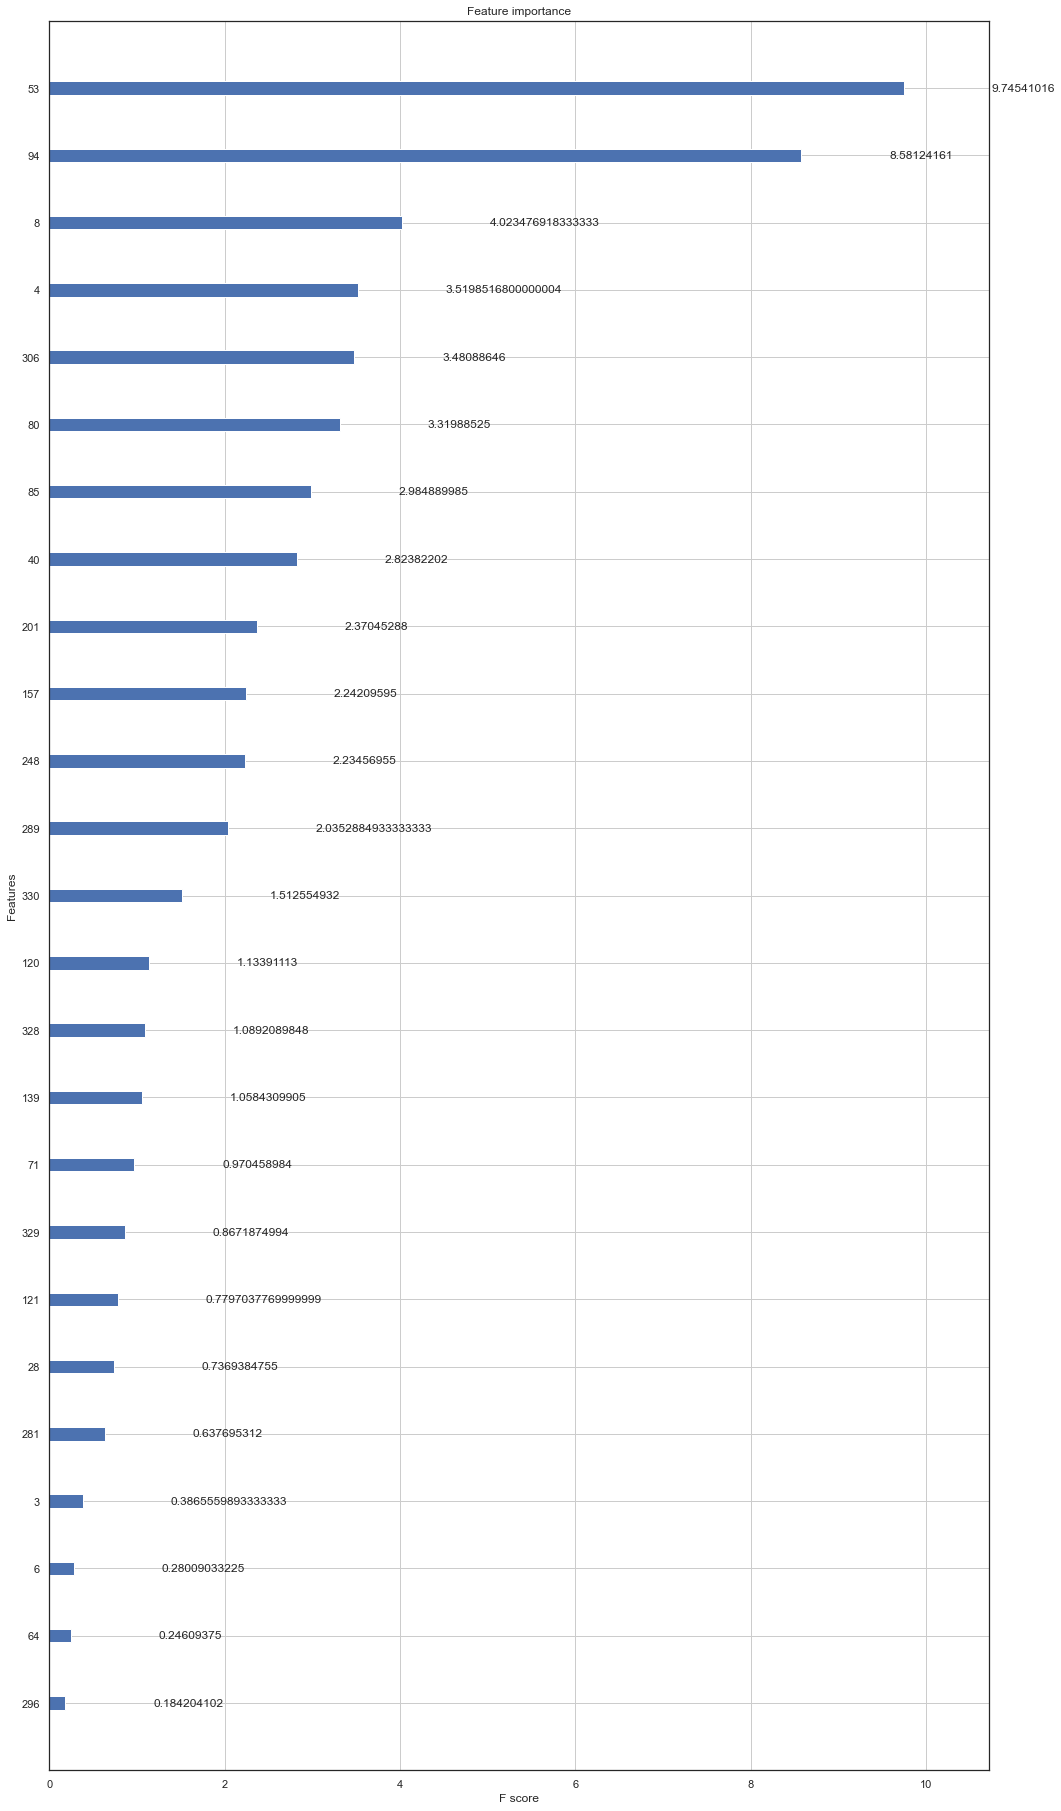

In [141]:
# feature importance plot 
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15,30))
plot_importance(xgb, ax = ax, importance_type="gain")
plt.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [143]:
mailout_test = pd.read_csv('Datasets/mailout_test.csv')

In [144]:
del mailout_test['Unnamed: 0']

# checking mailout_train dataset proportions  
print('mailout_test dataset shape \n')
shape_b = mailout_test.shape
print('Number of rows:', shape_b[0])
print('Number of columns:', shape_b[1])

mailout_test dataset shape 

Number of rows: 42833
Number of columns: 366


In [145]:
# checking the proportion of null values 

pd.set_option('display.max_rows', 400)
percent_missing_a = mailout_test.isnull().sum() * 100 / len(mailout_test)
missing_value_a = pd.DataFrame({'column_name': mailout_test.columns,
                                 'percent_missing': percent_missing_a})
missing_value_a.sort_values(by=['percent_missing'], ascending=False)

column_name  percent_missing
ALTER_KIND4                                  ALTER_KIND4        99.908949
ALTER_KIND3                                  ALTER_KIND3        99.530736
ALTER_KIND2                                  ALTER_KIND2        98.220998
ALTER_KIND1                                  ALTER_KIND1        95.300353
KK_KUNDENTYP                                KK_KUNDENTYP        58.447926
EXTSEL992                                      EXTSEL992        36.908458
HH_DELTA_FLAG                              HH_DELTA_FLAG        22.456984
W_KEIT_KIND_HH                            W_KEIT_KIND_HH        22.456984
KBA05_HERST4                                KBA05_HERST4        19.930894
KBA05_FRAU                                    KBA05_FRAU        19.930894
KBA05_GBZ                                      KBA05_GBZ        19.930894
KBA05_HERST1                                KBA05_HERST1        19.930894
KBA05_HERST2                                KBA05_HERST2        19.930894
KBA05_HERST3                                KBA05_HERST3        19.930894
KBA05_KRSHERST1                          KBA05_KRSHERST1        19.930894
KBA05_HERST5                                KBA05_HERST5        19.930894
KBA05_KRSAQUOT                            KBA05_KRSAQUOT        19.930894
KBA05_CCM4                                    KBA05_CCM4        19.930894
KBA05_KRSHERST2                          KBA05_KRSHERST2        19.930894
KBA05_KRSHERST3                          KBA05_KRSHERST3        19.930894
KBA05_KRSOBER                              KBA05_KRSOBER        19.930894
KBA05_DIESEL                                KBA05_DIESEL        19.930894
KBA05_CCM1                                    KBA05_CCM1        19.930894
KBA05_CCM3                                    KBA05_CCM3        19.930894
KBA05_CCM2                                    KBA05_CCM2        19.930894
KBA05_KRSZUL                                KBA05_KRSZUL        19.930894
KBA05_BAUMAX                                KBA05_BAUMAX        19.930894
KBA05_AUTOQUOT                            KBA05_AUTOQUOT        19.930894
KBA05_ANTG4                                  KBA05_ANTG4        19.930894
KBA05_ANTG3                                  KBA05_ANTG3        19.930894
KBA05_ANTG2                                  KBA05_ANTG2        19.930894
KBA05_ANTG1                                  KBA05_ANTG1        19.930894
KBA05_ANHANG                                KBA05_ANHANG        19.930894
KBA05_ALTER4                                KBA05_ALTER4        19.930894
KBA05_ALTER3                                KBA05_ALTER3        19.930894
KBA05_ALTER2                                KBA05_ALTER2        19.930894
KBA05_ALTER1                                KBA05_ALTER1        19.930894
KBA05_KRSVAN                                KBA05_KRSVAN        19.930894
KBA05_ZUL4                                    KBA05_ZUL4        19.930894
KBA05_KW1                                      KBA05_KW1        19.930894
KBA05_KW2                                      KBA05_KW2        19.930894
KBA05_ZUL3                                    KBA05_ZUL3        19.930894
KBA05_ZUL2                                    KBA05_ZUL2        19.930894
KBA05_ZUL1                                    KBA05_ZUL1        19.930894
KBA05_VORB2                                  KBA05_VORB2        19.930894
KBA05_VORB1                                  KBA05_VORB1        19.930894
KBA05_VORB0                                  KBA05_VORB0        19.930894
KBA05_SEG9                                    KBA05_SEG9        19.930894
KBA05_SEG8                                    KBA05_SEG8        19.930894
KBA05_SEG7                                    KBA05_SEG7        19.930894
KBA05_SEG6                                    KBA05_SEG6        19.930894
KBA05_SEG5                                    KBA05_SEG5        19.930894
KBA05_SEG4                                    KBA05_SEG4        19.930894
KBA05_SEG3                                    KBA

In [146]:
# cleaning the training set 
for col in mailout_train.columns:
    if mailout_test[col].dtype == np.int64:
        mailout_test[col] = mailout_test[col].astype(np.float64)
            
# using the previuos dataframe to identify missing or unknown data values and convert them to NaNs.  
for row in without_values['Attribute']:
    print(row)
    if row in  mailout_test.columns:
        n_mp = without_values.loc[without_values['Attribute'] == row, 'missings/unknowns'].iloc[0]
        n_ix =  mailout_test.loc[:, row].isin(n_mp)
        without_values.loc[n_ix, row] = np.NaN
    else:
        continue
        
# dropping these columns 
to_drop = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANTG3', 'KBA05_ANTG4', 'TITEL_KZ']
mailout_test.drop(to_drop, axis=1, inplace = True)

# removing rows which contain more than 50 missing values per row
null_rows = mailout_test.shape[1] - mailout_test.count(axis = 1)
rows_droped = mailout_test.index[null_rows > 50]
mailout_test.drop(rows_droped, axis=0, inplace = True)

# reencoding the binary variable 
mailout_test['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

# removing this vars for simplicity 
to_drop = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
mailout_test.drop(to_drop, axis=1, inplace = True)
mailout_test.shape

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

(34177, 335)

In [147]:
# saving the LNR feature for submit as ids with the predictions 
test_lnr = mailout_test[['LNR']]

In [148]:
# applying the best model 

pip_xgb = Pipeline([ 
    ('imp', SimpleImputer(missing_values=np.NaN,strategy='mean')),
    ('normalizer', StandardScaler()),
    ('xgb', XGBClassifier())
])

params = {
    'xgb__objective': ['binary:logistic'],
    'xgb_booster': ['gbtree'],
    'xgb_tree_method': ['exact'],
    'xgb_subsample': [1],
    'xgb_verbosity': [None],
    'xgb_validate_parameters': [1],
    'xgb_reg_lambda': [1],
    'xgb_scale_por_wight': [1],
    'xgb_reg_alpha': [0],
    'xgb_min_child_weight': [1],
    'xgb_max_delta_step': [0],
    'xgb_colsample_bylevel': [1],
    'xgb_colsample_bynode': [1],
    'xgb_colsample_bytree': [1],
    'xgb_gamma': [0],
    'xgb_gpu_id': [1],
    'xgb__base_score': [0.5],
    'xgb__booster': ['gbtree'],
    'xgb__importance_type': ['gain'],
    'xgb__num_parallel_tree': [1],
    'xgb__reg_lambda': [1],
    'xgb__subsample': [1],
    'xgb__tree_method': ['exact'],
    'xgb__validate_parameters': [1],
    'xgb__max_depth': [5],
    'xgb__n_estimators': [10],
    'xgb__learning_rate': [0.1],
    'xgb__n_jobs': [8], 
    'xgb__validate_parameters': [None],
    'xgb_pos_weight': [1],
}
pip_xgb.fit(predictor_variables, target_variable)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[22:08:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('imp', SimpleImputer()), ('normalizer', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [149]:
# calculating prediction probabilities for the test dataset
probs = pip_xgb.predict_proba(mailout_test)

In [150]:
# creating the csv file to be submitted to Kaggle 

probs_ = pd.DataFrame(probs[:, 1])
probs_.rename(columns={0: 'RESPONSE'}, inplace=True)

submit = pd.merge(test_lnr, probs_, left_index=True, right_index=True)
submit.to_csv('kaggle.csv', index = False)
submit

LNR  RESPONSE
0       1754.0  0.005010
1       1770.0  0.002557
2       1465.0  0.000070
3       1470.0  0.000039
4       1478.0  0.000273
...        ...       ...
34172  75930.0  0.000420
34173  76241.0  0.000098
34174  76243.0  0.002923
34175  76247.0  0.011458
34176  71464.0  0.007070

[27290 rows x 2 columns]

## Conclusions


Working with unsupervised learning helped us understand the general population data, in other words, who of the people could be our customers, this with the help of PCA and Kmeans algorithms. The other part, the supervised learning helped us to predict the probability of new customers.

Working with PCA, we realized that for explaining 90% of the variance we needed 173 components. 

Mapping the weights of the pincipal components (top 5 negatively and positively correlated feature weights), we got this :

* For component 1, the top 5 positive features are related to 6-10 family houses in the PLZ8, number of >10 family houses in the PLZ8; and the top negative are social status fine, social status rough, moving patterns and number of 1-2 family houses in the PLZ8.
    
* For component 2,the top 5 positive features are related to number of cars with less than 5 seats in the PLZ8, share of BMW within the PLZ8, share of MERCEDES within the PLZ8,share of BMW & Mercedes Benz within the PLZ8; and the top 5 negative are share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8, share of cars with max speed between 140 and 210 km/h within the PLZ8, share of car owners between 21 and 25 within the PLZ8, share of cars with max speed between 110 km/h and 180km/h within the PLZ8. 
    
* For component 3, the top 5 positive features are related to main age within the household, financial typology: money saver, dominating movement in the person's youth (avantgarde or mainstream); and the top 5 negative are age classification through prename analysis,financial typology: be prepared.    

* For component 6, the top 5 positive features are related to affinity indicating in what way the person is familiar minded, affinity indicating in what way the person is cultural minded, affinity indicating in what way the person is social minded, affinity indicating in what way the person is dreamily; and the top 5 negatives are gender, affinity indicating in what way the person is dominant minded, affinity indicating in what way the person is eventful orientated, affinity indicating in what way the person is of a frightfull attitude.
    
Applying the elbow method, we noticed that the optimal number for clustering was with 7 clusters.


And for the results in the clusters, we got this:

*	For cluster number 3 as it was the most overrepresented cluster for the customer data, the components with the highest and negative weights were number 10 and 1 respectively. 

*	For cluster number 1, as it was the middle overrepresented cluster for the customer data, the components with the highest and negative weights were number 3 and 1 respectively.

*	For cluster number 5, as it was the most underrepresented cluster for the customer data, the components with the highest and negative weights were number 1 and 7 respectively.



The metric we used for evaluate the models was the ROC-AUC metric, because this is the right one for misbalanced classifications. For the imputation part, we used the mean for simplicty. And in the modeling part, comparing ROC-AUC scores we got 0.684 for the logistic classification and 0.781 for the XGBoost Classifier. Once we applyed GridSearch to the models, we select the best one and test it with the mailout_test to submit the results on kaggle. 



## Challanges

It was challenging because as first "Customer Segmentation Analysis", decomposing the data in order to get valuable insights from the principal components to pos/neg correlated feature weights; from fitting the kmeans model with the right cluster to the clustering on the customers data using the model generated (kmeans using azdias data) was interesting and amusing but a little bit difficult.

Understanding the Attributes descriptions and meanings was also difficult to me, because sometimes the meanings were  not clearly and I made some inferences, when doing this is not the right thing because we can alter the true insights about the original data.  

## Final thoughts

* It would be fine to know all the attributes descriptions to know more about the data. 
* For simplicity we fill NAN values with the mean.
* Interpreting Principal components was difficult, but I tryed to explain them. 
* We used just one metric to evaluate the model: ROC-AUC score. 
* We worked with 2 known and powerful algorithms : Logistic Regression and XGBoost for classification. 
* We selected the best algorithms according to gridserach and best score.
* We could improve the code buildig functions to work directly with the data an have a clear order.